In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import mannwhitneyu, chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, log_loss
from bayes_opt import BayesianOptimization
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTENC
from collections import Counter
from sklearn.inspection import permutation_importance
import shap

os.getcwd()

'd:\\코드잇\\프로젝트\\중급 프로젝트2\\Project_share_office'

# rawdata 불러오기

In [ ]:
# 분석에 필요한 파일 불러오기
csv_files = [file for file in os.listdir(os.getcwd()) if file.endswith('.csv')]

# CSV 파일을 읽어서 딕셔너리에 저장
dataset = {}
for file in csv_files:
    file_path = os.path.join(os.getcwd(), file)  # 파일 경로 생성
    key = file.replace('.csv', '').replace('trial_', '')  # .csv와 trial_ 문자열 제거
    df = pd.read_csv(file_path)  # CSV 파일 읽기
    dataset[key] = df  # 수정된 키 사용

# 모든 데이터프레임 확인
for filename, df in dataset.items():
    print(f"DataFrame for file '{filename}':\n", df.head())  # 각 데이터프레임의 상위 5개 행 출력

DataFrame for file 'full_data':
    trial_date                             user_uuid trial_YM entry_hours  \
0  2021-05-01  badbde4d-886b-4992-a8e3-fd0c05640183  2021-05         NaN   
1  2021-05-01  9f5e2bd3-65c9-4800-84c1-f5c93f44d096  2021-05         NaN   
2  2021-05-01  844319ff-cd15-4633-9900-6eaf4dc68b68  2021-05         NaN   
3  2021-05-01  f25078d1-1030-485c-85c5-dc82d6987043  2021-05         NaN   
4  2021-05-01  fce967b5-070c-46ed-a5fa-ef7d298cc7aa  2021-05         [5]   

  exit_hours 출근시간대 퇴근시간대  평균_입(퇴)실횟수  site_id                 총 이용 시간  ...  \
0        NaN   NaN   NaN         NaN      NaN                     NaN  ...   
1        NaN   NaN   NaN         NaN      NaN                     NaN  ...   
2        NaN   NaN   NaN         NaN      NaN                     NaN  ...   
3        NaN   NaN   NaN         NaN      NaN                     NaN  ...   
4        [7]    심야    심야         1.0      1.0  0 days 02:22:20.682465  ...   

   소비자심리지수  경제성장률  기준금리  취업준비자      취업자  

In [ ]:
dataset['site_area']

,site_id,area_pyeong,floor_num,floor_lowest,floor_highest
0,1,50,1,1,1
1,2,100,1,2,2
2,3,150,2,3,4
3,4,100,1,3,3
4,5,150,1,1,1
5,6,150,2,-1,1
6,17,50,1,1,1
7,47,50,1,-1,-1
8,49,50,1,1,1
9,50,50,1,2,2


# 문제 정의를 위한 유료 전환율 살펴보기

## register 살펴보기

In [ ]:
# trial_register 데이터 살펴보기
register = dataset['register'].copy()
display(register.head())
display(register.info())
display(register.describe())


,trial_date,user_uuid
0,2023-12-21,2b251333-8676-4c11-a736-dcf2350f8821
1,2023-12-21,e111619a-0975-451b-9a4a-bc8aea7b7b84
2,2023-12-21,4a184795-b056-4572-a874-644f68609ea3
3,2023-12-21,2ba8ab19-2d40-4423-ad04-f0f9ca814871
4,2023-12-21,1d49ba36-6c23-405b-9514-aa7f4aeceff0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9659 entries, 0 to 9658
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   trial_date  9659 non-null   object
 1   user_uuid   9659 non-null   object
dtypes: object(2)
memory usage: 151.1+ KB


None

,trial_date,user_uuid
count,9659,9659
unique,855,9624
top,2022-12-08,dceba5c8-20c2-497a-829a-74099f7ee5a8
freq,144,2


In [ ]:
register['user_uuid'].duplicated().sum()

35

이름과 결제 여부가 똑같은 35명이 존재했다. 미션 가이드에 따르면, 전산 오류로 인해 현장 매니저가 새로 추가해주거나, 기존에 신청했는데 그 날 방문하지 못해 취소하고 다시 한 경우가 포함되어 있었다. 그렇기 때문에 마지막 신청 기록을 제외한 중복기록을 삭제했다.

In [ ]:
register = register.drop_duplicates(subset = ['user_uuid'], keep='last')
register.shape

(9624, 2)

In [ ]:
register['trial_date'] = pd.to_datetime(register['trial_date'])
register['YM'] = register['trial_date'].dt.to_period('M')
register['date'] = register['trial_date'].dt.date
register.sort_values(by = 'trial_date', inplace=True)
register.head()

,trial_date,user_uuid,YM,date
427,2021-05-01,badbde4d-886b-4992-a8e3-fd0c05640183,2021-05,2021-05-01
431,2021-05-01,9f5e2bd3-65c9-4800-84c1-f5c93f44d096,2021-05,2021-05-01
429,2021-05-01,844319ff-cd15-4633-9900-6eaf4dc68b68,2021-05,2021-05-01
428,2021-05-01,f25078d1-1030-485c-85c5-dc82d6987043,2021-05,2021-05-01
426,2021-05-01,fce967b5-070c-46ed-a5fa-ef7d298cc7aa,2021-05,2021-05-01


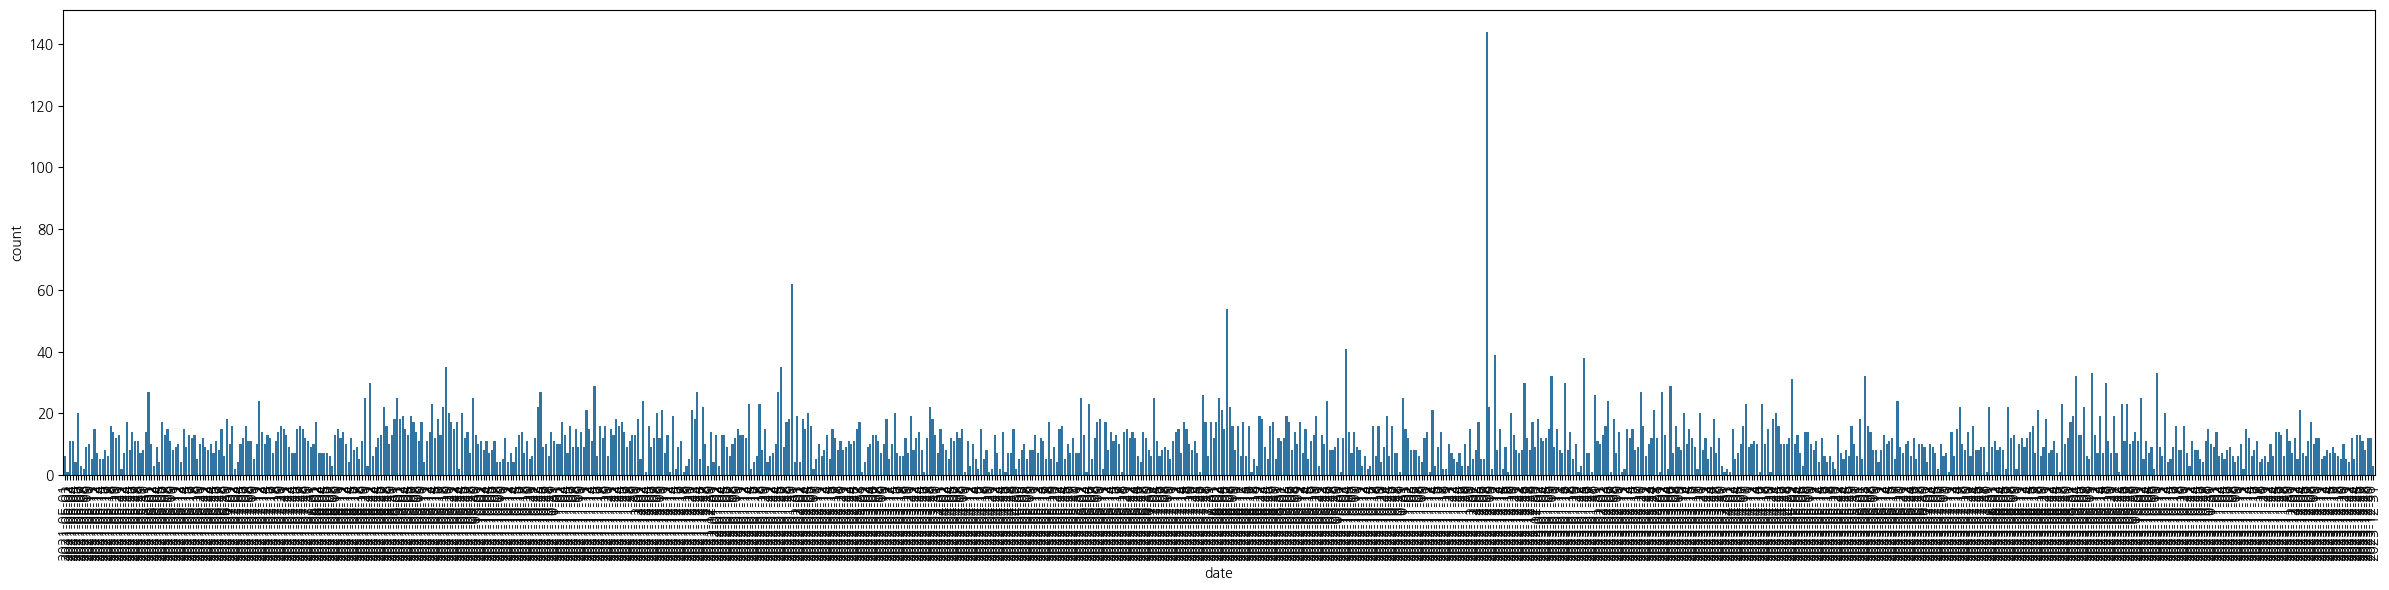

In [ ]:
fig = plt.figure(figsize=(24,6))
plt.xticks(rotation = 90)
sns.countplot(data = register, x = 'date')
plt.tight_layout()
plt.show()

In [ ]:
# 가장 많은 날짜 확인
register.groupby('date').size().reset_index(name = 'count').sort_values(by='count', ascending = False)

,date,count
526,2022-12-08,144
269,2022-01-30,62
430,2022-08-07,54
474,2022-10-04,41
529,2022-12-12,39
...,...,...
534,2022-12-18,1
560,2023-01-22,1
565,2023-01-28,1
572,2023-02-07,1


22년 12월 8일에 신청자 수가 144건으로 2번째로 많은 날(22년 1월 30일, 62건)보다 2배 이상 많았다. 그 이유를 알아보기 위해 access_log를 확인했다.

In [ ]:
dataset['access_log'].groupby('site_id')['cdate'].min().reset_index(name = 'min_cdate')

,site_id,min_cdate
0,1,2021-05-03 05:20:36.931652
1,2,2021-05-06 05:48:22.282740
2,3,2021-05-02 09:42:13.893455
3,4,2021-05-12 00:34:48.235545
4,5,2021-09-03 01:00:16.574002
5,6,2021-11-15 06:33:11.639395
6,17,2022-08-08 00:22:41.367042
7,47,2022-12-09 00:13:28.695039
8,49,2023-04-22 04:57:18.815252


site_id 47번(분당점)의 첫 사용일이 12월 9일이다.

일반적으로 하루 전에 무료 체험 신청을 한다는 점을 고려하면 분당점 오픈에 맞춰 무료 체험 신청을 한 사람이 많음을 알 수 있다.

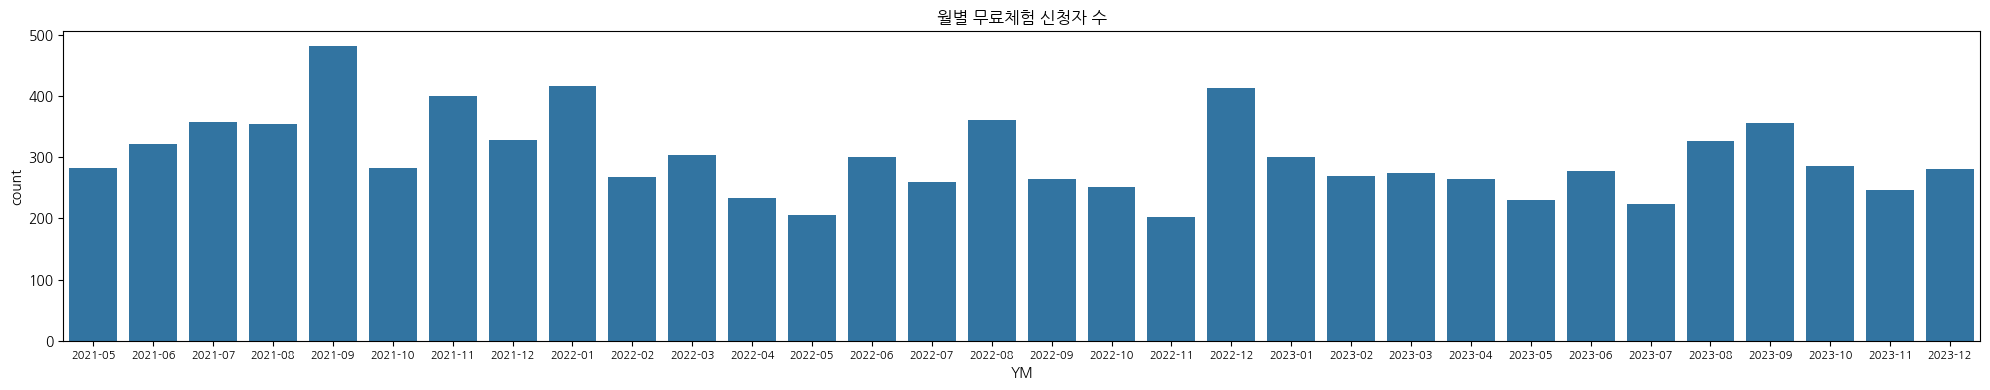

In [ ]:
# 월별 무료 체험 신청자 수
fig = plt.figure(figsize=(20,4))
plt.xticks(fontsize=8)
sns.countplot(data = register, x = 'YM')
plt.title('월별 무료체험 신청자 수')
plt.tight_layout()
plt.show()

## payment 살펴보기

In [ ]:
payment = dataset['payment'].copy()
display(payment.head())
display(payment.info())
display(payment.describe())

,is_payment,user_uuid
0,0,2b251333-8676-4c11-a736-dcf2350f8821
1,0,e111619a-0975-451b-9a4a-bc8aea7b7b84
2,1,4a184795-b056-4572-a874-644f68609ea3
3,0,2ba8ab19-2d40-4423-ad04-f0f9ca814871
4,0,1d49ba36-6c23-405b-9514-aa7f4aeceff0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9659 entries, 0 to 9658
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   is_payment  9659 non-null   int64 
 1   user_uuid   9659 non-null   object
dtypes: int64(1), object(1)
memory usage: 151.1+ KB


None

,is_payment
count,9659.000000
mean,0.379335
std,0.485247
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
payment.isnull().sum()

is_payment    0
user_uuid     0
dtype: int64

In [ ]:
payment['user_uuid'].duplicated().sum()

35

In [ ]:
payment = payment.drop_duplicates(subset = ['user_uuid'], keep='last')
payment.shape

(9624, 2)

In [ ]:
# register과 payment의 유저 명단 확인
if set(register['user_uuid'].unique()) == set(payment['user_uuid'].unique()):
    print("유저 명단이 동일합니다.")
else:
    print("유저 명단이 다릅니다.")

유저 명단이 동일합니다.


payment에서도 register와 동일하게 user_uuid의 중복이 있어 제거한 후, 유저 명단을 확인한 결과 동일하게 처리되었음을 확인했다.

is_payment가 1일 때 결제한 것이므로 무료체험을 신청한 유저들 중 약 38%가 유료결제를 진행했다.

전체 평균만 봤을 때 괜찮은 전환율이지만 월별, 일별로 무료체험 신청의 차이가 있었으니 결제 여부도 시기별로 따져봐야 한다.

In [ ]:
regi_pay = pd.merge(register,payment, how = 'left')
regi_pay

,trial_date,user_uuid,YM,date,is_payment
0,2021-05-01,badbde4d-886b-4992-a8e3-fd0c05640183,2021-05,2021-05-01,1
1,2021-05-01,9f5e2bd3-65c9-4800-84c1-f5c93f44d096,2021-05,2021-05-01,1
2,2021-05-01,844319ff-cd15-4633-9900-6eaf4dc68b68,2021-05,2021-05-01,1
3,2021-05-01,f25078d1-1030-485c-85c5-dc82d6987043,2021-05,2021-05-01,1
4,2021-05-01,fce967b5-070c-46ed-a5fa-ef7d298cc7aa,2021-05,2021-05-01,1
...,...,...,...,...,...
9619,2023-12-30,e9b1a5df-d70c-4ccf-af22-64fdae98d3a2,2023-12,2023-12-30,0
9620,2023-12-30,aa4773c8-dbc9-4c80-849b-1ab8d1db7bda,2023-12,2023-12-30,0
9621,2023-12-31,acf3e288-4487-492b-9477-df149fb72e83,2023-12,2023-12-31,0
9622,2023-12-31,0e58ea5a-ebe4-48cb-b31b-d02a4f350cf8,2023-12,2023-12-31,1


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
YM,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,...,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12
유료전환율,0.503546,0.529595,0.434174,0.384181,0.39834,0.43617,0.3925,0.349544,0.362981,0.402985,...,0.36,0.373585,0.447826,0.379061,0.357143,0.361963,0.258427,0.297203,0.231707,0.241993


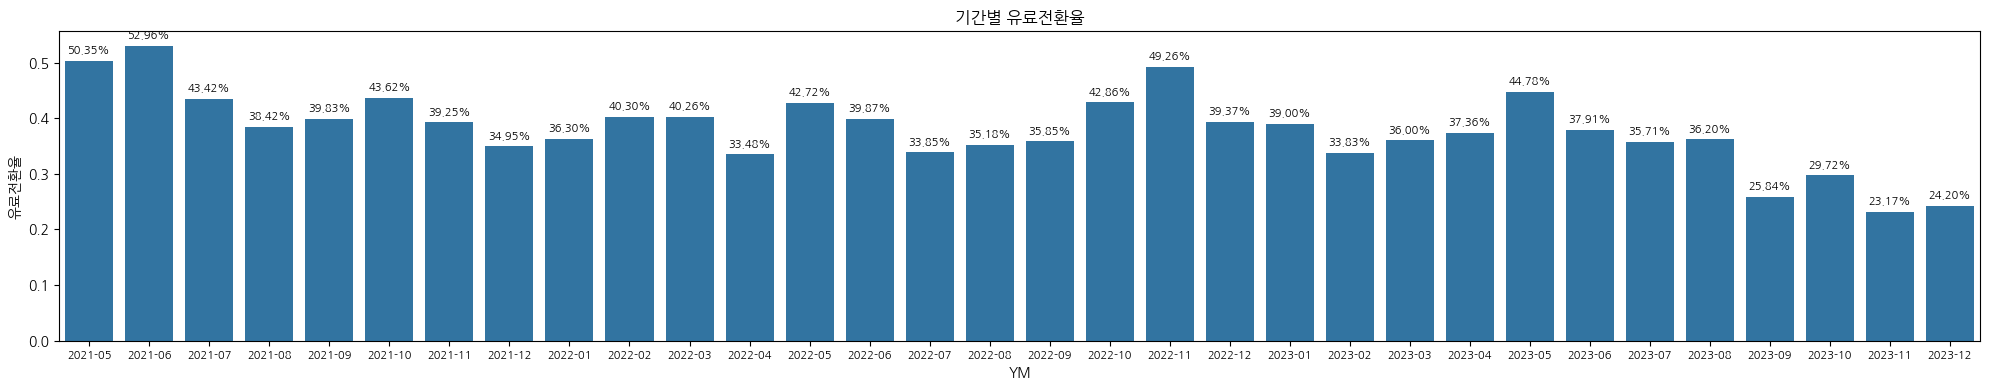

In [ ]:
monthly_convert = regi_pay.groupby('YM')['is_payment'].mean().reset_index(name='유료전환율')
display(monthly_convert.T)
plt.figure(figsize = (20,4))
ax = sns.barplot(data=monthly_convert, x='YM', y='유료전환율')

# y값 표시
for i, bar in enumerate(ax.patches):
    y_value = bar.get_height()  # 막대 높이
    plt.text(
        x=bar.get_x() + bar.get_width() / 2,  # 막대의 x 좌표 (중앙 정렬)
        y=y_value + 0.01,  # 막대 높이 바로 위에 텍스트 추가
        s=f'{y_value:.2%}',  # 퍼센트 형식으로 표시
        ha='center',  # 수평 가운데 정렬
        va='bottom',  # 수직 아래 정렬
        fontsize=8
    )

plt.xticks(fontsize=8)
plt.title('기간별 유료전환율')


plt.tight_layout()
plt.show()

기간별 유료전환율을 확인했을 때 23년 9월부터 유료전환율이 30% 이하로 감소했다.
이에 퍼널 분석을 실시했다.

## 퍼널 분석

In [ ]:
# 무료체험 신청자 수
print(f"무료체험 신청자 수: {regi_pay.shape[0]}")

# 무료체험 경험자 수
visit_info = dataset['visit_info'].copy()
print(f"무료체험 경험자 수{visit_info['user_uuid'].nunique()}")

# 유료결제자 수
print(f"유료 결제자 수: {payment[payment['is_payment']==1].shape[0]}")

무료체험 신청자 수: 9624
무료체험 경험자 수6535
유료 결제자 수: 3652


In [ ]:
# 퍼널 1단계: 무료 체험 신청
funnel_1 = regi_pay.groupby('YM')['user_uuid'].nunique().reset_index(name='무료체험신청')

# 퍼널 2단계: 무료 체험 방문
visit_info['YM'] = pd.to_datetime(visit_info['date'])
visit_info['YM'] = visit_info['YM'].dt.to_period('M')
funnel_2 = visit_info.groupby('YM')['user_uuid'].nunique().reset_index(name='무료체험방문')

# 퍼널 3단계: 유료 결제
converter = regi_pay[regi_pay['is_payment'] == 1]
funnel_3 = converter.groupby('YM')['user_uuid'].nunique().reset_index(name='유료결제')

# 퍼널 데이터프레임 만들기
funnel_df = pd.merge(funnel_1,funnel_2,how='left',on='YM')
funnel_df = pd.merge(funnel_df, funnel_3, how='left',on='YM')
funnel_df

,YM,무료체험신청,무료체험방문,유료결제
0,2021-05,282,144,142
1,2021-06,321,206,170
2,2021-07,357,246,155
3,2021-08,354,203,136
4,2021-09,482,350,192
5,2021-10,282,187,123
6,2021-11,400,226,157
7,2021-12,329,238,115
8,2022-01,416,252,151
9,2022-02,268,230,108


In [ ]:
funnel_df2 = funnel_df.copy()
funnel_df2['interval_1'] = (funnel_df2['무료체험방문'] / funnel_df2['무료체험신청']) * 100
funnel_df2['interval_2'] = (funnel_df2['유료결제'] / funnel_df2['무료체험방문']) * 100
funnel_df2['final_survive'] = (funnel_df2['유료결제'] / funnel_df2['무료체험신청']) * 100
funnel_df2.rename(columns={'interval_1':'신청-방문 생존률', 'interval_2':'방문-결제 생존률', 'final_survive':'신청-결제 생존률'},inplace=True)
funnel_df2

,YM,무료체험신청,무료체험방문,유료결제,year,신청-방문 생존률,방문-결제 생존률,신청-결제 생존률
0,2021-05,282,144,142,2021,51.063830,98.611111,50.354610
1,2021-06,321,206,170,2021,64.174455,82.524272,52.959502
2,2021-07,357,246,155,2021,68.907563,63.008130,43.417367
3,2021-08,354,203,136,2021,57.344633,66.995074,38.418079
4,2021-09,482,350,192,2021,72.614108,54.857143,39.834025
5,2021-10,282,187,123,2021,66.312057,65.775401,43.617021
6,2021-11,400,226,157,2021,56.500000,69.469027,39.250000
7,2021-12,329,238,115,2021,72.340426,48.319328,34.954407
8,2022-01,416,252,151,2022,60.576923,59.920635,36.298077
9,2022-02,268,230,108,2022,85.820896,46.956522,40.298507


In [ ]:
funnel_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype    
---  ------     --------------  -----    
 0   YM         32 non-null     period[M]
 1   무료체험신청     32 non-null     int64    
 2   무료체험방문     32 non-null     int64    
 3   유료결제       32 non-null     int64    
 4   year       32 non-null     int64    
 5   신청-방문 생존률  32 non-null     float64  
 6   방문-결제 생존률  32 non-null     float64  
 7   신청-결제 생존률  32 non-null     float64  
dtypes: float64(3), int64(4), period[M](1)
memory usage: 2.1 KB


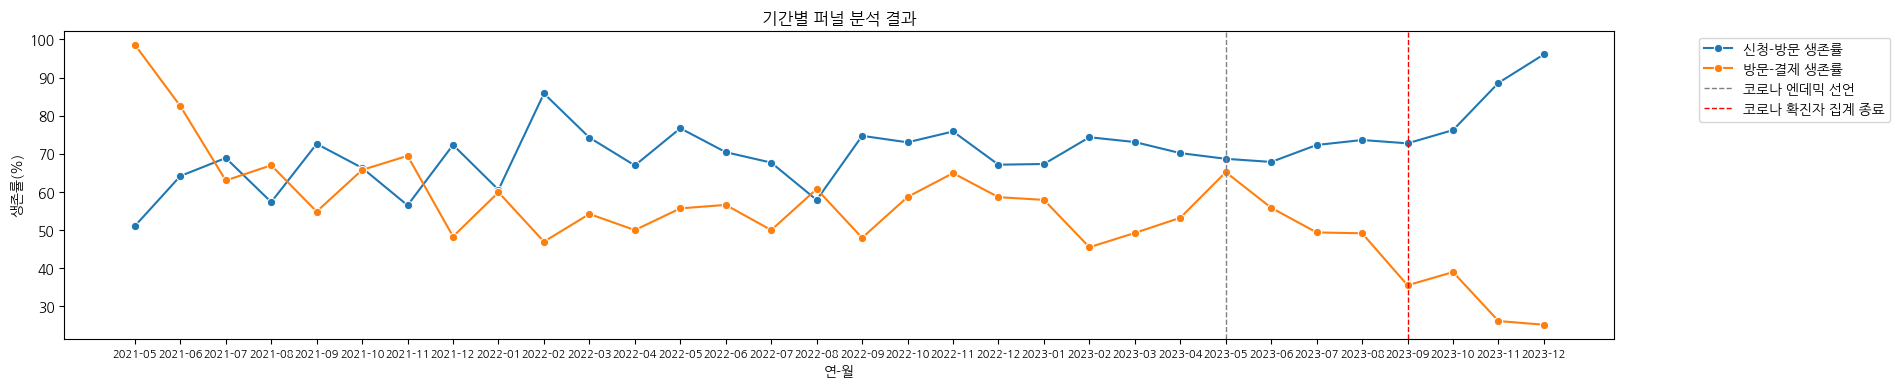

In [ ]:
funnel_df2['YM'] = funnel_df2['YM'].astype(str)
fig = plt.figure(figsize=(20,4))
ax_1 = sns.lineplot(data = funnel_df2, x = 'YM', y = '신청-방문 생존률', label = '신청-방문 생존률', marker='o')
ax_2 = sns.lineplot(data = funnel_df2, x = 'YM', y = '방문-결제 생존률', label = '방문-결제 생존률', marker='o')

# 코로나 엔데믹 선언
plt.axvline(x="2023-05", color="gray", linestyle="--", linewidth=1, label = '코로나 엔데믹 선언')
# 확진자 집계 중지
plt.axvline(x="2023-09", color="red", linestyle="--", linewidth=1, label = '코로나 확진자 집계 종료')

plt.title('기간별 퍼널 분석 결과')
plt.ylabel('생존률(%)')
plt.xlabel('연-월')
plt.xticks(fontsize=8)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [ ]:
funnel_df['year'] = funnel_df['YM'].dt.year

funnel_year = funnel_df.groupby('year')[['무료체험신청','무료체험방문','유료결제']].sum().reset_index()

fig = make_subplots(
    rows=1, cols=3,  # 1행 3열
    subplot_titles=['2021년','2022년','2023년']  # 각 서브플롯의 제목
)

# 각 퍼널 그래프를 서브플롯에 추가
for i, row in funnel_year.iterrows():
    survive_to_visit = (row['무료체험방문']/row['무료체험신청'])*100
    survive_to_payment = (row['유료결제']/row['무료체험방문'])*100
    fig.add_trace(
        go.Funnel(
            x=row[1:],  # 데이터 값 ('무료체험신청', '무료체험방문', '유료결제')
            y=['무료체험신청', '무료체험방문', '유료결제'],  # 단계 이름
            textposition="inside",
            textinfo="value+percent initial",
            opacity=0.8,
            marker=dict(
                color=["#3366FF", "#86DD23", "#38D3FF"],
                line=dict(width=2, color="#F1FAEE")
            ),
            connector=dict(
                line=dict(color="#A8DADC", dash="dot", width=2)
            )
        ),
        row=1, col=i + 1  # 서브플롯의 위치
    )
    # 생존률 텍스트 추가
    fig.add_annotation(
        x=0.5, y=1.6,  # 무료체험방문과 유료결제 사이의 위치
        text=f"방문 → 결제: {survive_to_payment:.1f}%",
        showarrow=False,
        row=1, col=i+1,
        font=dict(size=12, color="#000"),
        bgcolor="#F1FAEE"
    )

    fig.add_annotation(
        x=0.5, y=0.6,  # 무료체험신청과 무료체험방문 사이의 위치
        text=f"신청 → 방문: {survive_to_visit:.1f}%",
        showarrow=False,
        row=1, col=i+1,
        font=dict(size=12, color="#000"),
        bgcolor="#F1FAEE"
    )

# 전체 그래프 레이아웃 설정
fig.update_layout(
    title="연도별 퍼널 그래프",
    height=600,
    width=1200,
    showlegend=False
)

# 그래프 출력
fig.show()

문제: 무료체험 신청 ~ 방문 단계의 생존률은 증가하지만 방문 ~ 결제 단계의 생존률은 매년 감소함. 무료 체험 후 유료전환율을 높여야 한다!


# 데이터 결합

투입 변수 (파생변수, 외부 데이터 포함)
- 주요 이용 지점(체류시간이 가장 긴 지점)
    * 지점 관련 정보(면적, 평균 무료체험 이용자 수, 층 수, 최저층, 최고층, 주변 식당, 주변 역, 주변 카페 등)
- 이용한 지점 수
- 출근 시간대
- 퇴근 시간대
- 주요 활동 시간대
- 취업준비자 수
- 금리


visit_info 정보와 access_log 정보가 일치하지 않는 경우가 많음.<br>그러므로 visit_info에서는 주요 이용 지점만 파악하고, 나머지 관련 정보는 access_log에서 추출

## access_log

In [ ]:
access_log = dataset['access_log'].copy()
access_log['cdate'] = pd.to_datetime(access_log['cdate'])
access_log['date'] = access_log['cdate'].dt.date
access_log.sort_values(['user_uuid','id'],inplace=True)

print('데이터 형태:', access_log.shape)
print('유저 수:', access_log['user_uuid'].nunique())
# 중복 확인
print("중복된 데이터 수",access_log.duplicated().sum())

access_log.drop_duplicates(keep='first', inplace=True)

print('중복 제거 후 형태:', access_log.shape)

데이터 형태: (63708, 6)
유저 수: 6026
중복된 데이터 수 359
중복 제거 후 형태: (63349, 6)


In [ ]:
access_log.head()

,id,checkin,cdate,site_id,user_uuid,date
52010,1860957,1,2023-09-05 02:57:01.695334,6,000590dc-046f-462b-8225-4c81a97b7166,2023-09-05
52014,1861306,2,2023-09-05 04:24:05.907486,6,000590dc-046f-462b-8225-4c81a97b7166,2023-09-05
52009,1861324,1,2023-09-05 04:27:46.318391,6,000590dc-046f-462b-8225-4c81a97b7166,2023-09-05
52013,1861958,2,2023-09-05 07:14:07.010936,6,000590dc-046f-462b-8225-4c81a97b7166,2023-09-05
52011,1861969,1,2023-09-05 07:16:13.012870,6,000590dc-046f-462b-8225-4c81a97b7166,2023-09-05


In [ ]:
# 잘못된 데이터 제거(두 번 연속으로 입력된 케이스)
access_log2 = access_log.copy()
# 사용자와 사이트별로 정렬 후 시간 간격 계산
access_log2 = access_log2.sort_values(by=['user_uuid', 'site_id', 'cdate']).reset_index(drop=True)
access_log2['time_diff'] = access_log2.groupby(['user_uuid', 'site_id'])['cdate'].diff()
access_log2

,id,checkin,cdate,site_id,user_uuid,date,time_diff
0,1860957,1,2023-09-05 02:57:01.695334,6,000590dc-046f-462b-8225-4c81a97b7166,2023-09-05,NaT
1,1861306,2,2023-09-05 04:24:05.907486,6,000590dc-046f-462b-8225-4c81a97b7166,2023-09-05,0 days 01:27:04.212152
2,1861324,1,2023-09-05 04:27:46.318391,6,000590dc-046f-462b-8225-4c81a97b7166,2023-09-05,0 days 00:03:40.410905
3,1861958,2,2023-09-05 07:14:07.010936,6,000590dc-046f-462b-8225-4c81a97b7166,2023-09-05,0 days 02:46:20.692545
4,1861969,1,2023-09-05 07:16:13.012870,6,000590dc-046f-462b-8225-4c81a97b7166,2023-09-05,0 days 00:02:06.001934
...,...,...,...,...,...,...,...
63344,388312,2,2022-01-13 04:24:23.933626,6,fffbf2b3-7853-4c07-bd2a-aae686ac9013,2022-01-13,0 days 00:03:40.590639
63345,388321,1,2022-01-13 04:26:19.179574,6,fffbf2b3-7853-4c07-bd2a-aae686ac9013,2022-01-13,0 days 00:01:55.245948
63346,388648,2,2022-01-13 06:04:23.382487,6,fffbf2b3-7853-4c07-bd2a-aae686ac9013,2022-01-13,0 days 01:38:04.202913
63347,388657,1,2022-01-13 06:06:16.523396,6,fffbf2b3-7853-4c07-bd2a-aae686ac9013,2022-01-13,0 days 00:01:53.140909


In [ ]:
# 이전 행의 checkin 값 가져오기
access_log2['prev_checkin'] = access_log2.groupby(['user_uuid', 'site_id'])['checkin'].shift()

# 시간 간격이 3초 미만이고 checkin 값이 동일한 경우 필터링
filtered_logs = access_log2[
    (access_log2['time_diff'] < pd.Timedelta(seconds=3)) & 
    (access_log2['checkin'] == access_log2['prev_checkin'])
]


filtered_logs

,id,checkin,cdate,site_id,user_uuid,date,time_diff,prev_checkin
153,2104036,1,2023-11-26 14:23:34.115032,2,00a94a4e-2cb0-4b49-b250-349bd51aff31,2023-11-26,0 days 00:00:00.632842,1.0
160,508494,1,2022-03-07 01:23:57.362890,1,00b27799-6ef2-4eda-a714-c31a03531672,2022-03-07,0 days 00:00:01.245684,1.0
169,511273,1,2022-03-08 00:00:31.833569,1,00b27799-6ef2-4eda-a714-c31a03531672,2022-03-08,0 days 00:00:01.339749,1.0
209,1558770,1,2023-05-09 22:55:08.452787,2,00df832e-4a10-4306-8eae-d3c90796a943,2023-05-09,0 days 00:00:00.515267,1.0
236,116478,2,2021-07-11 13:34:26.188525,4,00fff7e8-c1b1-47da-bcdf-94ac997f62cb,2021-07-11,0 days 00:00:00.724739,2.0
...,...,...,...,...,...,...,...,...
62856,1511792,2,2023-04-22 04:36:12.903635,17,fd8119da-86b2-40de-b845-8eb5f3e285aa,2023-04-22,0 days 00:00:00.213445,2.0
63111,978092,1,2022-09-28 04:31:28.613241,3,fec7978b-11fc-4b32-9d9e-3fd2853eefbf,2022-09-28,0 days 00:00:01.288186,1.0
63239,2038717,1,2023-11-02 10:26:34.531069,47,ff75696a-6322-466c-9325-318f5a200074,2023-11-02,0 days 00:00:00.792473,1.0
63261,192568,2,2021-09-04 10:19:49.036006,2,ff87a91c-2fe3-4ec4-9094-e8b2819685a5,2021-09-04,0 days 00:00:02.068428,2.0


In [ ]:
error_id = filtered_logs['id'].to_list()

In [ ]:
access_log_error_out = access_log[~access_log['id'].isin(error_id)]
print("에러 데이터 제거 전 데이터 형태", access_log.shape)
print("에러 데이터 제거 후 데이터 형태", access_log_error_out.shape)

에러 데이터 제거 전 데이터 형태 (63349, 6)
에러 데이터 제거 후 데이터 형태 (62386, 6)


### 출퇴근 시간대

In [ ]:
# 입장 및 퇴장 시간대 요약
entry_exit_summary = []

for user_uuid in access_log_error_out['user_uuid'].unique():
    user_log = access_log_error_out[access_log_error_out['user_uuid'] == user_uuid].sort_values(by='cdate')
    
    entry_times = user_log[user_log['checkin'] == 1]['cdate'].dt.hour.tolist()
    exit_times = user_log[user_log['checkin'] == 2]['cdate'].dt.hour.tolist()
    
    entry_exit_summary.append({
        'user_uuid': user_uuid,
        'entry_hours': entry_times,
        'exit_hours': exit_times
    })

entry_exit_df = pd.DataFrame(entry_exit_summary)

In [ ]:
# 출근 시간대와 퇴근 시간대 범주화 함수
def categorize_entry_hour(hour):
    if 0 <= hour <= 6:
        return '심야'
    elif 7 <= hour <= 11:
        return '오전'
    elif 12 <= hour <= 17:
        return '오후'
    elif 18 <= hour <= 23:
        return '야간'
    else:
        return None

def categorize_exit_hour(hour):
    if 1 <= hour <= 7:
        return '심야'
    elif 8 <= hour <= 13:
        return '오전'
    elif 14 <= hour <= 19:
        return '오후'
    elif 20 <= hour <= 23 or hour == 0:
        return '야간'
    else:
        return None

# 각 범주 적용
entry_exit_df['출근시간대'] = entry_exit_df['entry_hours'].apply(lambda x: categorize_entry_hour(x[0]) if x else None)
entry_exit_df['퇴근시간대'] = entry_exit_df['exit_hours'].apply(lambda x: categorize_exit_hour(x[-1]) if x else None)


entry_exit_df

,user_uuid,entry_hours,exit_hours,출근시간대,퇴근시간대
0,000590dc-046f-462b-8225-4c81a97b7166,"[2, 4, 7]","[4, 7, 8]",심야,오전
1,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,"[7, 7, 7, 8, 9, 10, 11, 10, 12]","[7, 7, 8, 8, 10, 11, 11, 12, 13]",오전,오전
2,0018e22d-a2cc-4e06-bca2-d6a041770f3b,"[0, 4, 5, 5, 5, 10, 10, 0, 9, 9, 9]","[4, 5, 5, 10, 10, 12, 9, 9]",심야,오전
3,002606d9-38ca-48f3-910c-cbfada9a9109,"[8, 10, 6, 9]","[10, 11, 9, 10]",오전,오전
4,002a7570-90dd-4cab-b0aa-b0e40f7ef27a,"[7, 9, 11, 11, 13]","[9, 11, 11, 12, 13]",오전,오전
...,...,...,...,...,...
6021,ffc79669-ed11-4cde-86d4-8ec232ac7b14,"[9, 11, 12, 13, 14]","[11, 12, 13, 14]",오전,오후
6022,ffcb7950-d150-40ae-a6bf-f85f5c2b9702,"[4, 6, 5, 5, 9]","[6, 9, 5, 9, 9]",심야,오전
6023,ffce32ca-2efc-4485-b685-4b65811c2dcf,"[15, 3]","[17, 3]",오후,심야
6024,ffd287bc-2797-4788-82fa-6268c82e7fa9,"[6, 6, 8, 9, 6, 7, 8, 9, 10, 12]","[6, 8, 9, 9, 7, 8, 9, 10, 12, 13]",심야,오전


In [ ]:
entry_exit_df[entry_exit_df['출근시간대'] == '심야'].head(20)

,user_uuid,entry_hours,exit_hours,출근시간대,퇴근시간대
0,000590dc-046f-462b-8225-4c81a97b7166,"[2, 4, 7]","[4, 7, 8]",심야,오전
2,0018e22d-a2cc-4e06-bca2-d6a041770f3b,"[0, 4, 5, 5, 5, 10, 10, 0, 9, 9, 9]","[4, 5, 5, 10, 10, 12, 9, 9]",심야,오전
5,0038199b-5063-4500-9f5a-f9ad5aed0847,"[2, 2, 5, 5, 5, 6, 6, 7, 8, 9, 10]","[2, 2, 3, 5, 5, 5, 5, 5, 6, 6, 7, 8, 9, 10, 11]",심야,오전
6,003e68d8-5f45-4549-b00d-3da0a10833ae,[6],[7],심야,심야
7,007552e5-f02c-4f57-81d6-a7642064852f,"[6, 7, 9, 4, 4, 5, 6, 7, 8]","[6, 8, 10, 4, 5, 6, 7, 8, 8]",심야,오전
8,00795b35-7dbc-492b-8858-99329bd7508b,"[1, 2, 4, 6, 7]","[2, 3, 5, 7, 8]",심야,오전
11,009d918a-eacc-4615-aae2-b033ad383641,"[4, 6, 7]","[6, 7, 8]",심야,오전
12,00a103a4-f03f-444f-a6fd-244809c31d18,"[3, 4, 6, 8, 6, 11]","[4, 5, 7, 9, 11, 14]",심야,오후
16,00d1d4ee-c143-4434-bd9e-b79ae5376a55,"[4, 4, 4, 12, 5]","[4, 4, 12, 6]",심야,심야
17,00d93512-0d31-4412-be9f-683d4d16c3d0,"[2, 1]","[13, 7]",심야,심야


In [ ]:
entry_exit_df.isnull().sum()

user_uuid       0
entry_hours     0
exit_hours      0
출근시간대          16
퇴근시간대          24
dtype: int64

### 입(퇴)실 횟수

In [ ]:
# 체크인, 체크아웃 확인
check_user = (
    access_log_error_out.groupby(['user_uuid', 'date'])['checkin']
    .value_counts()
    .unstack(fill_value=0)
    .reset_index()
)
check_user.columns = ['user_uuid', 'date', 'checkin', 'checkout'] 
check_user['입(퇴)실_횟수'] = check_user[["checkin", "checkout"]].max(axis=1)
check_user

,user_uuid,date,checkin,checkout,입(퇴)실_횟수
0,000590dc-046f-462b-8225-4c81a97b7166,2023-09-05,3,3,3
1,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,2021-09-30,7,7,7
2,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,2021-10-01,2,2,2
3,0018e22d-a2cc-4e06-bca2-d6a041770f3b,2023-11-15,7,6,7
4,0018e22d-a2cc-4e06-bca2-d6a041770f3b,2023-11-16,4,2,4
...,...,...,...,...,...
9216,ffce32ca-2efc-4485-b685-4b65811c2dcf,2023-11-01,1,1,1
9217,ffce32ca-2efc-4485-b685-4b65811c2dcf,2023-11-02,1,1,1
9218,ffd287bc-2797-4788-82fa-6268c82e7fa9,2023-04-07,4,4,4
9219,ffd287bc-2797-4788-82fa-6268c82e7fa9,2023-04-08,6,6,6


In [ ]:
mean_enter_times = check_user.groupby('user_uuid')['입(퇴)실_횟수'].mean().reset_index(name='평균_입(퇴)실횟수')
mean_enter_times

,user_uuid,평균_입(퇴)실횟수
0,000590dc-046f-462b-8225-4c81a97b7166,3.0
1,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,4.5
2,0018e22d-a2cc-4e06-bca2-d6a041770f3b,5.5
3,002606d9-38ca-48f3-910c-cbfada9a9109,2.0
4,002a7570-90dd-4cab-b0aa-b0e40f7ef27a,5.0
...,...,...
6021,ffc79669-ed11-4cde-86d4-8ec232ac7b14,5.0
6022,ffcb7950-d150-40ae-a6bf-f85f5c2b9702,2.5
6023,ffce32ca-2efc-4485-b685-4b65811c2dcf,1.0
6024,ffd287bc-2797-4788-82fa-6268c82e7fa9,5.0


### 주요 이용 지점(이용 시간 계산해보기)

In [ ]:
# 이용 시간을 계산하기 위해 입실과 퇴실 쌍을 찾음
user_usage = []
for user, group in access_log_error_out.groupby(['user_uuid', 'site_id']):
    group = group.reset_index()
    in_time = None  # 입실 시간 초기화
    for _, row in group.iterrows():
        if row['checkin'] == 1:
            in_time = row['cdate']  # 입실 시간 저장
        elif row['checkin'] == 2 and in_time is not None:
            # 퇴실 시간이 있고 이전에 입실이 있었으면 체류 시간 계산
            out_time = row['cdate']
            usage_time = (out_time - in_time).total_seconds() / 60  # 분 단위로 계산
            user_usage.append({
                'user_uuid': row['user_uuid'],
                'site_id': row['site_id'],
                'usage_time_minutes': usage_time
            })
            in_time = None  # 입실 시간 초기화

# 결과를 DataFrame으로 변환
user_usage_df = pd.DataFrame(user_usage)

# 유저별, 지점별 총 이용 시간 계산
user_site_usage = user_usage_df.groupby(['user_uuid', 'site_id'])['usage_time_minutes'].sum().reset_index()
user_site_usage.rename(columns={'usage_time_minutes': 'total_usage_time_minutes'}, inplace=True)
user_site_usage

,user_uuid,site_id,total_usage_time_minutes
0,000590dc-046f-462b-8225-4c81a97b7166,6,356.964422
1,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,3,326.759592
2,0018e22d-a2cc-4e06-bca2-d6a041770f3b,6,1256.427416
3,002606d9-38ca-48f3-910c-cbfada9a9109,17,417.074040
4,002a7570-90dd-4cab-b0aa-b0e40f7ef27a,5,312.037673
...,...,...,...
6220,ffc79669-ed11-4cde-86d4-8ec232ac7b14,1,239.004308
6221,ffcb7950-d150-40ae-a6bf-f85f5c2b9702,2,493.576397
6222,ffce32ca-2efc-4485-b685-4b65811c2dcf,4,140.839831
6223,ffd287bc-2797-4788-82fa-6268c82e7fa9,6,556.268471


In [ ]:
# 퇴실 기록만 있는 유저를 찾기 위해 지점별로 그룹화
only_checkout = []

for site_id, group in access_log_error_out.groupby('site_id'):
    users_with_checkin = set(group[group['checkin'] == 1]['user_uuid'])
    users_with_checkout = set(group[group['checkin'] == 2]['user_uuid'])
    
    # 퇴실 기록만 있는 유저: 퇴실 유저 - 입실 유저
    users_only_checkout = users_with_checkout - users_with_checkin
    
    only_checkout.append({
        'site_id': site_id,
        'users_only_checkout_count': len(users_only_checkout),
        'users_only_checkout': list(users_only_checkout)
    })

# 결과를 DataFrame으로 변환
only_checkout_df = pd.DataFrame(only_checkout)
only_checkout_df

,site_id,users_only_checkout_count,users_only_checkout
0,1,2,"[44690217-a350-4a1d-a6cc-9d64a908a8a1, 82b11c5..."
1,2,3,"[81b856a5-3b79-4df4-bbe2-363da8db815b, 05db364..."
2,3,2,"[c0968f22-cb15-41f9-abd1-31d0a9109255, c7f3c5d..."
3,4,5,"[6d22fe6f-6ff5-4d04-b8cf-c323fb3c8d67, b42fdcd..."
4,5,2,"[c0357107-d162-4ffe-8499-3c332ff94c3e, fedb300..."
5,6,2,"[3567a613-1303-4ca9-b9c2-05fb48b43e3f, 19325a0..."
6,17,1,[070ff794-9409-447c-9889-f463e1acb1a3]
7,47,0,[]
8,49,0,[]


In [ ]:
only_checkin = []

for site_id, group in access_log_error_out.groupby('site_id'):
    users_with_checkin = set(group[group['checkin'] == 1]['user_uuid'])
    users_with_checkout = set(group[group['checkin'] == 2]['user_uuid'])
    
    # 입실 기록만 있는 유저: 입실 유저 - 퇴실 유저
    users_only_checkin = users_with_checkin - users_with_checkout
    
    only_checkin.append({
        'site_id': site_id,
        'users_only_checkin_count': len(users_only_checkin),
        'users_only_checkin': list(users_only_checkin)
    })

# 결과를 DataFrame으로 변환
only_checkin_df = pd.DataFrame(only_checkin)
only_checkin_df

,site_id,users_only_checkin_count,users_only_checkin
0,1,2,"[d406d861-d2d3-43e4-a698-03ccb74b6f1f, f13f2d2..."
1,2,10,"[b7c9480e-51a1-4725-90cd-316d4d5edc34, 8ce7e3f..."
2,3,7,"[d1281179-1eb8-4d70-b08e-f197268cc508, 85a8afe..."
3,4,2,"[bd21a83e-0825-4320-986f-5a04457be0e8, 03e9b1e..."
4,5,0,[]
5,6,4,"[2e84beac-1c66-4614-a742-64c08be187ba, 64f418d..."
6,17,1,[134eff67-9b8f-45bc-81d6-079d9bb76d49]
7,47,0,[]
8,49,0,[]


지점별로 퇴실기록만 있거나 입실기록만 있는 사람들의 수는 각각 17명, 26명이 있는 것을 확인했다.

count    6225.000000
mean      377.185998
std       314.978908
min         0.044042
25%       148.212930
50%       295.238086
75%       516.187331
max      2768.891786
Name: total_usage_time_minutes, dtype: float64

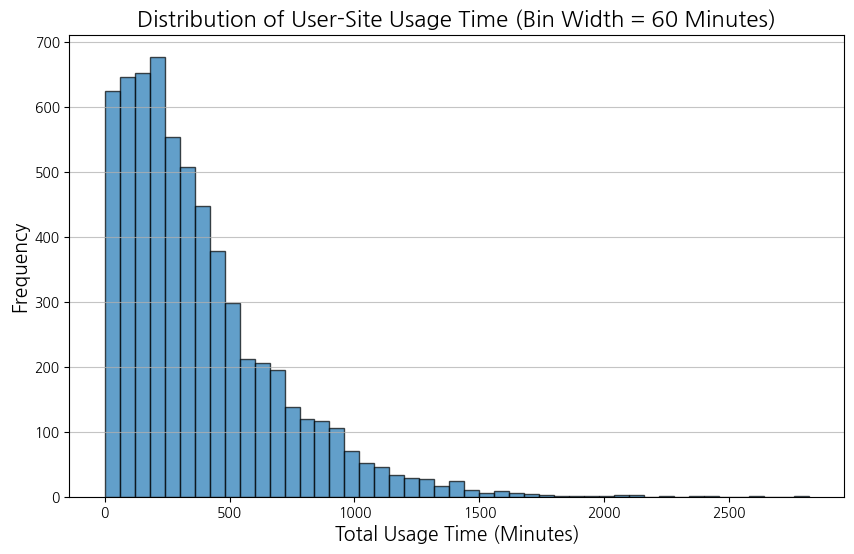

In [ ]:
display(user_site_usage['total_usage_time_minutes'].describe())
bin_width = 60
bins = range(0, int(user_site_usage['total_usage_time_minutes'].max()) + bin_width, bin_width)

plt.figure(figsize=(10, 6))
plt.hist(user_site_usage['total_usage_time_minutes'], bins=bins, edgecolor='k', alpha=0.7)
plt.title('Distribution of User-Site Usage Time (Bin Width = 60 Minutes)', fontsize=16)
plt.xlabel('Total Usage Time (Minutes)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', alpha=0.75)
plt.show()

구간을 60분으로 고정한 히스토그램에서 가장 빈도가 높은 구간은 180~240분이다. 입퇴실 기록이 한정적인 사람에게는 180분을 부여할 것이다.

In [ ]:
# 입실 기록만 있는 유저와 퇴실 기록만 있는 유저 찾기
users_only_checkin_dict = {row['site_id']: set(row['users_only_checkin']) for _, row in only_checkin_df.iterrows()}
users_only_checkout_dict = {row['site_id']: set(row['users_only_checkout']) for _, row in only_checkout_df.iterrows()}

# 기존 데이터에 total_usage_time_minutes를 180으로 고정하는 로직 추가
adjusted_usage = user_site_usage.copy()

for index, row in access_log_error_out.iterrows():
    user_id = row['user_uuid']
    site_id = row['site_id']
    
    # 입실 기록만 있는 경우
    if user_id in users_only_checkin_dict.get(site_id, set()):
        adjusted_usage = pd.concat([adjusted_usage, pd.DataFrame({
            'user_uuid': [user_id],
            'site_id': [site_id],
            'total_usage_time_minutes': [180]
        })], ignore_index=True)
    
    # 퇴실 기록만 있는 경우
    if user_id in users_only_checkout_dict.get(site_id, set()):
        adjusted_usage = pd.concat([adjusted_usage, pd.DataFrame({
            'user_uuid': [user_id],
            'site_id': [site_id],
            'total_usage_time_minutes': [180]
        })], ignore_index=True)

# 중복 제거 및 정렬
adjusted_usage = adjusted_usage.drop_duplicates(subset=['user_uuid', 'site_id']).reset_index(drop=True)
adjusted_usage

,user_uuid,site_id,total_usage_time_minutes
0,000590dc-046f-462b-8225-4c81a97b7166,6,356.964422
1,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,3,326.759592
2,0018e22d-a2cc-4e06-bca2-d6a041770f3b,6,1256.427416
3,002606d9-38ca-48f3-910c-cbfada9a9109,17,417.074040
4,002a7570-90dd-4cab-b0aa-b0e40f7ef27a,5,312.037673
...,...,...,...
6263,da581a7a-8cbb-4cf8-abe9-eb49e9bf302e,2,180.000000
6264,f0aa75c7-a7ea-4e95-9d81-077141bdb808,4,180.000000
6265,f13f2d28-d280-4fe9-8ed0-dd4f5d1ca33a,1,180.000000
6266,f3e6047f-f103-4003-9cc4-2ef89010d9f5,3,180.000000


In [ ]:
max_usage_per_user = adjusted_usage.loc[
    adjusted_usage.groupby('user_uuid')['total_usage_time_minutes'].idxmax()
]
max_usage_per_user

,user_uuid,site_id,total_usage_time_minutes
0,000590dc-046f-462b-8225-4c81a97b7166,6,356.964422
1,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,3,326.759592
2,0018e22d-a2cc-4e06-bca2-d6a041770f3b,6,1256.427416
3,002606d9-38ca-48f3-910c-cbfada9a9109,17,417.074040
4,002a7570-90dd-4cab-b0aa-b0e40f7ef27a,5,312.037673
...,...,...,...
6220,ffc79669-ed11-4cde-86d4-8ec232ac7b14,1,239.004308
6221,ffcb7950-d150-40ae-a6bf-f85f5c2b9702,2,493.576397
6222,ffce32ca-2efc-4485-b685-4b65811c2dcf,4,140.839831
6223,ffd287bc-2797-4788-82fa-6268c82e7fa9,6,556.268471


In [ ]:
# site_id 불문 총 이용 시간
total_time = adjusted_usage.groupby('user_uuid')['total_usage_time_minutes'].sum().reset_index(name = '총 이용 시간')
total_time

,user_uuid,총 이용 시간
0,000590dc-046f-462b-8225-4c81a97b7166,356.964422
1,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,326.759592
2,0018e22d-a2cc-4e06-bca2-d6a041770f3b,1256.427416
3,002606d9-38ca-48f3-910c-cbfada9a9109,417.074040
4,002a7570-90dd-4cab-b0aa-b0e40f7ef27a,312.037673
...,...,...
6020,ffc79669-ed11-4cde-86d4-8ec232ac7b14,239.004308
6021,ffcb7950-d150-40ae-a6bf-f85f5c2b9702,493.576397
6022,ffce32ca-2efc-4485-b685-4b65811c2dcf,140.839831
6023,ffd287bc-2797-4788-82fa-6268c82e7fa9,556.268471


### 이용 지점 수

In [ ]:
site_count = access_log_error_out.groupby('user_uuid')['site_id'].nunique().reset_index(name='이용 지점 수').sort_values(by = '이용 지점 수', ascending = False)
site_count

,user_uuid,이용 지점 수
1436,3b371ed1-3ef5-450d-ba29-b4e71fdc1bc4,4
3677,9ae30b10-8729-44f7-8f27-ed94f292c2b1,4
2335,6149dd69-31d7-43b8-9a31-92fff29bebc3,3
3545,953a48a9-1292-4353-ad72-5c99dd47ae28,3
4067,ab13af14-43b8-4ecc-a9ca-6e2bf3c28c87,3
...,...,...
2036,5490c3ae-c753-4afd-9078-a38d27b7af3b,1
2035,547d3965-a39f-4da4-9440-07b6e66704ae,1
2034,547c95a5-23a6-4d4b-aba3-16b7a3c0d41d,1
2033,5455a3ba-31a7-4e5f-987a-698826247221,1


<Axes: xlabel='이용 지점 수', ylabel='count'>

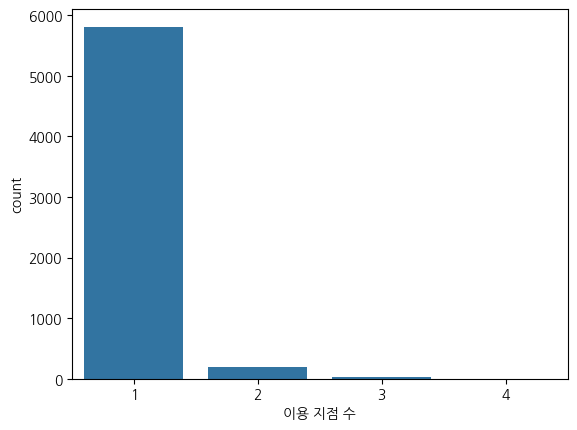

In [ ]:
sns.countplot(data = site_count, x = '이용 지점 수')

## 결합

1) 출처가 같은 데이터끼리 병합
2) register와 병합

In [ ]:
# 출처가 같은 데이터끼리 병합 (access_log)
from_access_log = pd.merge(entry_exit_df, mean_enter_times, how='left', on = 'user_uuid')
from_access_log = pd.merge(from_access_log, max_usage_per_user, how='left', on = 'user_uuid')
from_access_log = pd.merge(from_access_log, total_time, how='left', on = 'user_uuid')
from_access_log = pd.merge(from_access_log, site_count, how='left', on = 'user_uuid')
from_access_log

,user_uuid,entry_hours,exit_hours,출근시간대,퇴근시간대,평균_입(퇴)실횟수,site_id,total_usage_time_minutes,총 이용 시간,이용 지점 수
0,000590dc-046f-462b-8225-4c81a97b7166,"[2, 4, 7]","[4, 7, 8]",심야,오전,3.0,6.0,356.964422,356.964422,1
1,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,"[7, 7, 7, 8, 9, 10, 11, 10, 12]","[7, 7, 8, 8, 10, 11, 11, 12, 13]",오전,오전,4.5,3.0,326.759592,326.759592,1
2,0018e22d-a2cc-4e06-bca2-d6a041770f3b,"[0, 4, 5, 5, 5, 10, 10, 0, 9, 9, 9]","[4, 5, 5, 10, 10, 12, 9, 9]",심야,오전,5.5,6.0,1256.427416,1256.427416,1
3,002606d9-38ca-48f3-910c-cbfada9a9109,"[8, 10, 6, 9]","[10, 11, 9, 10]",오전,오전,2.0,17.0,417.074040,417.074040,1
4,002a7570-90dd-4cab-b0aa-b0e40f7ef27a,"[7, 9, 11, 11, 13]","[9, 11, 11, 12, 13]",오전,오전,5.0,5.0,312.037673,312.037673,1
...,...,...,...,...,...,...,...,...,...,...
6021,ffc79669-ed11-4cde-86d4-8ec232ac7b14,"[9, 11, 12, 13, 14]","[11, 12, 13, 14]",오전,오후,5.0,1.0,239.004308,239.004308,1
6022,ffcb7950-d150-40ae-a6bf-f85f5c2b9702,"[4, 6, 5, 5, 9]","[6, 9, 5, 9, 9]",심야,오전,2.5,2.0,493.576397,493.576397,1
6023,ffce32ca-2efc-4485-b685-4b65811c2dcf,"[15, 3]","[17, 3]",오후,심야,1.0,4.0,140.839831,140.839831,1
6024,ffd287bc-2797-4788-82fa-6268c82e7fa9,"[6, 6, 8, 9, 6, 7, 8, 9, 10, 12]","[6, 8, 9, 9, 7, 8, 9, 10, 12, 13]",심야,오전,5.0,6.0,556.268471,556.268471,1


In [ ]:
# register, payment와 합체
full_data = pd.merge(register, from_access_log, how='left', on = 'user_uuid')
full_data['방문 여부'] = (full_data['이용 지점 수'].isnull() == 0).astype(int)
full_data = pd.merge(full_data, payment, how = 'left', on = 'user_uuid')
full_data.drop('date',axis=1,inplace=True)
full_data.rename(columns={'YM':'trial_YM'},inplace=True)
full_data

,trial_date,user_uuid,trial_YM,entry_hours,exit_hours,출근시간대,퇴근시간대,평균_입(퇴)실횟수,site_id,total_usage_time_minutes,총 이용 시간,이용 지점 수,방문 여부,is_payment
0,2021-05-01,badbde4d-886b-4992-a8e3-fd0c05640183,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
1,2021-05-01,9f5e2bd3-65c9-4800-84c1-f5c93f44d096,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
2,2021-05-01,844319ff-cd15-4633-9900-6eaf4dc68b68,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
3,2021-05-01,f25078d1-1030-485c-85c5-dc82d6987043,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
4,2021-05-01,fce967b5-070c-46ed-a5fa-ef7d298cc7aa,2021-05,[5],[7],심야,심야,1.0,1.0,142.344708,142.344708,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9619,2023-12-30,e9b1a5df-d70c-4ccf-af22-64fdae98d3a2,2023-12,"[5, 5, 6, 7, 8, 6, 8, 9, 9, 5, 5, 6]","[5, 6, 7, 8, 8, 8, 9, 9, 9, 5, 6, 9]",심야,오전,4.0,4.0,648.874016,648.874016,1.0,1,0
9620,2023-12-30,aa4773c8-dbc9-4c80-849b-1ab8d1db7bda,2023-12,"[6, 8, 8]","[8, 8, 9]",심야,오전,3.0,3.0,197.187593,197.187593,1.0,1,0
9621,2023-12-31,acf3e288-4487-492b-9477-df149fb72e83,2023-12,"[2, 4, 6, 9, 3, 6]","[3, 5, 9, 9, 6, 7]",심야,심야,3.0,6.0,639.034304,639.034304,1.0,1,0
9622,2023-12-31,0e58ea5a-ebe4-48cb-b31b-d02a4f350cf8,2023-12,"[6, 6, 7, 6, 7, 9, 11, 14]","[6, 7, 9, 7, 9, 10, 13, 14]",심야,오후,4.0,3.0,642.043116,642.043116,1.0,1,1


# 분석 데이터 확인

In [ ]:
cross_tab = pd.crosstab(full_data['방문 여부'], full_data['is_payment'])
cross_tab

is_payment,0,1
방문 여부,,
0,2283,1315
1,3689,2337


방문을 하지 않았는데 결제한 사람이 1088명이나 된다.

처음에 어플 없이 이용했을 가능성까지 고려해 어플 사용 여부를 추가

In [ ]:
full_data['어플 사용'] = (full_data['평균_입(퇴)실횟수'].isnull()== 0).astype(int)
full_data

,trial_date,user_uuid,trial_YM,entry_hours,exit_hours,출근시간대,퇴근시간대,평균_입(퇴)실횟수,site_id,total_usage_time_minutes,총 이용 시간,이용 지점 수,방문 여부,is_payment,어플 사용
0,2021-05-01,badbde4d-886b-4992-a8e3-fd0c05640183,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
1,2021-05-01,9f5e2bd3-65c9-4800-84c1-f5c93f44d096,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
2,2021-05-01,844319ff-cd15-4633-9900-6eaf4dc68b68,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
3,2021-05-01,f25078d1-1030-485c-85c5-dc82d6987043,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
4,2021-05-01,fce967b5-070c-46ed-a5fa-ef7d298cc7aa,2021-05,[5],[7],심야,심야,1.0,1.0,142.344708,142.344708,1.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9619,2023-12-30,e9b1a5df-d70c-4ccf-af22-64fdae98d3a2,2023-12,"[5, 5, 6, 7, 8, 6, 8, 9, 9, 5, 5, 6]","[5, 6, 7, 8, 8, 8, 9, 9, 9, 5, 6, 9]",심야,오전,4.0,4.0,648.874016,648.874016,1.0,1,0,1
9620,2023-12-30,aa4773c8-dbc9-4c80-849b-1ab8d1db7bda,2023-12,"[6, 8, 8]","[8, 8, 9]",심야,오전,3.0,3.0,197.187593,197.187593,1.0,1,0,1
9621,2023-12-31,acf3e288-4487-492b-9477-df149fb72e83,2023-12,"[2, 4, 6, 9, 3, 6]","[3, 5, 9, 9, 6, 7]",심야,심야,3.0,6.0,639.034304,639.034304,1.0,1,0,1
9622,2023-12-31,0e58ea5a-ebe4-48cb-b31b-d02a4f350cf8,2023-12,"[6, 6, 7, 6, 7, 9, 11, 14]","[6, 7, 9, 7, 9, 10, 13, 14]",심야,오후,4.0,3.0,642.043116,642.043116,1.0,1,1,1


In [ ]:
full_data['이용 지점 수'] = full_data['이용 지점 수'].fillna(0)
full_data['이용 지점 수'] = full_data['이용 지점 수'].astype(int)
full_data

,trial_date,user_uuid,trial_YM,entry_hours,exit_hours,출근시간대,퇴근시간대,평균_입(퇴)실횟수,site_id,total_usage_time_minutes,총 이용 시간,이용 지점 수,방문 여부,is_payment,어플 사용
0,2021-05-01,badbde4d-886b-4992-a8e3-fd0c05640183,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0
1,2021-05-01,9f5e2bd3-65c9-4800-84c1-f5c93f44d096,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0
2,2021-05-01,844319ff-cd15-4633-9900-6eaf4dc68b68,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0
3,2021-05-01,f25078d1-1030-485c-85c5-dc82d6987043,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0
4,2021-05-01,fce967b5-070c-46ed-a5fa-ef7d298cc7aa,2021-05,[5],[7],심야,심야,1.0,1.0,142.344708,142.344708,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9619,2023-12-30,e9b1a5df-d70c-4ccf-af22-64fdae98d3a2,2023-12,"[5, 5, 6, 7, 8, 6, 8, 9, 9, 5, 5, 6]","[5, 6, 7, 8, 8, 8, 9, 9, 9, 5, 6, 9]",심야,오전,4.0,4.0,648.874016,648.874016,1,1,0,1
9620,2023-12-30,aa4773c8-dbc9-4c80-849b-1ab8d1db7bda,2023-12,"[6, 8, 8]","[8, 8, 9]",심야,오전,3.0,3.0,197.187593,197.187593,1,1,0,1
9621,2023-12-31,acf3e288-4487-492b-9477-df149fb72e83,2023-12,"[2, 4, 6, 9, 3, 6]","[3, 5, 9, 9, 6, 7]",심야,심야,3.0,6.0,639.034304,639.034304,1,1,0,1
9622,2023-12-31,0e58ea5a-ebe4-48cb-b31b-d02a4f350cf8,2023-12,"[6, 6, 7, 6, 7, 9, 11, 14]","[6, 7, 9, 7, 9, 10, 13, 14]",심야,오후,4.0,3.0,642.043116,642.043116,1,1,1,1


In [ ]:
full_data['총 이용 시간'] = full_data['총 이용 시간'].fillna(0)
full_data

,trial_date,user_uuid,trial_YM,entry_hours,exit_hours,출근시간대,퇴근시간대,평균_입(퇴)실횟수,site_id,total_usage_time_minutes,총 이용 시간,이용 지점 수,방문 여부,is_payment,어플 사용
0,2021-05-01,badbde4d-886b-4992-a8e3-fd0c05640183,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,0,1,0
1,2021-05-01,9f5e2bd3-65c9-4800-84c1-f5c93f44d096,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,0,1,0
2,2021-05-01,844319ff-cd15-4633-9900-6eaf4dc68b68,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,0,1,0
3,2021-05-01,f25078d1-1030-485c-85c5-dc82d6987043,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,0,1,0
4,2021-05-01,fce967b5-070c-46ed-a5fa-ef7d298cc7aa,2021-05,[5],[7],심야,심야,1.0,1.0,142.344708,142.344708,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9619,2023-12-30,e9b1a5df-d70c-4ccf-af22-64fdae98d3a2,2023-12,"[5, 5, 6, 7, 8, 6, 8, 9, 9, 5, 5, 6]","[5, 6, 7, 8, 8, 8, 9, 9, 9, 5, 6, 9]",심야,오전,4.0,4.0,648.874016,648.874016,1,1,0,1
9620,2023-12-30,aa4773c8-dbc9-4c80-849b-1ab8d1db7bda,2023-12,"[6, 8, 8]","[8, 8, 9]",심야,오전,3.0,3.0,197.187593,197.187593,1,1,0,1
9621,2023-12-31,acf3e288-4487-492b-9477-df149fb72e83,2023-12,"[2, 4, 6, 9, 3, 6]","[3, 5, 9, 9, 6, 7]",심야,심야,3.0,6.0,639.034304,639.034304,1,1,0,1
9622,2023-12-31,0e58ea5a-ebe4-48cb-b31b-d02a4f350cf8,2023-12,"[6, 6, 7, 6, 7, 9, 11, 14]","[6, 7, 9, 7, 9, 10, 13, 14]",심야,오후,4.0,3.0,642.043116,642.043116,1,1,1,1


In [ ]:
columns = [col for col in full_data.columns if col != 'is_payment'] + ['is_payment']
full_data = full_data[columns]

In [ ]:
full_data

,trial_date,user_uuid,trial_YM,entry_hours,exit_hours,출근시간대,퇴근시간대,평균_입(퇴)실횟수,site_id,total_usage_time_minutes,총 이용 시간,이용 지점 수,방문 여부,어플 사용,is_payment
0,2021-05-01,badbde4d-886b-4992-a8e3-fd0c05640183,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,0,0,1
1,2021-05-01,9f5e2bd3-65c9-4800-84c1-f5c93f44d096,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,0,0,1
2,2021-05-01,844319ff-cd15-4633-9900-6eaf4dc68b68,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,0,0,1
3,2021-05-01,f25078d1-1030-485c-85c5-dc82d6987043,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,0,0,1
4,2021-05-01,fce967b5-070c-46ed-a5fa-ef7d298cc7aa,2021-05,[5],[7],심야,심야,1.0,1.0,142.344708,142.344708,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9619,2023-12-30,e9b1a5df-d70c-4ccf-af22-64fdae98d3a2,2023-12,"[5, 5, 6, 7, 8, 6, 8, 9, 9, 5, 5, 6]","[5, 6, 7, 8, 8, 8, 9, 9, 9, 5, 6, 9]",심야,오전,4.0,4.0,648.874016,648.874016,1,1,1,0
9620,2023-12-30,aa4773c8-dbc9-4c80-849b-1ab8d1db7bda,2023-12,"[6, 8, 8]","[8, 8, 9]",심야,오전,3.0,3.0,197.187593,197.187593,1,1,1,0
9621,2023-12-31,acf3e288-4487-492b-9477-df149fb72e83,2023-12,"[2, 4, 6, 9, 3, 6]","[3, 5, 9, 9, 6, 7]",심야,심야,3.0,6.0,639.034304,639.034304,1,1,1,0
9622,2023-12-31,0e58ea5a-ebe4-48cb-b31b-d02a4f350cf8,2023-12,"[6, 6, 7, 6, 7, 9, 11, 14]","[6, 7, 9, 7, 9, 10, 13, 14]",심야,오후,4.0,3.0,642.043116,642.043116,1,1,1,1


In [ ]:
full_data.loc[full_data['user_uuid'] == '699c70ca-64ea-461e-bdd8-66b7c314c582','site_id'] = 5
full_data.loc[full_data['user_uuid'] == '699c70ca-64ea-461e-bdd8-66b7c314c582','total_usage_time_minutes'] = 180
full_data.loc[full_data['user_uuid'] == '699c70ca-64ea-461e-bdd8-66b7c314c582','총 이용 시간'] = 180
full_data[full_data['user_uuid'] == '699c70ca-64ea-461e-bdd8-66b7c314c582']

,trial_date,user_uuid,trial_YM,entry_hours,exit_hours,출근시간대,퇴근시간대,평균_입(퇴)실횟수,site_id,total_usage_time_minutes,총 이용 시간,이용 지점 수,방문 여부,어플 사용,is_payment
3701,2022-03-24,699c70ca-64ea-461e-bdd8-66b7c314c582,2022-03,"[7, 8]",[7],오전,심야,2.0,5.0,180.0,180.0,1,1,1,0


In [ ]:
full_data[full_data['방문 여부'] != full_data['어플 사용']]

,trial_date,user_uuid,trial_YM,entry_hours,exit_hours,출근시간대,퇴근시간대,평균_입(퇴)실횟수,site_id,total_usage_time_minutes,총 이용 시간,이용 지점 수,방문 여부,어플 사용,is_payment


In [ ]:
cross_tab = pd.crosstab(full_data['방문 여부'], full_data['is_payment'])
cross_tab

is_payment,0,1
방문 여부,,
0,2283,1315
1,3689,2337


In [ ]:
cross_tab = pd.crosstab(full_data['어플 사용'], full_data['is_payment'])
cross_tab

is_payment,0,1
어플 사용,,
0,2283,1315
1,3689,2337


모든 데이터셋을 모아놓은 full_data(데이터마트) 구성 완료.
이제 남은 것은 외부 데이터를 취합하고 분석을 위한 데이터셋으로 바꾸기

In [ ]:
full_data[full_data['site_id'] == 49]['is_payment'].mean()

0.41732283464566927

# 외부 데이터 결합

In [ ]:
site_update = pd.read_csv('external\site_area_update.csv', encoding = 'CP949')
site_update

<>:1: SyntaxWarning:

invalid escape sequence '\s'

<>:1: SyntaxWarning:

invalid escape sequence '\s'

C:\Users\csh94\AppData\Local\Temp\ipykernel_35808\2751177197.py:1: SyntaxWarning:

invalid escape sequence '\s'



,site_id,area_pyeong,floor_num,floor_lowest,floor_highest,장소,지하철 역 거리,역명,평균승객,반경 100m 내 버스 정류장 수,400M 내 아파트 수,카페 수,스터디 카페,공유 오피스
0,1,50,1,1,1,정동본점,155.5m,시청역,40019.2,3.0,0.0,15.0,0.0,1.0
1,2,100,1,2,2,서울대 입구,200m,서울대 입구,84609.8,0.0,15.0,12.0,11.0,0.0
2,3,150,2,3,4,석촌점,266.51m,석촌역,15033.9,1.0,5.0,10.0,9.0,1.0
3,4,100,1,3,3,일산,473.67m,정발산,14011.7,1.0,1.0,7.0,2.0,3.0
4,5,150,1,1,1,목동,463.65m,오목교,39912.2,2.0,13.0,11.0,7.0,0.0
5,6,150,2,-1,1,왕십리,183.36m,왕십리,21839.4,2.0,9.0,8.0,0.0,1.0
6,17,50,1,1,1,공덕,200.93m,공덕,16720.6,1.0,9.0,6.0,0.0,2.0
7,47,50,1,-1,-1,분당,468.03m,수내,23791.1,2.0,1.0,7.0,0.0,0.0
8,49,50,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,50,50,1,2,2,영등포,200m,영등포시장,18851.0,1.0,9.0,3.0,1.0,2.0


In [ ]:
full_data_with_geo = pd.merge(full_data, site_update, how='left',on='site_id')
full_data_with_geo['지하철 역 거리'] = full_data_with_geo['지하철 역 거리'].str.replace('m','',regex=True)
full_data_with_geo['지하철 역 거리'] = full_data_with_geo['지하철 역 거리'].astype('float64')
full_data_with_geo

,trial_date,user_uuid,trial_YM,entry_hours,exit_hours,출근시간대,퇴근시간대,평균_입(퇴)실횟수,site_id,total_usage_time_minutes,...,floor_highest,장소,지하철 역 거리,역명,평균승객,반경 100m 내 버스 정류장 수,400M 내 아파트 수,카페 수,스터디 카페,공유 오피스
0,2021-05-01,badbde4d-886b-4992-a8e3-fd0c05640183,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-05-01,9f5e2bd3-65c9-4800-84c1-f5c93f44d096,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-05-01,844319ff-cd15-4633-9900-6eaf4dc68b68,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-05-01,f25078d1-1030-485c-85c5-dc82d6987043,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-05-01,fce967b5-070c-46ed-a5fa-ef7d298cc7aa,2021-05,[5],[7],심야,심야,1.0,1.0,142.344708,...,1.0,정동본점,155.50,시청역,40019.2,3.0,0.0,15.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9619,2023-12-30,e9b1a5df-d70c-4ccf-af22-64fdae98d3a2,2023-12,"[5, 5, 6, 7, 8, 6, 8, 9, 9, 5, 5, 6]","[5, 6, 7, 8, 8, 8, 9, 9, 9, 5, 6, 9]",심야,오전,4.0,4.0,648.874016,...,3.0,일산,473.67,정발산,14011.7,1.0,1.0,7.0,2.0,3.0
9620,2023-12-30,aa4773c8-dbc9-4c80-849b-1ab8d1db7bda,2023-12,"[6, 8, 8]","[8, 8, 9]",심야,오전,3.0,3.0,197.187593,...,4.0,석촌점,266.51,석촌역,15033.9,1.0,5.0,10.0,9.0,1.0
9621,2023-12-31,acf3e288-4487-492b-9477-df149fb72e83,2023-12,"[2, 4, 6, 9, 3, 6]","[3, 5, 9, 9, 6, 7]",심야,심야,3.0,6.0,639.034304,...,1.0,왕십리,183.36,왕십리,21839.4,2.0,9.0,8.0,0.0,1.0
9622,2023-12-31,0e58ea5a-ebe4-48cb-b31b-d02a4f350cf8,2023-12,"[6, 6, 7, 6, 7, 9, 11, 14]","[6, 7, 9, 7, 9, 10, 13, 14]",심야,오후,4.0,3.0,642.043116,...,4.0,석촌점,266.51,석촌역,15033.9,1.0,5.0,10.0,9.0,1.0


In [ ]:
social_economic_stat = pd.read_csv('external\data_external_time_series.csv')
social_economic_stat.drop('Unnamed: 0', axis=1,inplace=True)

social_economic_stat['확진자 집계 여부'] = (social_economic_stat['수도권 확진자수'].isnull() == 0).astype(int)
social_economic_stat

<>:1: SyntaxWarning:

invalid escape sequence '\d'

<>:1: SyntaxWarning:

invalid escape sequence '\d'

C:\Users\csh94\AppData\Local\Temp\ipykernel_35808\931943929.py:1: SyntaxWarning:

invalid escape sequence '\d'



,연-월,수도권 확진자수,거리두기 정책,광고 유무,소비자심리지수,경제성장률,기준금리,취업준비자,취업자,실업자,고용률,실업률,공채시즌 여부,확진자 집계 여부
0,2021-05,10961.0,2,0,105.5,4.3,0.50,890.0,27550.0,1148.0,66.9,4.0,1,1
1,2021-06,11050.0,2,0,110.8,4.3,0.50,857.0,27637.0,1093.0,67.1,3.8,0,1
2,2021-07,26083.0,3,0,103.6,4.3,0.50,877.0,27648.0,920.0,67.1,3.2,0,1
3,2021-08,30296.0,3,0,102.8,4.3,0.75,874.0,27603.0,774.0,66.9,2.6,0,1
4,2021-09,40171.0,3,0,104.1,4.3,0.75,862.0,27683.0,756.0,67.2,2.7,1,1
5,2021-10,37426.0,3,1,107.3,4.3,0.75,833.0,27741.0,788.0,67.3,2.8,1,1
6,2021-11,59672.0,1,0,108.2,4.3,1.00,789.0,27795.0,734.0,67.5,2.6,1,1
7,2021-12,123748.0,1,1,104.3,4.3,1.00,760.0,27298.0,979.0,67.3,3.5,0,1
8,2022-01,124689.0,1,1,104.9,2.6,1.25,780.0,26953.0,1143.0,67.0,4.1,0,1
9,2022-02,1179711.0,1,0,103.5,2.6,1.25,805.0,27402.0,954.0,67.4,3.4,0,1


In [ ]:
social_economic_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   연-월        32 non-null     object 
 1   수도권 확진자수   28 non-null     float64
 2   거리두기 정책    32 non-null     int64  
 3   광고 유무      32 non-null     int64  
 4   소비자심리지수    32 non-null     float64
 5   경제성장률      32 non-null     float64
 6   기준금리       32 non-null     float64
 7   취업준비자      32 non-null     float64
 8   취업자        32 non-null     float64
 9   실업자        32 non-null     float64
 10  고용률        32 non-null     float64
 11  실업률        32 non-null     float64
 12  공채시즌 여부    32 non-null     int64  
 13  확진자 집계 여부  32 non-null     int32  
dtypes: float64(9), int32(1), int64(3), object(1)
memory usage: 3.5+ KB


In [ ]:
social_economic_stat['연-월'] = pd.to_datetime(social_economic_stat['연-월'])
social_economic_stat['연-월'] = social_economic_stat['연-월'].dt.to_period('M')

In [ ]:
full_data_geo_ses = pd.merge(full_data_with_geo,social_economic_stat, how = 'left', left_on = 'trial_YM', right_on = '연-월')
full_data_geo_ses

,trial_date,user_uuid,trial_YM,entry_hours,exit_hours,출근시간대,퇴근시간대,평균_입(퇴)실횟수,site_id,total_usage_time_minutes,...,소비자심리지수,경제성장률,기준금리,취업준비자,취업자,실업자,고용률,실업률,공채시즌 여부,확진자 집계 여부
0,2021-05-01,badbde4d-886b-4992-a8e3-fd0c05640183,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,105.5,4.3,0.5,890.0,27550.0,1148.0,66.9,4.0,1,1
1,2021-05-01,9f5e2bd3-65c9-4800-84c1-f5c93f44d096,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,105.5,4.3,0.5,890.0,27550.0,1148.0,66.9,4.0,1,1
2,2021-05-01,844319ff-cd15-4633-9900-6eaf4dc68b68,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,105.5,4.3,0.5,890.0,27550.0,1148.0,66.9,4.0,1,1
3,2021-05-01,f25078d1-1030-485c-85c5-dc82d6987043,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,105.5,4.3,0.5,890.0,27550.0,1148.0,66.9,4.0,1,1
4,2021-05-01,fce967b5-070c-46ed-a5fa-ef7d298cc7aa,2021-05,[5],[7],심야,심야,1.0,1.0,142.344708,...,105.5,4.3,0.5,890.0,27550.0,1148.0,66.9,4.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9619,2023-12-30,e9b1a5df-d70c-4ccf-af22-64fdae98d3a2,2023-12,"[5, 5, 6, 7, 8, 6, 8, 9, 9, 5, 5, 6]","[5, 6, 7, 8, 8, 8, 9, 9, 9, 5, 6, 9]",심야,오전,4.0,4.0,648.874016,...,99.7,1.4,3.5,663.0,28093.0,944.0,69.2,3.3,0,0
9620,2023-12-30,aa4773c8-dbc9-4c80-849b-1ab8d1db7bda,2023-12,"[6, 8, 8]","[8, 8, 9]",심야,오전,3.0,3.0,197.187593,...,99.7,1.4,3.5,663.0,28093.0,944.0,69.2,3.3,0,0
9621,2023-12-31,acf3e288-4487-492b-9477-df149fb72e83,2023-12,"[2, 4, 6, 9, 3, 6]","[3, 5, 9, 9, 6, 7]",심야,심야,3.0,6.0,639.034304,...,99.7,1.4,3.5,663.0,28093.0,944.0,69.2,3.3,0,0
9622,2023-12-31,0e58ea5a-ebe4-48cb-b31b-d02a4f350cf8,2023-12,"[6, 6, 7, 6, 7, 9, 11, 14]","[6, 7, 9, 7, 9, 10, 13, 14]",심야,오후,4.0,3.0,642.043116,...,99.7,1.4,3.5,663.0,28093.0,944.0,69.2,3.3,0,0


In [ ]:
full_data[(full_data['site_id'].isnull()==1) &(full_data['이용 지점 수'] > 0)]

,trial_date,user_uuid,trial_YM,entry_hours,exit_hours,출근시간대,퇴근시간대,평균_입(퇴)실횟수,site_id,total_usage_time_minutes,총 이용 시간,이용 지점 수,방문 여부,어플 사용,is_payment


In [ ]:
access_log[access_log['user_uuid'] == '699c70ca-64ea-461e-bdd8-66b7c314c582']

,id,checkin,cdate,site_id,user_uuid,date
42836,557756,2,2022-03-25 07:57:20.208016,5,699c70ca-64ea-461e-bdd8-66b7c314c582,2022-03-25
42838,557758,1,2022-03-25 07:57:41.857816,5,699c70ca-64ea-461e-bdd8-66b7c314c582,2022-03-25
42837,557766,1,2022-03-25 08:00:15.972309,5,699c70ca-64ea-461e-bdd8-66b7c314c582,2022-03-25


In [ ]:
full_data_geo_ses.loc[full_data_geo_ses['user_uuid'] == '699c70ca-64ea-461e-bdd8-66b7c314c582','site_id'] = 5
full_data_geo_ses.loc[full_data_geo_ses['user_uuid'] == '699c70ca-64ea-461e-bdd8-66b7c314c582','total_usage_time_minutes'] = 180
full_data_geo_ses.loc[full_data_geo_ses['user_uuid'] == '699c70ca-64ea-461e-bdd8-66b7c314c582','총 이용 시간'] = 180
full_data_geo_ses[full_data_geo_ses['user_uuid'] == '699c70ca-64ea-461e-bdd8-66b7c314c582']

,trial_date,user_uuid,trial_YM,entry_hours,exit_hours,출근시간대,퇴근시간대,평균_입(퇴)실횟수,site_id,total_usage_time_minutes,...,소비자심리지수,경제성장률,기준금리,취업준비자,취업자,실업자,고용률,실업률,공채시즌 여부,확진자 집계 여부
3701,2022-03-24,699c70ca-64ea-461e-bdd8-66b7c314c582,2022-03,"[7, 8]",[7],오전,심야,2.0,5.0,180.0,...,103.7,2.6,1.25,781.0,27754.0,873.0,67.8,3.0,1,1


In [ ]:
columns = [col for col in full_data_geo_ses.columns if col != 'is_payment'] + ['is_payment']
full_data_geo_ses = full_data_geo_ses[columns]

In [ ]:
full_data_geo_ses.to_csv('full_data.csv',index=False)

# 데이터셋 불러오기

In [ ]:
full_data = pd.read_csv('full_data.csv')
full_data.head()

,trial_date,user_uuid,trial_YM,entry_hours,exit_hours,출근시간대,퇴근시간대,평균_입(퇴)실횟수,site_id,total_usage_time_minutes,...,경제성장률,기준금리,취업준비자,취업자,실업자,고용률,실업률,공채시즌 여부,확진자 집계 여부,is_payment
0,2021-05-01,badbde4d-886b-4992-a8e3-fd0c05640183,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.3,0.5,890.0,27550.0,1148.0,66.9,4.0,1,1,1
1,2021-05-01,9f5e2bd3-65c9-4800-84c1-f5c93f44d096,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.3,0.5,890.0,27550.0,1148.0,66.9,4.0,1,1,1
2,2021-05-01,844319ff-cd15-4633-9900-6eaf4dc68b68,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.3,0.5,890.0,27550.0,1148.0,66.9,4.0,1,1,1
3,2021-05-01,f25078d1-1030-485c-85c5-dc82d6987043,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.3,0.5,890.0,27550.0,1148.0,66.9,4.0,1,1,1
4,2021-05-01,fce967b5-070c-46ed-a5fa-ef7d298cc7aa,2021-05,[5],[7],심야,심야,1.0,1.0,142.344708,...,4.3,0.5,890.0,27550.0,1148.0,66.9,4.0,1,1,1


In [ ]:
print(full_data.shape)
print(full_data.info())

(9624, 42)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9624 entries, 0 to 9623
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   trial_date                9624 non-null   object 
 1   user_uuid                 9624 non-null   object 
 2   trial_YM                  9624 non-null   object 
 3   entry_hours               6026 non-null   object 
 4   exit_hours                6026 non-null   object 
 5   출근시간대                     6010 non-null   object 
 6   퇴근시간대                     6002 non-null   object 
 7   평균_입(퇴)실횟수                6026 non-null   float64
 8   site_id                   6026 non-null   float64
 9   total_usage_time_minutes  6026 non-null   float64
 10  총 이용 시간                   9624 non-null   float64
 11  이용 지점 수                   9624 non-null   int64  
 12  방문 여부                     9624 non-null   int64  
 13  어플 사용                     9624 non-null   int64  
 1

In [ ]:
full_data.isnull().sum()

trial_date                     0
user_uuid                      0
trial_YM                       0
entry_hours                 3598
exit_hours                  3598
출근시간대                       3614
퇴근시간대                       3622
평균_입(퇴)실횟수                  3598
site_id                     3598
total_usage_time_minutes    3598
총 이용 시간                        0
이용 지점 수                        0
방문 여부                          0
어플 사용                          0
area_pyeong                 3598
floor_num                   3598
floor_lowest                3598
floor_highest               3598
장소                          3725
지하철 역 거리                    3725
역명                          3725
평균승객                        3725
반경 100m 내 버스 정류장 수          3725
400M 내 아파트 수                3725
카페 수                        3725
스터디 카페                      3725
공유 오피스                      3725
연-월                            0
수도권 확진자수                    1169
거리두기 정책                        0
광고 유무     

방문하지 않은 사람들때문에 null값이 많다. 빼자.

In [ ]:
visitors = full_data[full_data['방문 여부'] == 1]
visitors.isnull().sum()

trial_date                    0
user_uuid                     0
trial_YM                      0
entry_hours                   0
exit_hours                    0
출근시간대                        16
퇴근시간대                        24
평균_입(퇴)실횟수                    0
site_id                       0
total_usage_time_minutes      0
총 이용 시간                       0
이용 지점 수                       0
방문 여부                         0
어플 사용                         0
area_pyeong                   0
floor_num                     0
floor_lowest                  0
floor_highest                 0
장소                          127
지하철 역 거리                    127
역명                          127
평균승객                        127
반경 100m 내 버스 정류장 수          127
400M 내 아파트 수                127
카페 수                        127
스터디 카페                      127
공유 오피스                      127
연-월                           0
수도권 확진자수                    862
거리두기 정책                       0
광고 유무                         0
소비자심리지수 

그 다음 특수한 지점이라 너무 특색이 다른 제주도점을 가장 많이 이용한 사람들을 빼자.

In [ ]:
jeju = visitors['site_id'] == 49
metropolitan = visitors[~jeju]
print(metropolitan.shape)
print(metropolitan.isnull().sum())

(5899, 42)
trial_date                    0
user_uuid                     0
trial_YM                      0
entry_hours                   0
exit_hours                    0
출근시간대                        16
퇴근시간대                        24
평균_입(퇴)실횟수                    0
site_id                       0
total_usage_time_minutes      0
총 이용 시간                       0
이용 지점 수                       0
방문 여부                         0
어플 사용                         0
area_pyeong                   0
floor_num                     0
floor_lowest                  0
floor_highest                 0
장소                            0
지하철 역 거리                      0
역명                            0
평균승객                          0
반경 100m 내 버스 정류장 수            0
400M 내 아파트 수                  0
카페 수                          0
스터디 카페                        0
공유 오피스                        0
연-월                           0
수도권 확진자수                    791
거리두기 정책                       0
광고 유무                        

빈 출근시간대와 퇴근시간대는 랜덤포레스트를 통해 예측하기로 하고 EDA를 먼저 해보자.

In [ ]:
# 분석에 필요없는 변인 제거
metropolitan = metropolitan.drop(['user_uuid','entry_hours','exit_hours','방문 여부','어플 사용','연-월','장소','역명'], axis=1)

to_be_cat = ['site_id','거리두기 정책','광고 유무','공채시즌 여부','확진자 집계 여부','floor_num','floor_lowest','floor_highest']
metropolitan[to_be_cat] = metropolitan[to_be_cat].astype('object')

# trial_date와 trial_YM을 시간 데이터로 만들기
metropolitan['trial_date'] = pd.to_datetime(metropolitan['trial_date'])
metropolitan['trial_YM'] = metropolitan['trial_date'].dt.to_period('M')

# 연속형 범수, 범주형 변수 분리
var_num = metropolitan.select_dtypes('number')
var_cat = metropolitan.select_dtypes('object')


print(var_num.columns, len(var_num.columns),'개')
print(var_cat.columns, len(var_cat.columns),'개')

Index(['평균_입(퇴)실횟수', 'total_usage_time_minutes', '총 이용 시간', '이용 지점 수',
       'area_pyeong', '지하철 역 거리', '평균승객', '반경 100m 내 버스 정류장 수', '400M 내 아파트 수',
       '카페 수', '스터디 카페', '공유 오피스', '수도권 확진자수', '소비자심리지수', '경제성장률', '기준금리',
       '취업준비자', '취업자', '실업자', '고용률', '실업률', 'is_payment'],
      dtype='object') 22 개
Index(['출근시간대', '퇴근시간대', 'site_id', 'floor_num', 'floor_lowest',
       'floor_highest', '거리두기 정책', '광고 유무', '공채시즌 여부', '확진자 집계 여부'],
      dtype='object') 10 개


In [ ]:
# 범주 순서 정렬
order_시간대 = ['심야','오전','오후','야간']

# 다수의 범주형 변수에 대해 정렬
for col in ['출근시간대', '퇴근시간대']:
    metropolitan[col] = pd.Categorical(metropolitan[col], categories=order_시간대, ordered=True)

# 다수의 범주형 변수에 대해 정렬
for col in ['site_id','floor_num','floor_lowest','floor_highest','거리두기 정책','광고 유무','공채시즌 여부','확진자 집계 여부']:
    sorted_order = sorted(metropolitan[col].unique())
    metropolitan[col] = pd.Categorical(metropolitan[col], categories=sorted_order, ordered=True)



# 연속형 변수

In [ ]:
# 연속형 변수 살펴보기
var_num.describe()

,평균_입(퇴)실횟수,total_usage_time_minutes,총 이용 시간,이용 지점 수,area_pyeong,지하철 역 거리,평균승객,반경 100m 내 버스 정류장 수,400M 내 아파트 수,카페 수,...,수도권 확진자수,소비자심리지수,경제성장률,기준금리,취업준비자,취업자,실업자,고용률,실업률,is_payment
count,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,...,5.108000e+03,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000
mean,3.386633,384.055209,391.202200,1.040854,112.764875,264.598871,34478.311544,1.420919,7.436006,10.004916,...,5.532405e+05,99.163502,2.637973,2.231649,753.249025,28046.566367,834.493813,68.362044,2.898898,0.387184
std,2.287258,317.139704,321.552817,0.219881,41.286954,114.283887,24815.431154,0.918690,5.201282,2.649493,...,9.245721e+05,6.663806,1.149120,1.195458,72.469342,521.335618,146.640656,1.007043,0.536018,0.487148
min,1.000000,0.044042,0.044042,1.000000,50.000000,155.500000,14011.700000,0.000000,0.000000,6.000000,...,1.096100e+04,86.200000,1.400000,0.500000,660.000000,26953.000000,573.000000,66.900000,2.000000,0.000000
25%,2.000000,154.869407,156.593162,1.000000,100.000000,183.360000,15033.900000,1.000000,1.000000,8.000000,...,5.967200e+04,92.000000,1.400000,1.000000,679.000000,27648.000000,734.000000,67.300000,2.600000,0.000000
50%,3.000000,301.158353,307.910993,1.000000,150.000000,200.930000,21839.400000,1.000000,9.000000,10.000000,...,1.929940e+05,100.800000,2.600000,2.500000,760.000000,28078.000000,836.000000,68.500000,2.900000,0.000000
75%,4.500000,529.257508,543.041319,1.000000,150.000000,266.510000,40019.200000,2.000000,13.000000,12.000000,...,6.796550e+05,104.100000,4.300000,3.500000,798.000000,28478.000000,920.000000,69.200000,3.200000,1.000000
max,26.000000,2768.891786,2768.891786,4.000000,150.000000,473.670000,84609.800000,3.000000,15.000000,15.000000,...,4.679149e+06,110.800000,4.300000,3.500000,890.000000,28835.000000,1148.000000,69.900000,4.100000,1.000000


<Axes: >

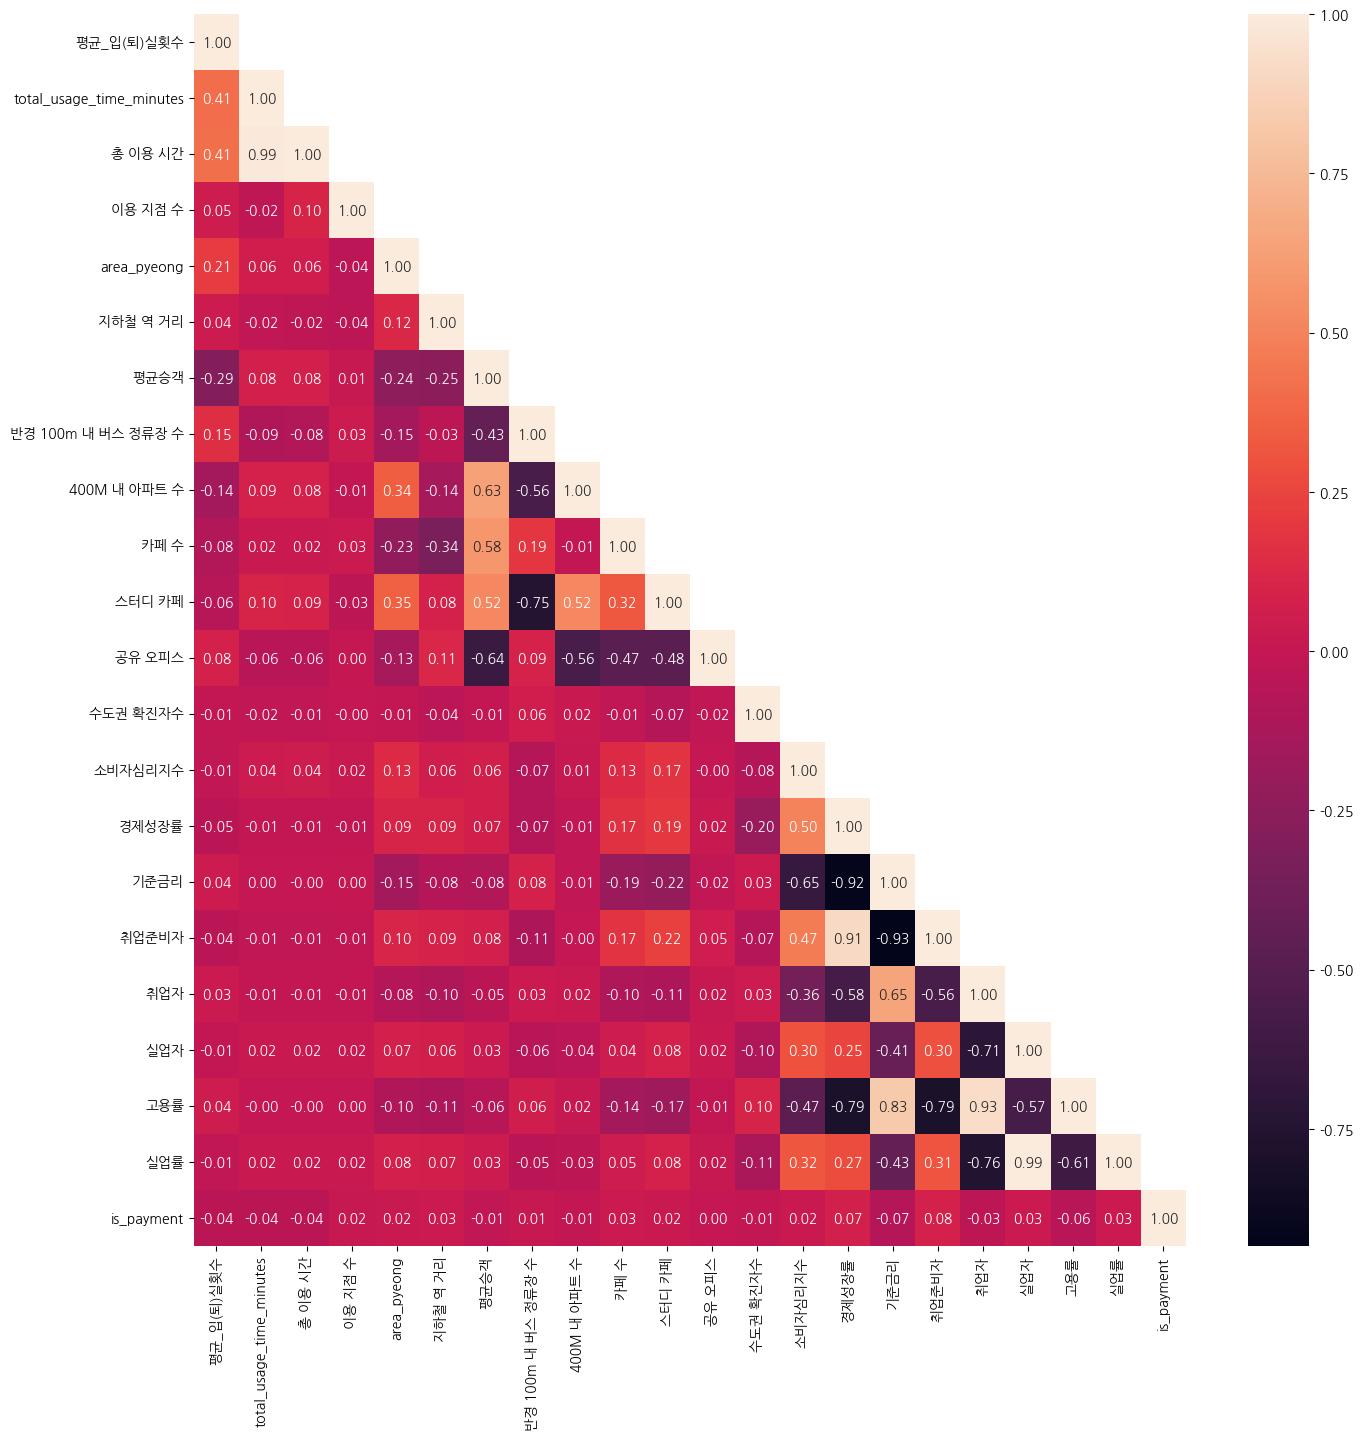

In [ ]:
cor_all = var_num.corr()
mask = np.array(cor_all)
mask[np.tril_indices_from(mask)] = False
plt.figure(figsize=(16,16))
sns.heatmap(data=cor_all, annot=True, mask = mask, fmt=".2f")

너무 많다. 얘도 좀 더 항목을 나눠서 살펴보자.

In [ ]:
# 유저 행동
user_behavior = ['평균_입(퇴)실횟수','total_usage_time_minutes','총 이용 시간','이용 지점 수']

# 주변 환경
nearby = ['지하철 역 거리','평균승객','반경 100m 내 버스 정류장 수','400M 내 아파트 수','카페 수', '스터디 카페', '공유 오피스']

# 사회 경제적 지표
ses = ['수도권 확진자수', '소비자심리지수', '경제성장률', '기준금리', '취업준비자', '취업자', '실업자', '고용률', '실업률']


## user_behavior

In [ ]:
metropolitan[user_behavior].describe()

,평균_입(퇴)실횟수,total_usage_time_minutes,총 이용 시간,이용 지점 수
count,5899.000000,5899.000000,5899.000000,5899.000000
mean,3.386633,384.055209,391.202200,1.040854
std,2.287258,317.139704,321.552817,0.219881
min,1.000000,0.044042,0.044042,1.000000
25%,2.000000,154.869407,156.593162,1.000000
50%,3.000000,301.158353,307.910993,1.000000
75%,4.500000,529.257508,543.041319,1.000000
max,26.000000,2768.891786,2768.891786,4.000000


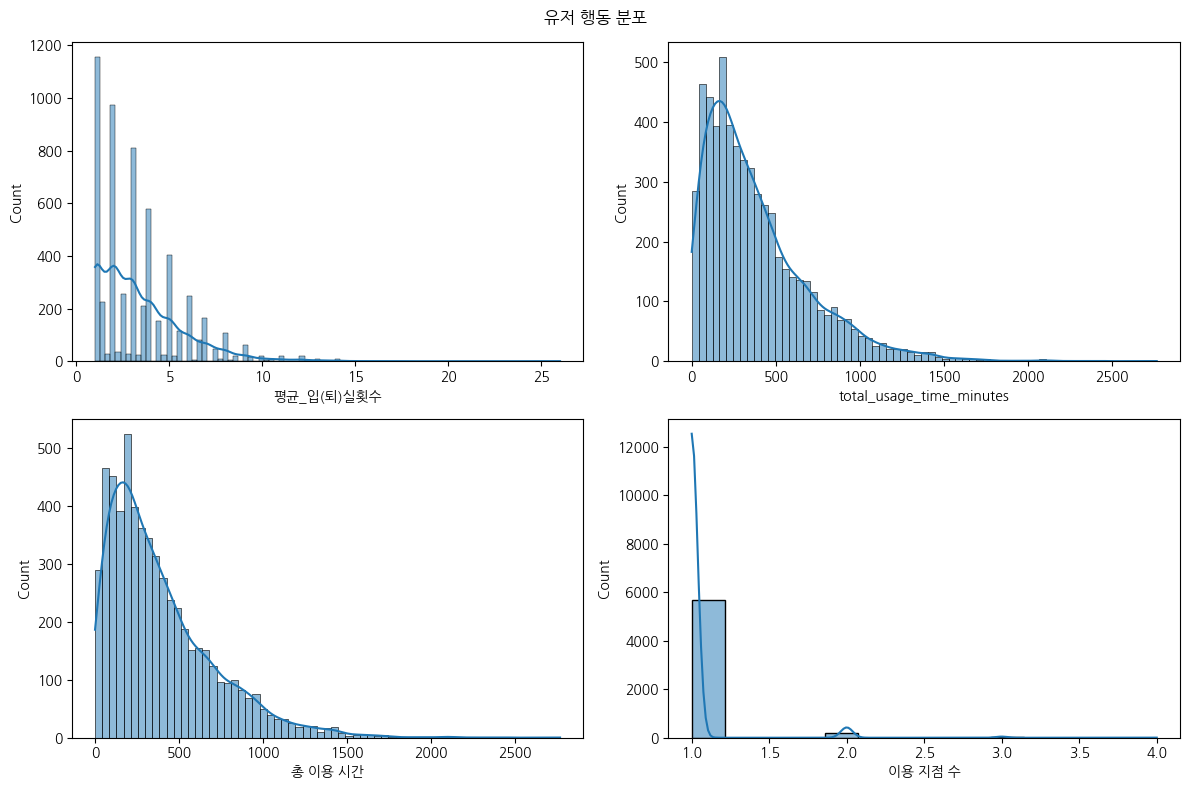

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(12,8))
axes = axes.flatten()
for i, col in enumerate(user_behavior):
    sns.histplot(data = metropolitan, x = col, kde=True, ax = axes[i])
fig.suptitle('유저 행동 분포')
plt.tight_layout()
plt.show()

<Axes: >

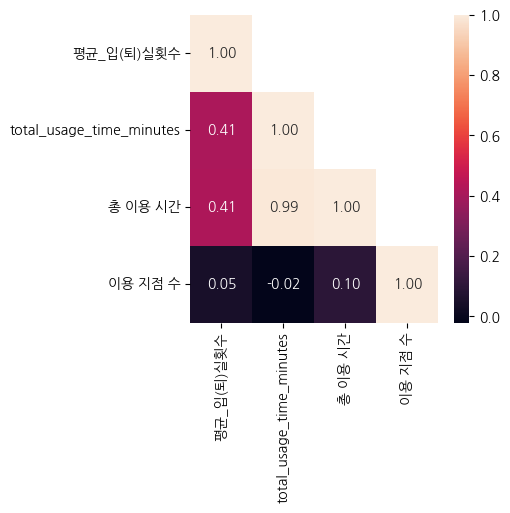

In [ ]:
cor = metropolitan[user_behavior].corr()
mask = np.array(cor)
mask[np.tril_indices_from(mask)] = False
plt.figure(figsize=(4,4))
sns.heatmap(data=cor, annot=True, mask = mask, fmt=".2f")

유저 행동과 관련된 변수들은 정적 편포를 보이고 있었다.<br>그리고 주요 이용 지점 이용시간과 총 이용 시간이 상관관계가 0.99로 거의 동일하다. 그러므로 이후 분석에서는 총 이용시간을 제거한다.

In [ ]:
user_behavior.remove('총 이용 시간')
user_behavior

['평균_입(퇴)실횟수', 'total_usage_time_minutes', '이용 지점 수']

## nearby

In [ ]:
metropolitan[nearby].describe()

,지하철 역 거리,평균승객,반경 100m 내 버스 정류장 수,400M 내 아파트 수,카페 수,스터디 카페,공유 오피스
count,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.00000,5899.000000
mean,264.598871,34478.311544,1.420919,7.436006,10.004916,4.59722,0.910154
std,114.283887,24815.431154,0.918690,5.201282,2.649493,4.65349,0.834203
min,155.500000,14011.700000,0.000000,0.000000,6.000000,0.00000,0.000000
25%,183.360000,15033.900000,1.000000,1.000000,8.000000,0.00000,0.000000
50%,200.930000,21839.400000,1.000000,9.000000,10.000000,2.00000,1.000000
75%,266.510000,40019.200000,2.000000,13.000000,12.000000,9.00000,1.000000
max,473.670000,84609.800000,3.000000,15.000000,15.000000,11.00000,3.000000


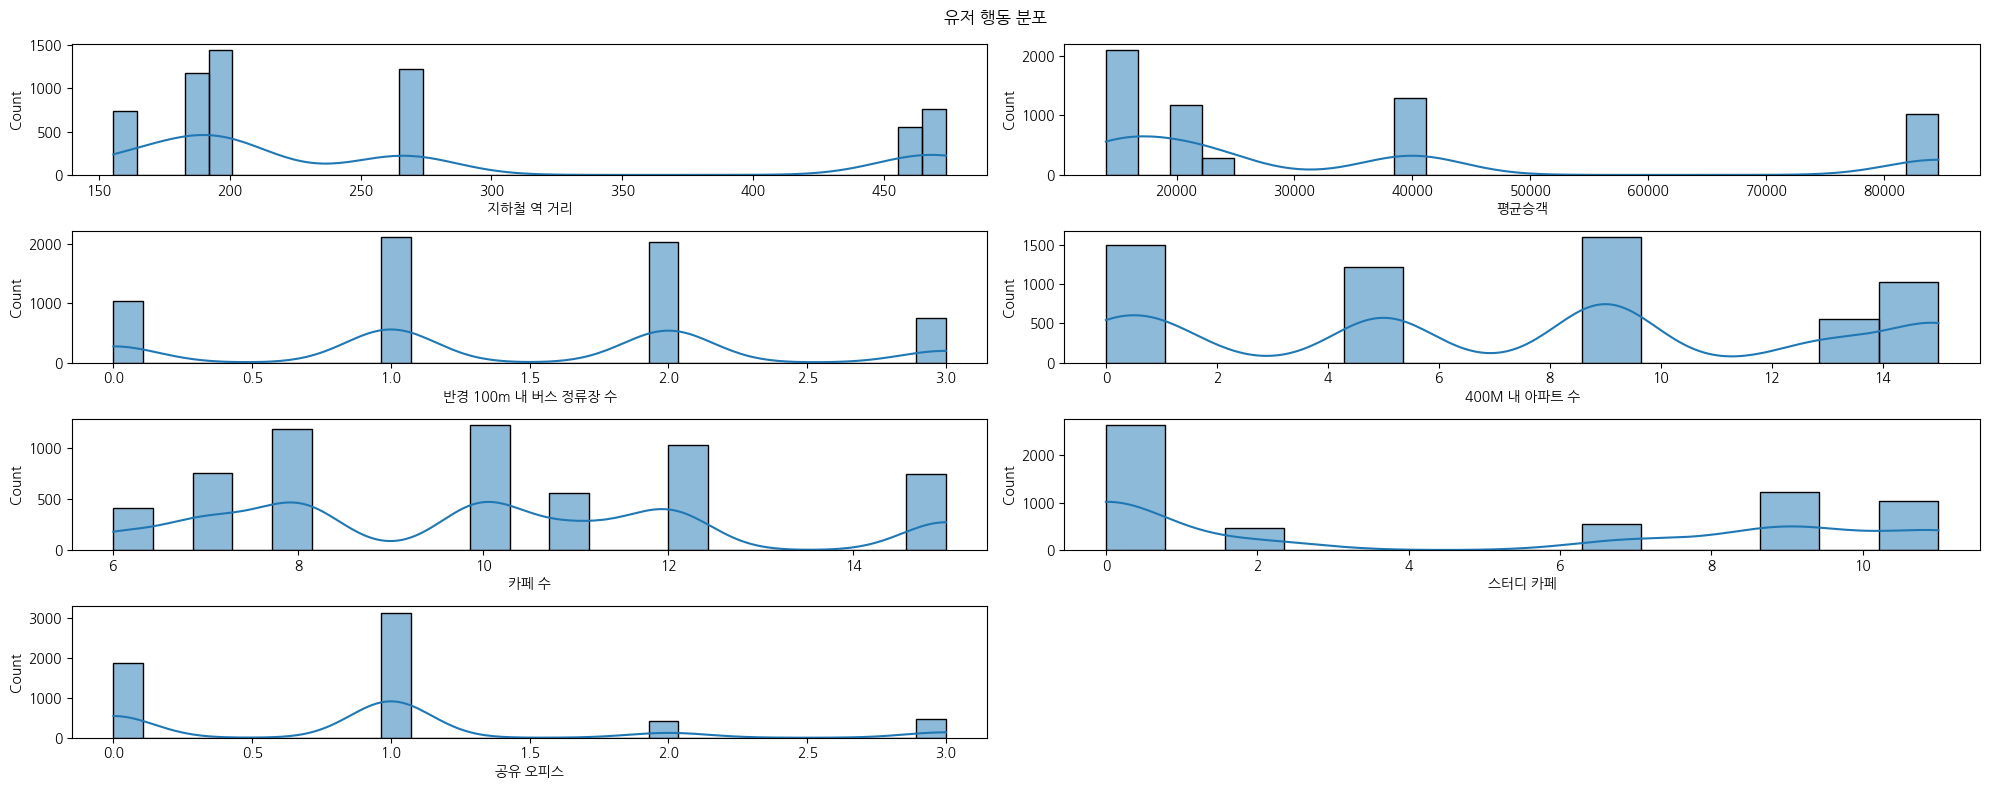

In [ ]:
fig, axes = plt.subplots(4,2, figsize=(20,8))
axes = axes.flatten()
for i, col in enumerate(nearby):
    sns.histplot(data = metropolitan, x = col, kde=True, ax = axes[i])
fig.suptitle('유저 행동 분포')

# 남은 빈 그래프 제거
for j in range(len(nearby), len(axes)):
    fig.delaxes(axes[j])  # 빈 축 삭제

plt.tight_layout()
plt.show()

<Axes: >

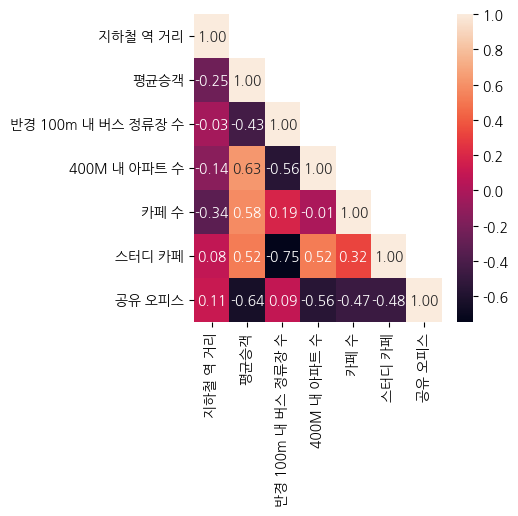

In [ ]:
cor = metropolitan[nearby].corr()
mask = np.array(cor)
mask[np.tril_indices_from(mask)] = False
plt.figure(figsize=(4,4))
sns.heatmap(data=cor, annot=True, mask = mask, fmt=".2f")

지점이 한정적이기 때문에 nearby에 해당하는 변인들의 담고 있는 정보 수가 많지 않다.<br>평균 승객이 다른 변인들과 대체로 높은 상관관계를 보여주었다.<br>특히, 주변 공유 오피스와 강한 부적 상관관계를 가지고 있는 것이 흥미롭다.<br>이 변수들을 범주화하는 것도 충분히 고려할 만하다.

## SES

In [ ]:
metropolitan[ses].describe()

,수도권 확진자수,소비자심리지수,경제성장률,기준금리,취업준비자,취업자,실업자,고용률,실업률
count,5.108000e+03,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000
mean,5.532405e+05,99.163502,2.637973,2.231649,753.249025,28046.566367,834.493813,68.362044,2.898898
std,9.245721e+05,6.663806,1.149120,1.195458,72.469342,521.335618,146.640656,1.007043,0.536018
min,1.096100e+04,86.200000,1.400000,0.500000,660.000000,26953.000000,573.000000,66.900000,2.000000
25%,5.967200e+04,92.000000,1.400000,1.000000,679.000000,27648.000000,734.000000,67.300000,2.600000
50%,1.929940e+05,100.800000,2.600000,2.500000,760.000000,28078.000000,836.000000,68.500000,2.900000
75%,6.796550e+05,104.100000,4.300000,3.500000,798.000000,28478.000000,920.000000,69.200000,3.200000
max,4.679149e+06,110.800000,4.300000,3.500000,890.000000,28835.000000,1148.000000,69.900000,4.100000


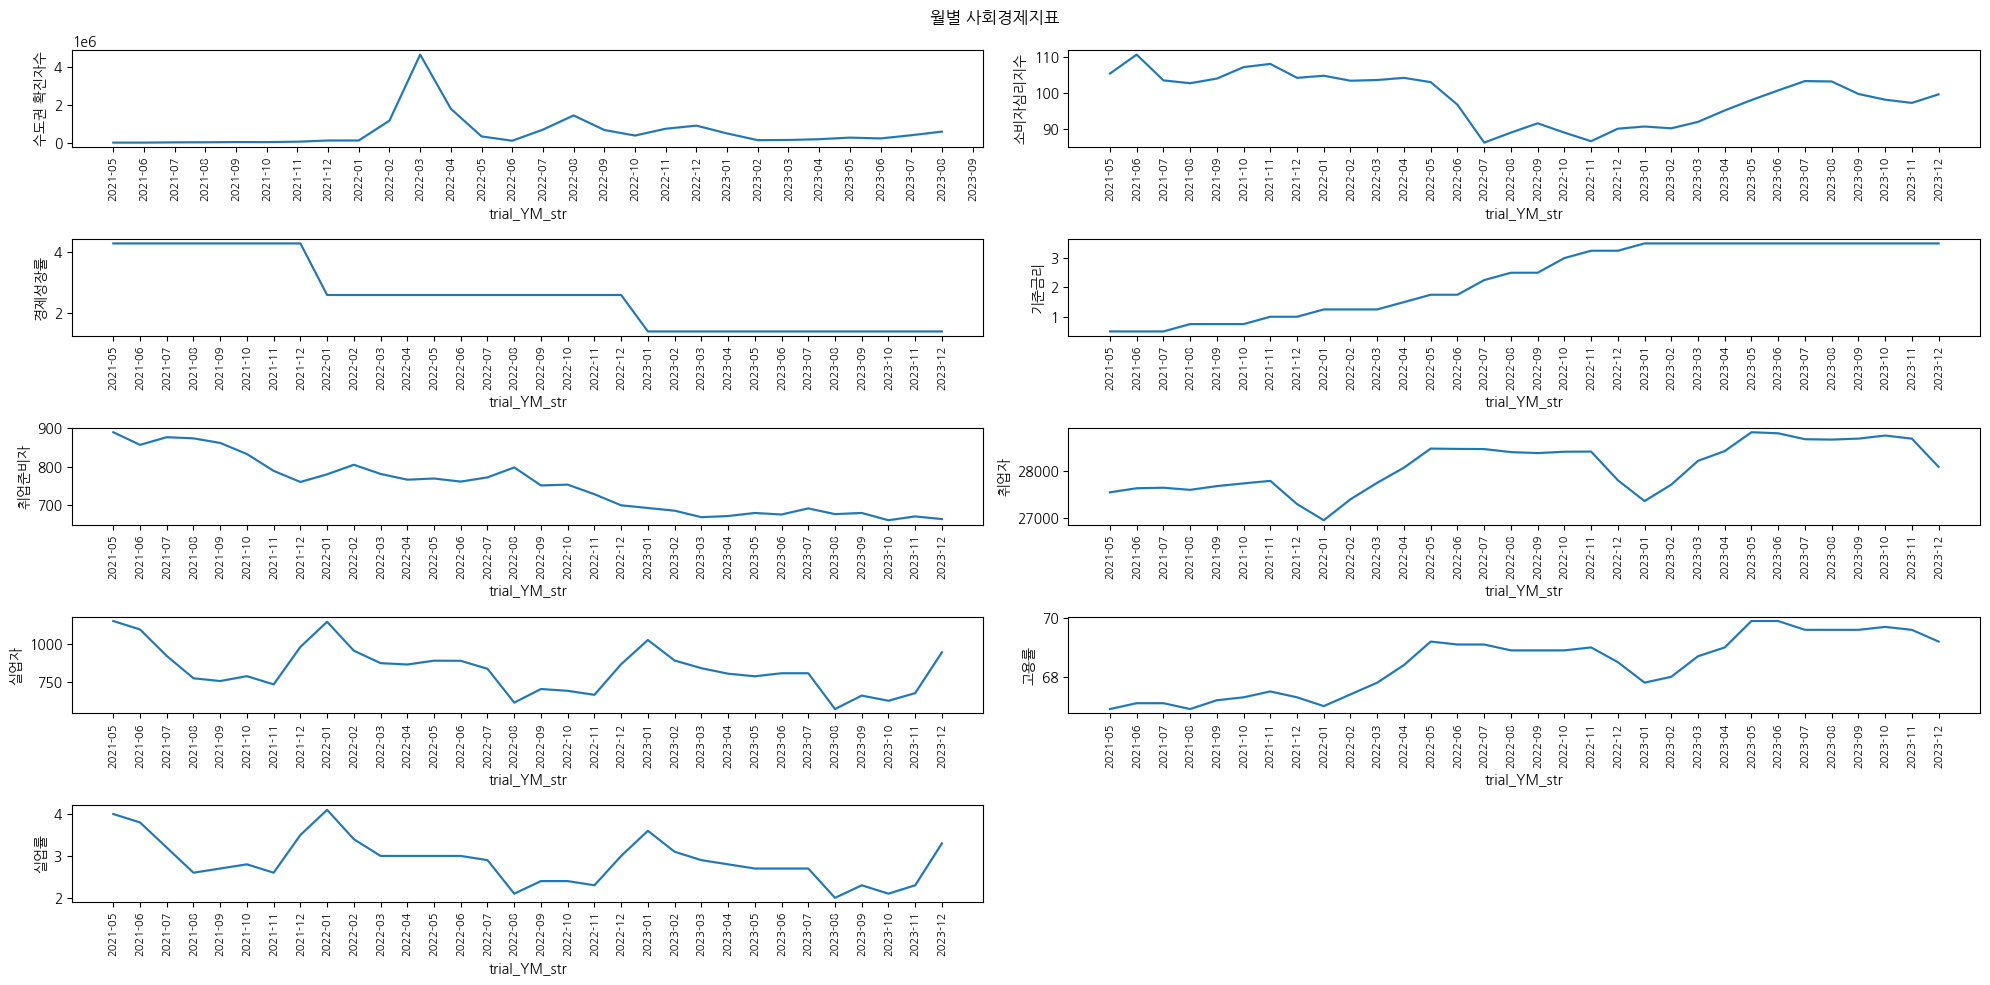

In [ ]:
# Period를 문자열로 변환
metropolitan['trial_YM_str'] = metropolitan['trial_YM'].astype(str)

fig, axes = plt.subplots(5,2, figsize=(20,10))
axes = axes.flatten()
for i, col in enumerate(ses):
    sns.lineplot(data = metropolitan, x = 'trial_YM_str', y = col, ax = axes[i])
    axes[i].tick_params(axis='x', labelsize=8, rotation=90)
fig.suptitle('월별 사회경제지표')

# 남은 빈 그래프 제거
for j in range(len(ses), len(axes)):
    fig.delaxes(axes[j])  # 빈 축 삭제

plt.tight_layout()
plt.show()


<Axes: >

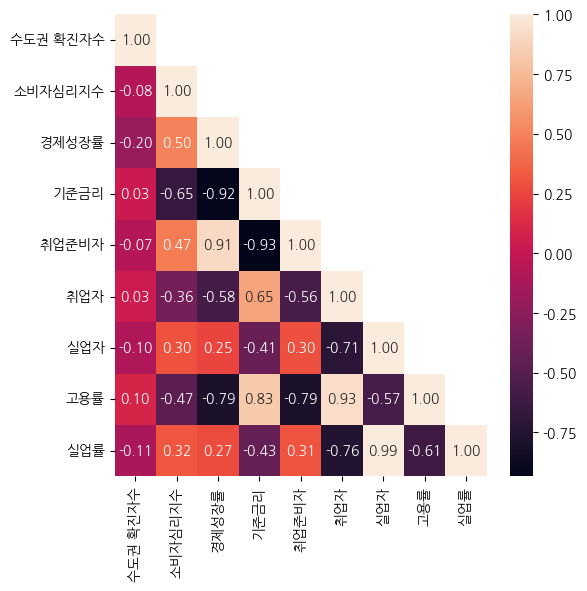

In [ ]:
cor = metropolitan[ses].corr()
mask = np.array(cor)
mask[np.tril_indices_from(mask)] = False
plt.figure(figsize=(6,6))
sns.heatmap(data=cor, annot=True, mask = mask, fmt=".2f")

취업자와 취업률, 실업자와 실업률은 거의 같은 분포를 보이고 있음. 팀원들과 논의 필요.

경제성장률과 취업준비자의 관계가 흥미롭다. 경제성장률이 높은데 취준생은 왜 많은거지? 뭔가 중간 단계가 있는건가?

# 범주형 변수

In [ ]:
var_cat.columns

Index(['출근시간대', '퇴근시간대', 'site_id', 'floor_num', 'floor_lowest',
       'floor_highest', '거리두기 정책', '광고 유무', '공채시즌 여부', '확진자 집계 여부'],
      dtype='object')

In [ ]:
# 각 수준의 빈도와 비율 계산
counts = metropolitan['출근시간대'].value_counts()
proportions = metropolitan['퇴근시간대'].value_counts(normalize=True)  # 비율 계산

# 결과를 데이터프레임으로 보기 좋게 정리
result = pd.DataFrame({
    'proportion': proportions
}).reset_index()

proportions

퇴근시간대
오전    0.641191
심야    0.238128
오후    0.108596
야간    0.012085
Name: proportion, dtype: float64

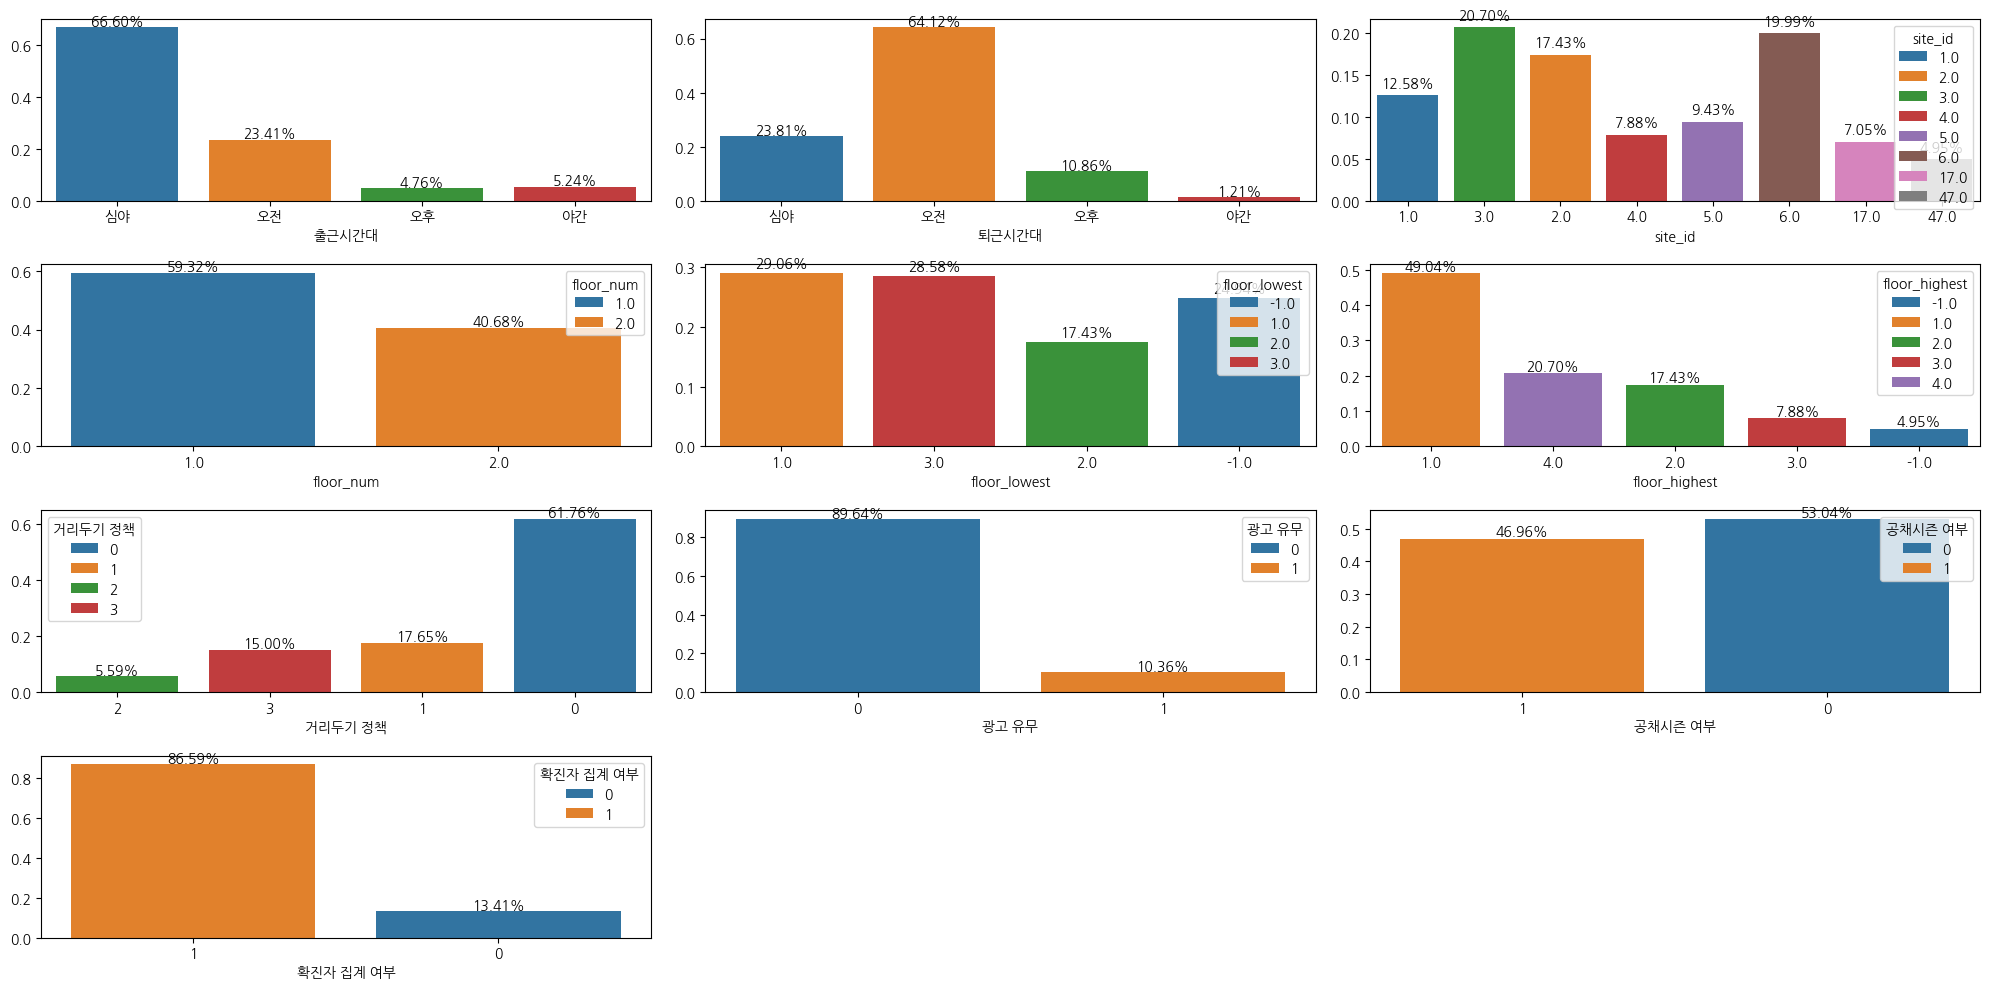

In [ ]:
fig, axes = plt.subplots(4,3, figsize=(20,10))
axes = axes.flatten()
for i, col in enumerate(var_cat.columns):
    # 각 수준의 빈도와 비율 계산
    proportions = metropolitan[col].value_counts(normalize=True)  # 비율 계산
    order = metropolitan[col].dropna().unique()  # 원래 순서 유지
    proportions = proportions.reindex(order)  # 원래 순서로 재정렬
    sns.barplot(x = proportions.index, y = proportions.values, ax = axes[i], order = order, hue = proportions.index)
    
     # 막대 위에 값 추가 (수준 값과 비율 값)
    for x, y in zip(range(len(proportions)), proportions.values):
        axes[i].text(x, y + 0.01, f'{y:.2%}', ha='center', fontsize=10)  # 비율 값 표시 (퍼센트 형식)


# 남은 빈 그래프 제거
for j in range(len(var_cat.columns), len(axes)):
    fig.delaxes(axes[j])  # 빈 축 삭제



plt.tight_layout()
plt.show()

심야에 출근하는 사람이 많고, 오전에 퇴근하는 사람이 많다. 사람들의 활동시간대를 알아보려면 출근시간대와 퇴근시간대를 조합해 새로 만들어야 한다.

In [ ]:
metropolitan['활동시간'] = metropolitan['출근시간대'].astype(str) + '-' + metropolitan['퇴근시간대'].astype(str)
metropolitan['활동시간']

4       심야-심야
5       오전-오전
16      심야-오전
18      심야-오전
19      심야-오전
        ...  
9619    심야-오전
9620    심야-오전
9621    심야-심야
9622    심야-오후
9623    심야-오전
Name: 활동시간, Length: 5899, dtype: object

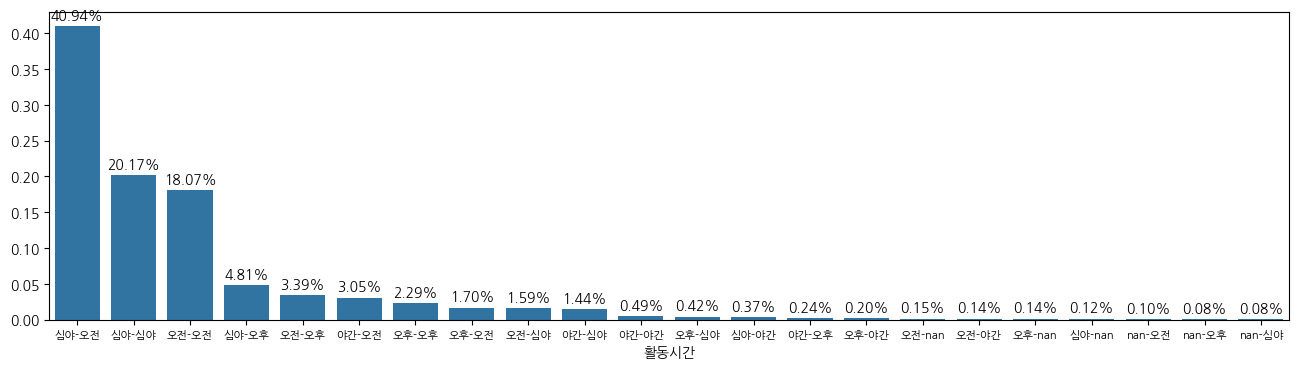

In [ ]:
fig = plt.figure(figsize=(16,4))
proportions = metropolitan['활동시간'].value_counts(normalize=True)
ax = sns.barplot(x = proportions.index, y = proportions.values)
for x, y in zip(range(len(proportions)), proportions.values):
    ax.text(x, y + 0.01, f'{y:.2%}', ha='center', fontsize=10)  # 비율 값 표시 (퍼센트 형식)
plt.xticks(fontsize=8)
plt.show()

출근
- 심야: 0 ~ 6시
- 오전: 7 ~ 11시
- 오후: 12 ~ 17시
- 야간: 18 ~ 23시

퇴근
- 심야: 1 ~ 7시
- 오전: 8 ~ 13시
- 오후: 14 ~ 19시
- 야간: 20 ~ 0시

80%의 유저들이 0~13시 동안 활동한다.
심야보다는 새벽이 더 나은 표현일 듯 -> 새벽으로 바꾸기로 합의 완료

개인 고객들은 오전 시간대에 무료체험을 많이 이용한다.

# data readiness check

In [ ]:
metropolitan['is_payment'].value_counts(normalize=True)

is_payment
0    0.612816
1    0.387184
Name: proportion, dtype: float64

전체 유저 중 결제자: 38.7%

## Mann-Whitney U 검정(연속형 변수)

In [ ]:


# Mann-Whitney U 검정 수행
def Mann(col):
    no_pay = metropolitan[metropolitan['is_payment'] == 0][col]
    yes_pay = metropolitan[metropolitan['is_payment'] == 1][col]
 
    # Mann-Whitney U 검정 수행
    u_stat, p_value = mannwhitneyu(no_pay, yes_pay)
    return float(p_value)

In [ ]:
valid_var_num = []
new_var_num = user_behavior + nearby + ses
for col in new_var_num:
    p = Mann(col)
    if p < 0.05:
        valid_var_num.append(col)

print(valid_var_num)

['평균_입(퇴)실횟수', 'total_usage_time_minutes', '카페 수', '소비자심리지수', '경제성장률', '기준금리', '취업준비자', '취업자', '고용률']


t검정 결과 유료 전환 집단과 비집단 사이에서 통계적으로 유의한 차이가 있는 연속형 변인은 평균_입(퇴)실횟수, total_usage_time_minutes,지하철 역 거리, 카페 수, 경제 성장률, 기준금리, 취업준비자, 취업자, 실업자, 고용률, 실업률이 있다.

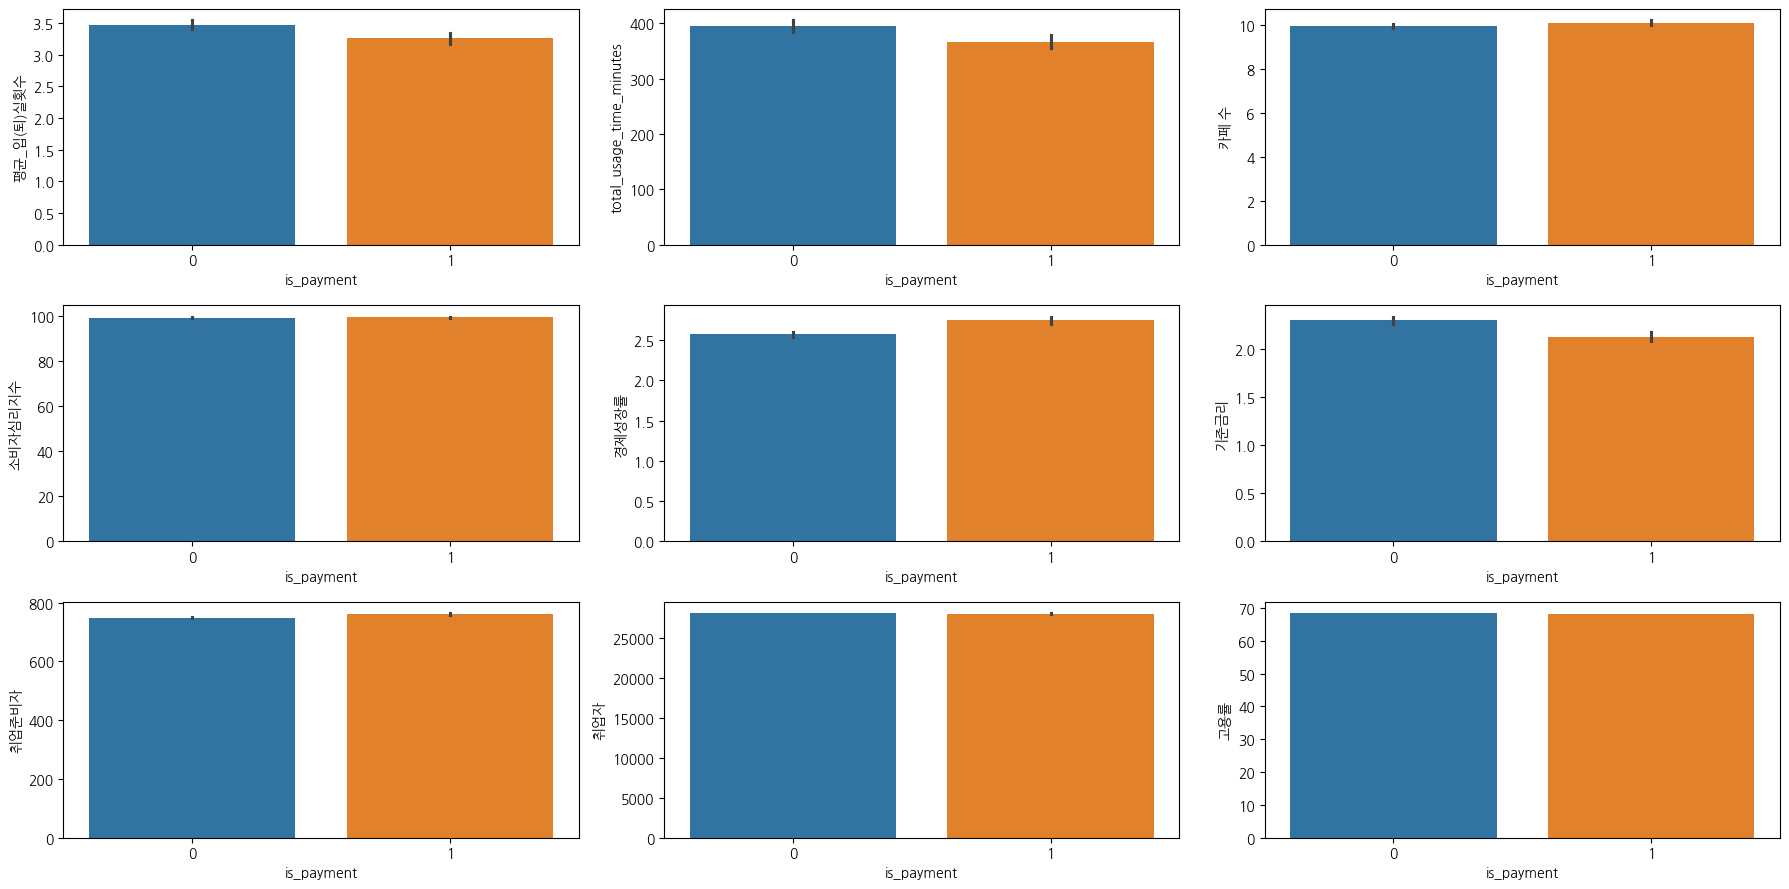

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(18,9))
axes = axes.flatten()
for i, col in enumerate(valid_var_num):
    sns.barplot(data = metropolitan, x = 'is_payment', y = col, hue = 'is_payment', ax = axes[i])
    axes[i].legend().remove()

plt.tight_layout()
plt.show()

## 카이제곱검정(범주형 변수)

C:\Users\csh94\AppData\Local\Temp\ipykernel_33736\3584850781.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = metropolitan.groupby(col)['is_payment'].value_counts(normalize=True).reset_index(name='ratio')  # 비율 계산
C:\Users\csh94\AppData\Local\Temp\ipykernel_33736\3584850781.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = metropolitan.groupby(col)['is_payment'].value_counts(normalize=True).reset_index(name='ratio')  # 비율 계산
C:\Users\csh94\AppData\Local\Temp\ipykernel_33736\3584850781.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True 

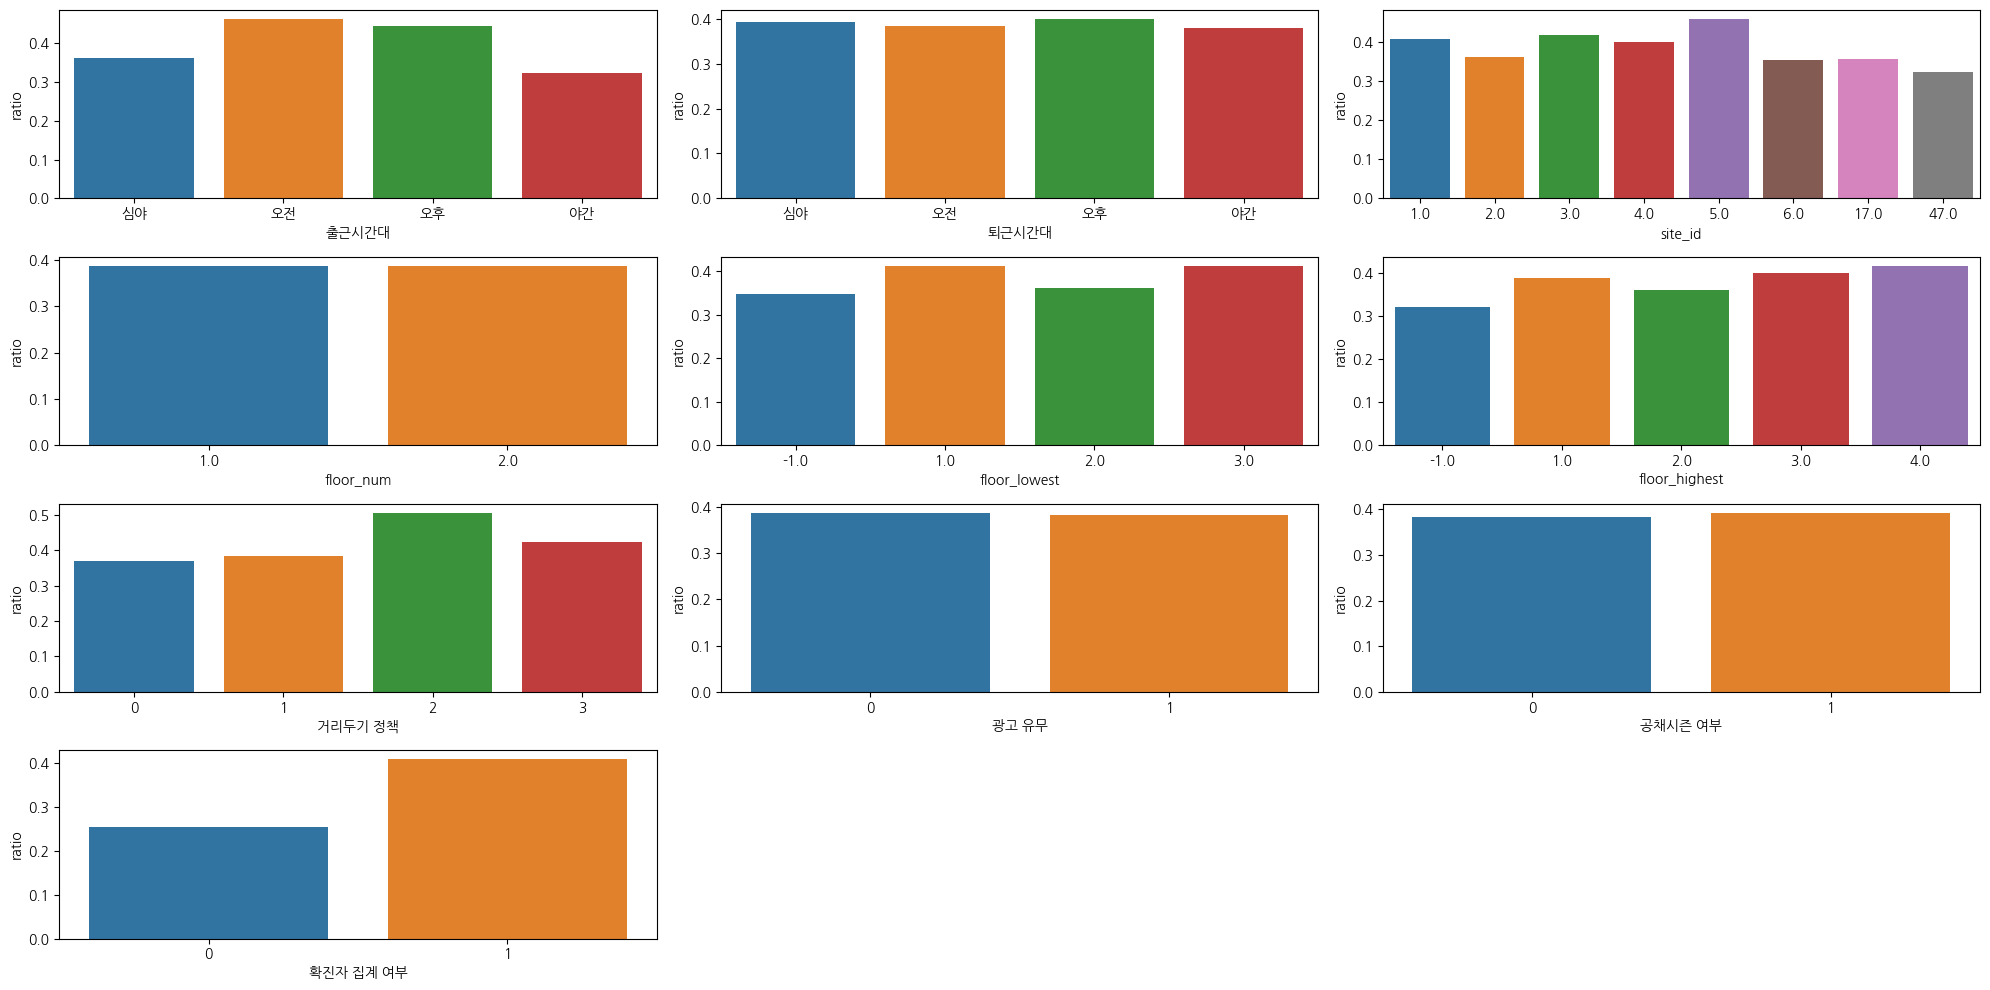

In [ ]:
fig, axes = plt.subplots(4,3, figsize=(20,10))
axes = axes.flatten()
for i, col in enumerate(var_cat.columns):
    # 각 수준의 빈도와 비율 계산
    proportions = metropolitan.groupby(col)['is_payment'].value_counts(normalize=True).reset_index(name='ratio')  # 비율 계산
    ratio_convert = proportions.loc[proportions['is_payment'] == 1]

    sns.barplot(data = ratio_convert, x = col, y = 'ratio', hue = col, ax = axes[i])
    if axes[i].get_legend() is not None:
        axes[i].legend().remove()
    

# 남은 빈 그래프 제거
for j in range(len(var_cat.columns), len(axes)):
    fig.delaxes(axes[j])  # 빈 축 삭제



plt.tight_layout()
plt.show()

<Axes: xlabel='활동시간', ylabel='ratio'>

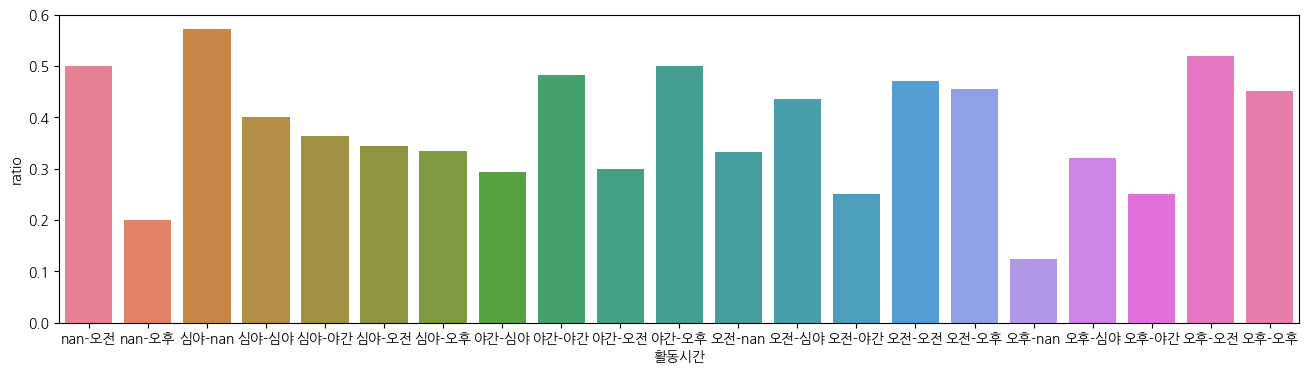

In [ ]:
fig = plt.figure(figsize = (16,4))
proportions = metropolitan.groupby('활동시간')['is_payment'].value_counts(normalize=True).reset_index(name='ratio')  # 비율 계산
ratio_convert = proportions.loc[proportions['is_payment'] == 1]
sns.barplot(data = ratio_convert, x = '활동시간', y = 'ratio', hue = '활동시간')

In [ ]:
def chi2_test(col):
    # 교차표 생성
    crosstab = pd.crosstab(metropolitan[col], metropolitan['is_payment'])
    # display(crosstab)
    # 카이제곱 검정
    chi2, p, dof, expected = chi2_contingency(crosstab)
    # 결과 출력
    # print("Chi-squared:", chi2)
    # print("p-value:", p)
    # print("Degrees of freedom:", dof)
    # print("Expected frequencies:")
    # print(expected)
    return float(p)

In [ ]:
valid_var = []
for col in var_cat.columns:
    p = chi2_test(col)
    if p < 0.05:
        valid_var.append(col)

In [ ]:
p = chi2_test('활동시간')
p

3.0795057835401957e-10

In [ ]:
valid_var.append('활동시간')

In [ ]:
valid_var

['출근시간대',
 'site_id',
 'floor_lowest',
 'floor_highest',
 '거리두기 정책',
 '확진자 집계 여부',
 '활동시간']

C:\Users\csh94\AppData\Local\Temp\ipykernel_33736\63537044.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = metropolitan.groupby(col)['is_payment'].value_counts(normalize=True).reset_index(name='ratio')  # 비율 계산
C:\Users\csh94\AppData\Local\Temp\ipykernel_33736\63537044.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = metropolitan.groupby(col)['is_payment'].value_counts(normalize=True).reset_index(name='ratio')  # 비율 계산
C:\Users\csh94\AppData\Local\Temp\ipykernel_33736\63537044.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a f

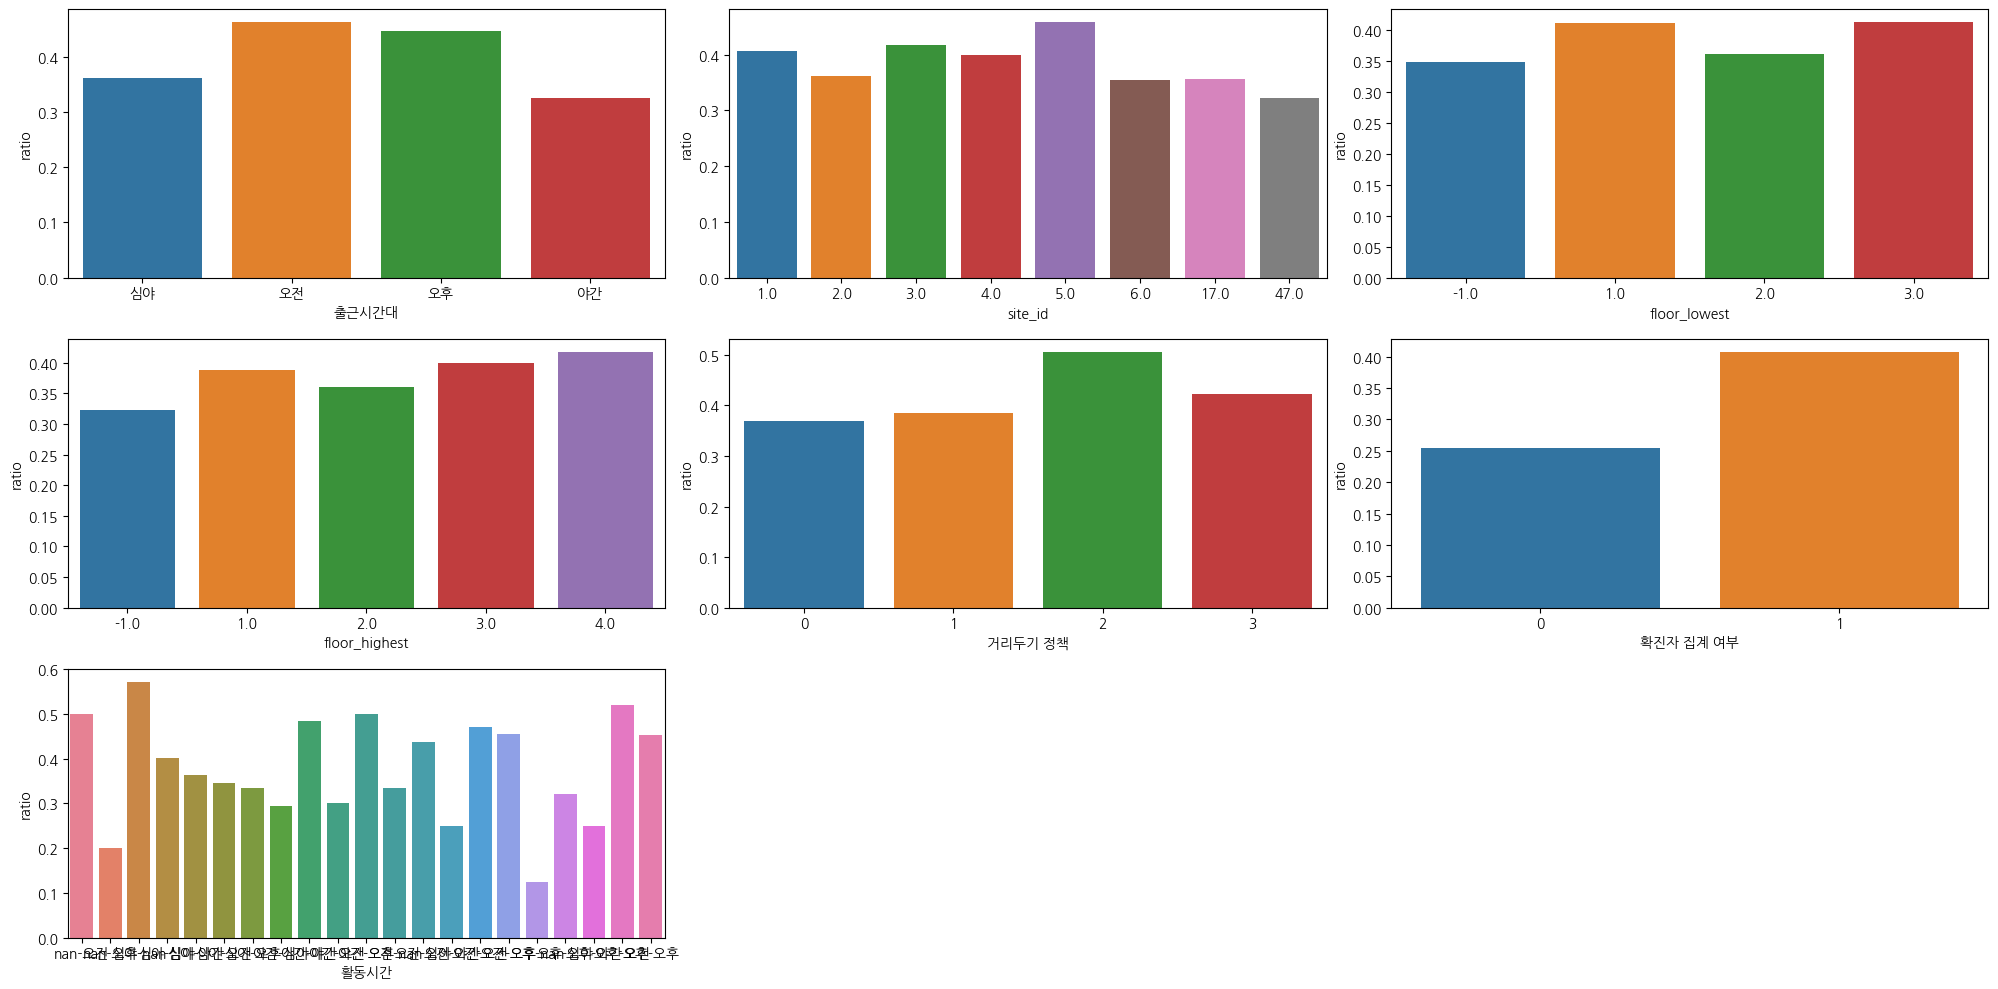

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(20,10))
axes = axes.flatten()
for i, col in enumerate(valid_var):
    # 각 수준의 빈도와 비율 계산
    proportions = metropolitan.groupby(col)['is_payment'].value_counts(normalize=True).reset_index(name='ratio')  # 비율 계산
    ratio_convert = proportions.loc[proportions['is_payment'] == 1]

    sns.barplot(data = ratio_convert, x = col, y = 'ratio', hue = col, ax = axes[i])
    if axes[i].get_legend() is not None:
        axes[i].legend().remove()

    

# 남은 빈 그래프 제거
for j in range(len(valid_var), len(axes)):
    fig.delaxes(axes[j])  # 빈 축 삭제

plt.tight_layout()
plt.show()

범주형 변수 중 유료전환율과 통계적으로 유의미한 관계가 있는 것은  출근시간대, site_id, floor_lowest(highest), 거리두기 정책, 확진자 집계 여부, 활동시간이 있다.

# 출근시간대, 퇴근시간대 null값 채우기

## 출근시간대

In [ ]:
# 랜덤포레스트로 채우기

map_for_time = {'심야': 0,'오전': 1,'오후': 2,'야간':3}

metropolitan_출근 = metropolitan[metropolitan['출근시간대'].isnull() == 0]
metropolitan_출근_null = metropolitan[metropolitan['출근시간대'].isnull() == 1]


# 라벨 인코딩 수행
metropolitan_출근['퇴근시간대'] = metropolitan_출근['퇴근시간대'].map(map_for_time)
metropolitan_출근['출근시간대'] = metropolitan_출근['출근시간대'].map(map_for_time)

metropolitan_출근_null['퇴근시간대'] = metropolitan_출근_null['퇴근시간대'].map(map_for_time)


var_cats = var_cat.columns.to_list()
var_cats2 = var_cats.copy()
var_cats2.remove('출근시간대')

var_for_출근 = new_var_num + var_cats2
X = metropolitan_출근[var_for_출근]
y = metropolitan_출근['출근시간대']

model_for_출근 = RandomForestClassifier(n_estimators=100, random_state=42)
model_for_출근.fit(X,y)
출근_pred = model_for_출근.predict(metropolitan_출근_null[var_for_출근])

print(출근_pred)

C:\Users\csh94\AppData\Local\Temp\ipykernel_33736\3634763233.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metropolitan_출근['퇴근시간대'] = metropolitan_출근['퇴근시간대'].map(map_for_time)
C:\Users\csh94\AppData\Local\Temp\ipykernel_33736\3634763233.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metropolitan_출근['출근시간대'] = metropolitan_출근['출근시간대'].map(map_for_time)
C:\Users\csh94\AppData\Local\Temp\ipykernel_33736\3634763233.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

[0 1 1 0 1 2 1 0 1 1 0 0 0 1 0 2]


In [ ]:
metropolitan_출근_null['출근시간대'] = 출근_pred
metropolitan_출근_null['출근시간대']

C:\Users\csh94\AppData\Local\Temp\ipykernel_33736\685263651.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metropolitan_출근_null['출근시간대'] = 출근_pred


156     0
336     1
337     1
535     0
1108    1
2513    2
2543    1
3428    0
5030    1
5037    1
5341    0
5630    0
6528    0
6752    1
6867    0
7047    2
Name: 출근시간대, dtype: int64

In [ ]:
metropolitan_v2 = pd.concat([metropolitan_출근, metropolitan_출근_null])
metropolitan_v2

,trial_date,trial_YM,출근시간대,퇴근시간대,평균_입(퇴)실횟수,site_id,total_usage_time_minutes,총 이용 시간,이용 지점 수,area_pyeong,...,취업준비자,취업자,실업자,고용률,실업률,공채시즌 여부,확진자 집계 여부,is_payment,trial_YM_str,활동시간
4,2021-05-01,2021-05,0,0,1.0,1.0,142.344708,142.344708,1,50.0,...,890.0,27550.0,1148.0,66.9,4.0,1,1,1,2021-05,심야-심야
5,2021-05-01,2021-05,1,1,3.0,3.0,165.020445,165.020445,1,150.0,...,890.0,27550.0,1148.0,66.9,4.0,1,1,0,2021-05,오전-오전
16,2021-05-03,2021-05,0,1,2.0,3.0,230.568305,230.568305,1,150.0,...,890.0,27550.0,1148.0,66.9,4.0,1,1,1,2021-05,심야-오전
18,2021-05-04,2021-05,0,1,4.0,2.0,367.514980,367.514980,1,100.0,...,890.0,27550.0,1148.0,66.9,4.0,1,1,0,2021-05,심야-오전
19,2021-05-04,2021-05,0,1,5.0,3.0,262.037460,262.037460,1,150.0,...,890.0,27550.0,1148.0,66.9,4.0,1,1,0,2021-05,심야-오전
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5630,2022-10-26,2022-10,0,0,1.0,4.0,180.000000,180.000000,1,100.0,...,753.0,28418.0,692.0,68.9,2.4,1,1,0,2022-10,nan-심야
6528,2023-01-25,2023-01,0,1,1.0,6.0,180.000000,180.000000,1,150.0,...,692.0,27363.0,1024.0,67.8,3.6,0,1,0,2023-01,nan-오전
6752,2023-02-17,2023-02,1,1,1.0,5.0,180.000000,180.000000,1,150.0,...,685.0,27714.0,890.0,68.0,3.1,0,1,1,2023-02,nan-오전
6867,2023-03-02,2023-03,0,0,1.0,17.0,180.000000,180.000000,1,50.0,...,668.0,28223.0,840.0,68.7,2.9,1,1,0,2023-03,nan-심야


## 퇴근시간대 채우기

In [ ]:
metropolitan_퇴근 = metropolitan_v2[metropolitan_v2['퇴근시간대'].isnull() == 0]
metropolitan_퇴근_null = metropolitan_v2[metropolitan_v2['퇴근시간대'].isnull() == 1]

# # 라벨 인코딩 수행
# metropolitan_퇴근['퇴근시간대'] = metropolitan_퇴근['퇴근시간대'].map(map_for_time)
# metropolitan_퇴근['출근시간대'] = metropolitan_퇴근['출근시간대'].map(map_for_time)

# metropolitan_퇴근_null['출근시간대'] = metropolitan_퇴근_null['출근시간대'].map(map_for_time)


var_cats = var_cat.columns.to_list()
var_cats2 = var_cats.copy()
var_cats2.remove('퇴근시간대')

var_for_퇴근 = new_var_num + var_cats2
X = metropolitan_퇴근[var_for_퇴근]
y = metropolitan_퇴근['퇴근시간대']
y.isnull().sum()
model_for_퇴근 = RandomForestClassifier(n_estimators=100, random_state=42)
model_for_퇴근.fit(X,y)
퇴근_pred = model_for_퇴근.predict(metropolitan_퇴근_null[var_for_퇴근])

print(퇴근_pred)

[1 2 0 0 1 1 1 2 2 2 1 1 2 2 1 1 1 1 1 1 1 1 1 0]


In [ ]:
metropolitan_퇴근_null['퇴근시간대'] = 퇴근_pred
metropolitan_퇴근_null['퇴근시간대']

C:\Users\csh94\AppData\Local\Temp\ipykernel_33736\2204437883.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metropolitan_퇴근_null['퇴근시간대'] = 퇴근_pred


205     1
496     2
720     0
791     0
1124    1
1405    1
2246    1
2629    2
2676    2
2757    2
3498    1
4281    1
5298    2
5300    2
5387    1
5618    1
5893    1
6685    1
6923    1
7726    1
7892    1
8274    1
8406    1
8695    0
Name: 퇴근시간대, dtype: int64

In [ ]:
metropolitan_v2 = pd.concat([metropolitan_퇴근, metropolitan_퇴근_null])
metropolitan_v2['활동시간'] = metropolitan_v2['출근시간대'].astype(str) + metropolitan_v2['퇴근시간대'].astype(str)
metropolitan_v2['활동시간'].head(10)

4     00
5     11
16    01
18    01
19    01
21    11
23    01
34    11
37    11
39    11
Name: 활동시간, dtype: object

In [ ]:
metropolitan_v2.to_csv('raw_data.csv', index=False)

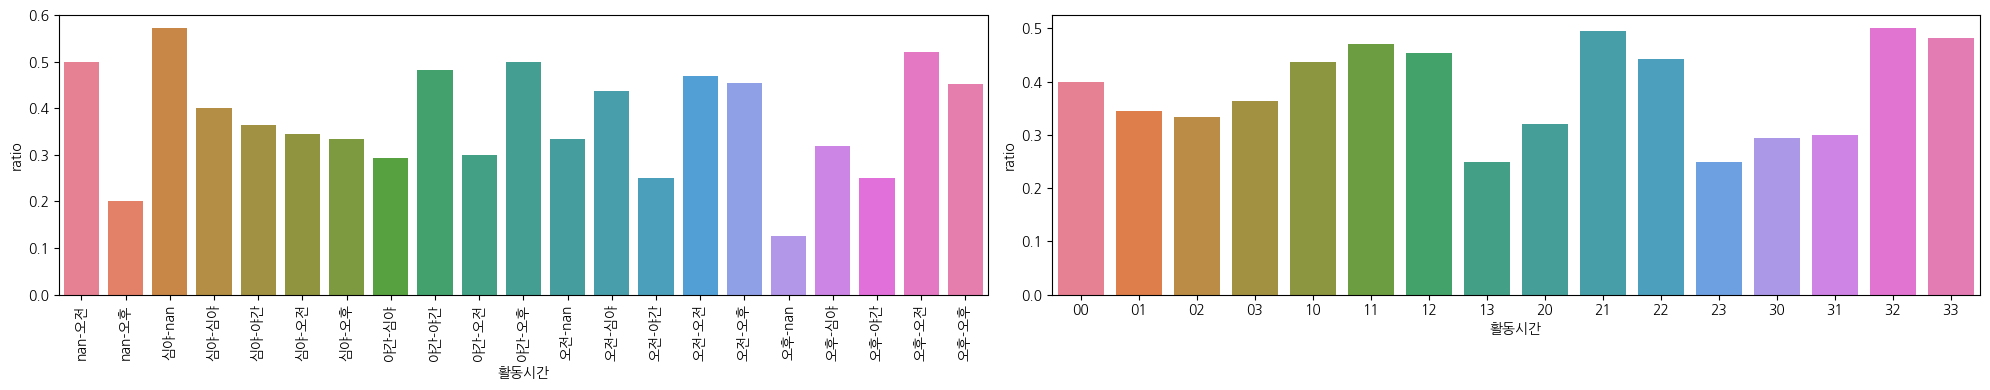

In [ ]:
fig, axes = plt.subplots(1,2,figsize = (20,4))
proportions_v1 = metropolitan.groupby('활동시간')['is_payment'].value_counts(normalize=True).reset_index(name='ratio')  # 비율 계산
ratio_convert_v1 = proportions_v1.loc[proportions_v1['is_payment'] == 1]

proportions_v2 = metropolitan_v2.groupby('활동시간')['is_payment'].value_counts(normalize=True).reset_index(name='ratio')  # 비율 계산
ratio_convert_v2 = proportions_v2.loc[proportions_v2['is_payment'] == 1]

sns.barplot(data = ratio_convert_v1, x = '활동시간', y = 'ratio', hue = '활동시간', ax = axes[0])
sns.barplot(data = ratio_convert_v2, x = '활동시간', y = 'ratio', hue = '활동시간', ax = axes[1])
axes[0].tick_params(axis = 'x', labelrotation = 90)

plt.tight_layout()
plt.show()


# 엔데믹 선언 전후 비교

In [ ]:
metropolitan_v2['trial_YM'].info()

<class 'pandas.core.series.Series'>
Index: 5899 entries, 4 to 8695
Series name: trial_YM
Non-Null Count  Dtype    
--------------  -----    
5899 non-null   period[M]
dtypes: period[M](1)
memory usage: 92.2 KB


In [ ]:
# 23년 5월 이전과 이후 비교
metropolitan_v2['endemic'] = (metropolitan_v2['trial_YM'] >= '2023-05').astype('category')
metropolitan_v2['endemic_payment'] = metropolitan_v2['endemic'].astype(str)+'_'+metropolitan_v2['is_payment'].astype(str)


def ratio_graph(col):
    proportions = metropolitan_v2.groupby('endemic_payment')[col].value_counts(normalize=True).reset_index(name='ratio')  # 비율 계산
    sns.catplot(data = proportions, x = col, y = 'ratio', kind = 'bar', col='endemic_payment')

C:\Users\csh94\AppData\Local\Temp\ipykernel_33736\126118391.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  endemic_payment = metropolitan_v2.groupby('endemic')['is_payment'].value_counts(normalize=True).reset_index(name='ratio')


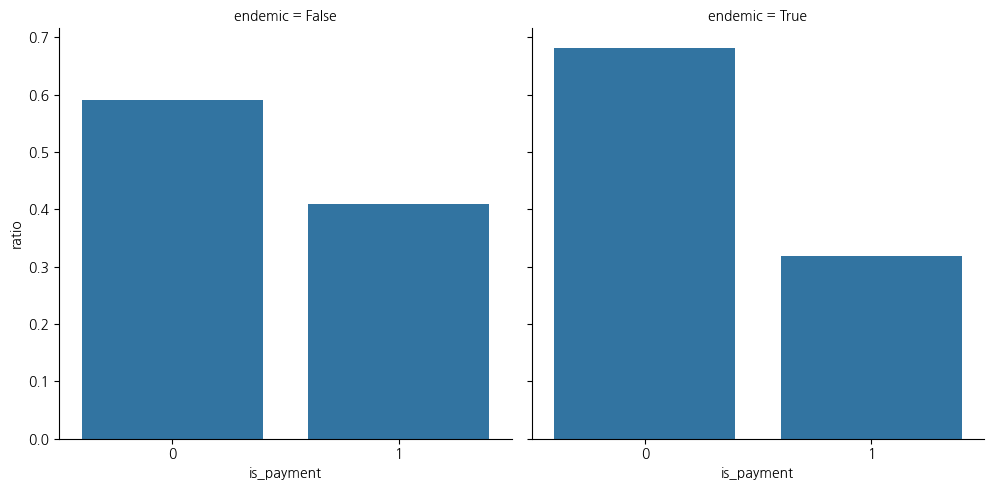

In [ ]:
endemic_payment = metropolitan_v2.groupby('endemic')['is_payment'].value_counts(normalize=True).reset_index(name='ratio')
sns.catplot(data = endemic_payment, kind = 'bar', x = 'is_payment', y = 'ratio', col = 'endemic')


엔데믹 이후 비결제와 유료결제의 차이가 더 커짐. 이를 카이제곱검정으로 비교하고자 함.

In [ ]:
crosstab = pd.crosstab(metropolitan_v2['endemic'], metropolitan['is_payment'])
display(crosstab)
# 카이제곱 검정
chi2, p, dof, expected = chi2_contingency(crosstab)
# 결과 출력
print("Chi-squared:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:")
print(expected)


is_payment,0,1
endemic,,
False,2638,1828
True,977,456


Chi-squared: 37.56493347126877
p-value: 8.841986727619663e-10
Degrees of freedom: 1
Expected frequencies:
[[2736.83505679 1729.16494321]
 [ 878.16494321  554.83505679]]


카이제곱 검정 결과, 코로나 엔데믹 여부는 유료 결제 여부와 유의한 관계에 있음을 확인했다.

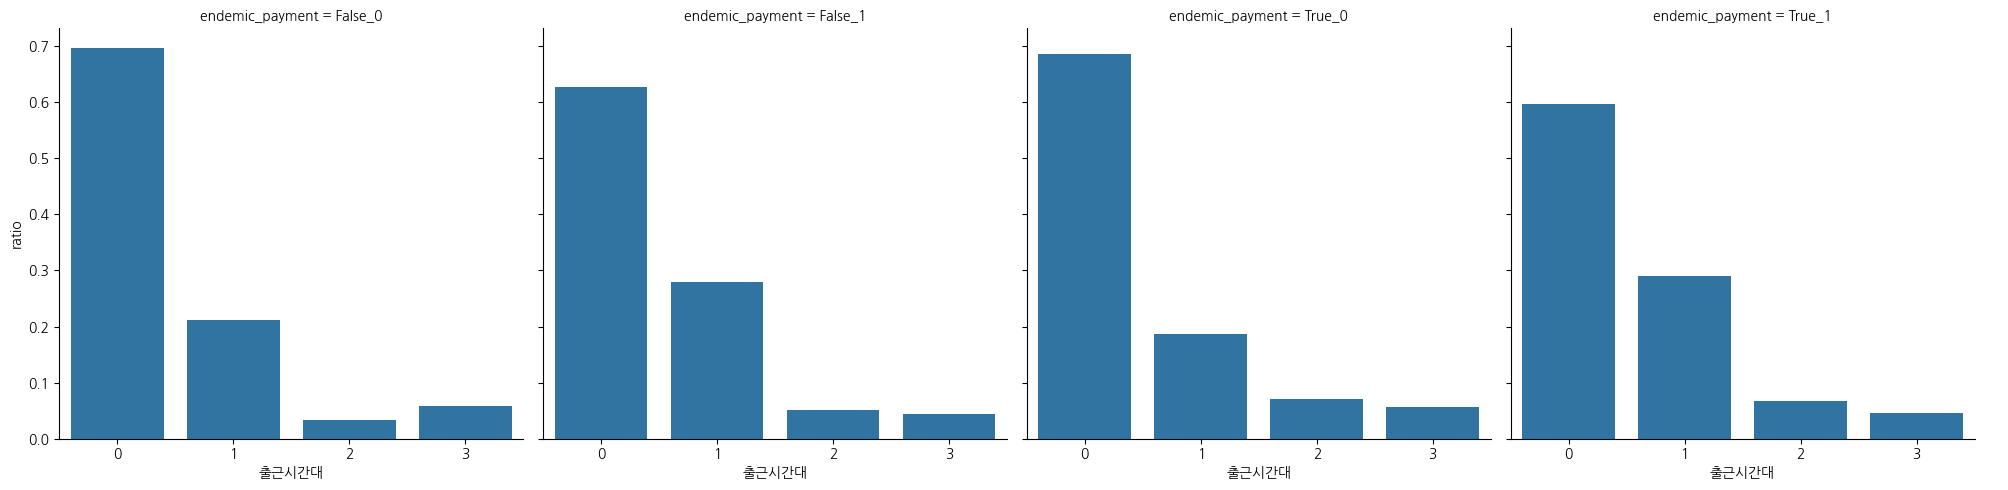

In [ ]:
ratio_graph('출근시간대')

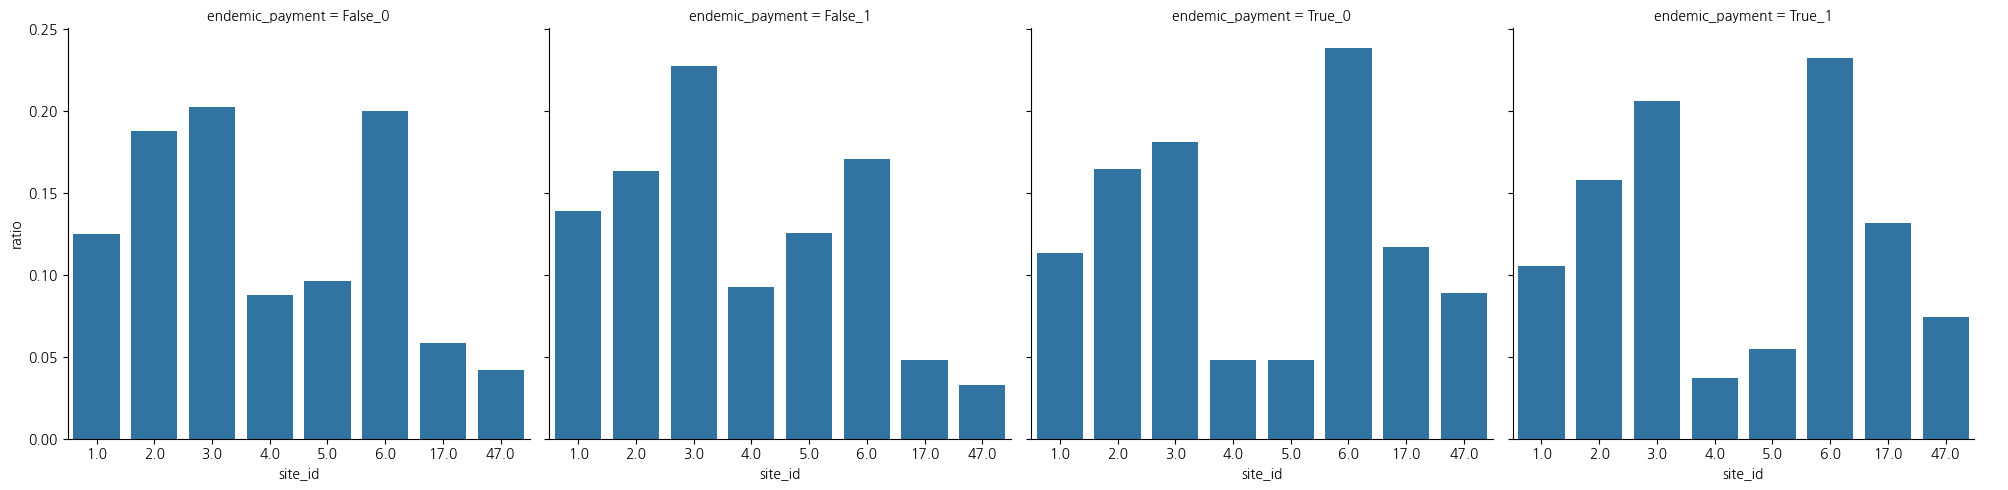

In [ ]:
ratio_graph('site_id')

코로나 이후 site_id =4, 5의 인기가 더 감소했으며, site_id=6, 17, 47을 방문하는 비율이 증가함


In [ ]:
# Mann-Whitney U 검정 수행
def Mann_endemic(col):
    no_pay = metropolitan[metropolitan['endemic'] == False][col]
    yes_pay = metropolitan[metropolitan['endemic'] == True][col]
 
    # Mann-Whitney U 검정 수행
    u_stat, p_value = mannwhitneyu(no_pay, yes_pay)
    return float(p_value)

In [ ]:
endemic_valid_var_num = []

for col in new_var_num:
    p = Mann(col)
    if p < 0.05:
        endemic_valid_var_num.append(col)

print(endemic_valid_var_num)

['평균_입(퇴)실횟수', 'total_usage_time_minutes', '카페 수', '소비자심리지수', '경제성장률', '기준금리', '취업준비자', '취업자', '고용률']


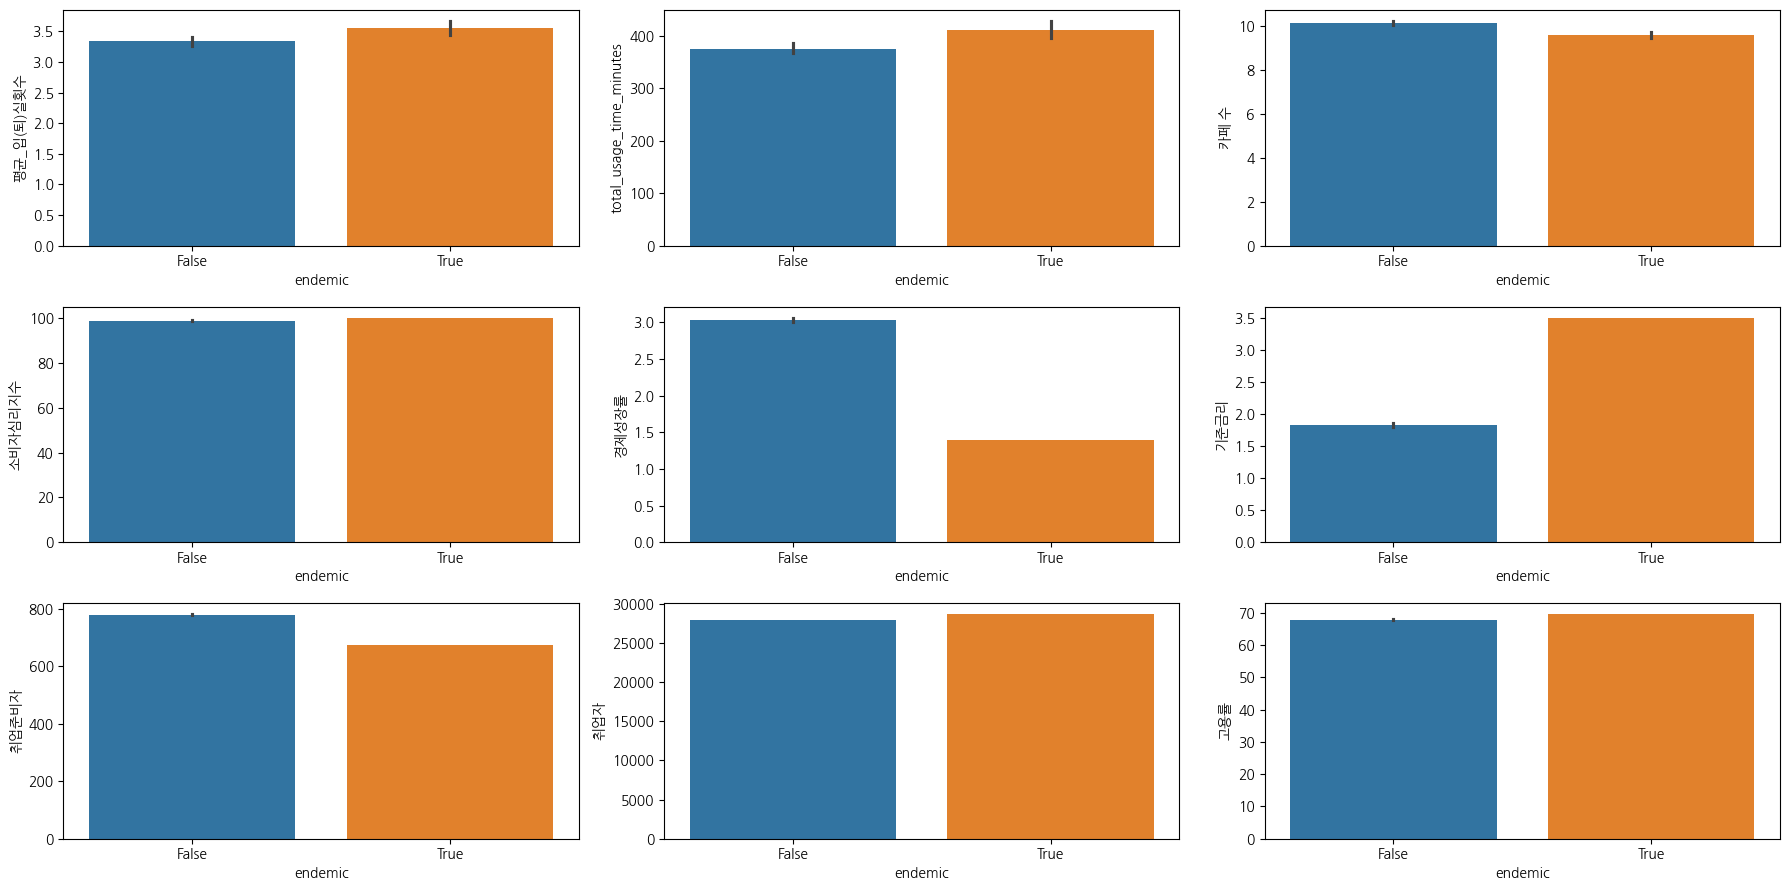

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(18,9))
axes = axes.flatten()
for i, col in enumerate(valid_var_num):
    sns.barplot(data = metropolitan_v2, x = 'endemic', y = col, hue = 'endemic', ax = axes[i])
    axes[i].legend().remove()

plt.tight_layout()
plt.show()

In [ ]:
raw_data = pd.read_csv('raw_data.csv')
raw_data.head()

,trial_date,trial_YM,출근시간대,퇴근시간대,평균_입(퇴)실횟수,site_id,total_usage_time_minutes,총 이용 시간,이용 지점 수,area_pyeong,...,취업준비자,취업자,실업자,고용률,실업률,공채시즌 여부,확진자 집계 여부,is_payment,trial_YM_str,활동시간
0,2021-05-01,2021-05,0,0,1.0,1.0,142.344708,142.344708,1,50.0,...,890.0,27550.0,1148.0,66.9,4.0,1,1,1,2021-05,0
1,2021-05-01,2021-05,1,1,3.0,3.0,165.020445,165.020445,1,150.0,...,890.0,27550.0,1148.0,66.9,4.0,1,1,0,2021-05,11
2,2021-05-03,2021-05,0,1,2.0,3.0,230.568305,230.568305,1,150.0,...,890.0,27550.0,1148.0,66.9,4.0,1,1,1,2021-05,1
3,2021-05-04,2021-05,0,1,4.0,2.0,367.514980,367.514980,1,100.0,...,890.0,27550.0,1148.0,66.9,4.0,1,1,0,2021-05,1
4,2021-05-04,2021-05,0,1,5.0,3.0,262.037460,262.037460,1,150.0,...,890.0,27550.0,1148.0,66.9,4.0,1,1,0,2021-05,1


In [ ]:
raw_data = raw_data.drop(['trial_date','총 이용 시간','trial_YM_str','활동시간','취업자','실업자','광고 유무'], axis = 1)
raw_data

,trial_YM,출근시간대,퇴근시간대,평균_입(퇴)실횟수,site_id,total_usage_time_minutes,이용 지점 수,area_pyeong,floor_num,floor_lowest,...,거리두기 정책,소비자심리지수,경제성장률,기준금리,취업준비자,고용률,실업률,공채시즌 여부,확진자 집계 여부,is_payment
0,2021-05,0,0,1.0,1.0,142.344708,1,50.0,1.0,1.0,...,2,105.5,4.3,0.5,890.0,66.9,4.0,1,1,1
1,2021-05,1,1,3.0,3.0,165.020445,1,150.0,2.0,3.0,...,2,105.5,4.3,0.5,890.0,66.9,4.0,1,1,0
2,2021-05,0,1,2.0,3.0,230.568305,1,150.0,2.0,3.0,...,2,105.5,4.3,0.5,890.0,66.9,4.0,1,1,1
3,2021-05,0,1,4.0,2.0,367.514980,1,100.0,1.0,2.0,...,2,105.5,4.3,0.5,890.0,66.9,4.0,1,1,0
4,2021-05,0,1,5.0,3.0,262.037460,1,150.0,2.0,3.0,...,2,105.5,4.3,0.5,890.0,66.9,4.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5894,2023-06,2,1,1.0,2.0,180.000000,1,100.0,1.0,2.0,...,0,100.8,1.4,3.5,675.0,69.9,2.7,0,1,1
5895,2023-06,2,1,1.0,2.0,180.000000,1,100.0,1.0,2.0,...,0,100.8,1.4,3.5,675.0,69.9,2.7,0,1,0
5896,2023-08,1,1,1.0,2.0,180.000000,1,100.0,1.0,2.0,...,0,103.3,1.4,3.5,676.0,69.6,2.0,0,1,1
5897,2023-08,1,1,1.0,3.0,180.000000,1,150.0,2.0,3.0,...,0,103.3,1.4,3.5,676.0,69.6,2.0,0,1,0


In [ ]:
raw_data.columns

Index(['trial_YM', '출근시간대', '퇴근시간대', '평균_입(퇴)실횟수', 'site_id',
       'total_usage_time_minutes', '이용 지점 수', 'area_pyeong', 'floor_num',
       'floor_lowest', 'floor_highest', '지하철 역 거리', '평균승객',
       '반경 100m 내 버스 정류장 수', '400M 내 아파트 수', '카페 수', '스터디 카페', '공유 오피스',
       '수도권 확진자수', '거리두기 정책', '소비자심리지수', '경제성장률', '기준금리', '취업준비자', '고용률',
       '실업률', '공채시즌 여부', '확진자 집계 여부', 'is_payment'],
      dtype='object')

In [ ]:
raw_data['trial_YM'] = pd.to_datetime(raw_data['trial_YM'])
raw_data['Year'] = raw_data['trial_YM'].dt.year
raw_data['Month'] = raw_data['trial_YM'].dt.month
raw_data.drop('trial_YM', axis=1, inplace=True)

In [ ]:
raw_data['floor_lowest'].unique()

array([ 1.,  3.,  2., -1.])

In [ ]:
raw_data['floor_lowest'] = raw_data['floor_lowest'].replace({-1:0})
raw_data['floor_lowest'] = raw_data['floor_lowest'].astype(int)
raw_data['floor_highest'] = raw_data['floor_highest'].astype(int)

In [ ]:
features = raw_data.columns.to_list()
features.remove('is_payment')
X = raw_data[features]
y = raw_data['is_payment']

# Feature Engineering

## 인코딩

### 원핫인코딩

In [ ]:
one_hot_X = pd.get_dummies(X, columns=['출근시간대','퇴근시간대','site_id','거리두기 정책','공채시즌 여부','확진자 집계 여부'], drop_first=True, dtype=int)
one_hot_X.head()

,평균_입(퇴)실횟수,total_usage_time_minutes,이용 지점 수,area_pyeong,floor_num,floor_lowest,floor_highest,지하철 역 거리,평균승객,반경 100m 내 버스 정류장 수,...,site_id_4.0,site_id_5.0,site_id_6.0,site_id_17.0,site_id_47.0,거리두기 정책_1,거리두기 정책_2,거리두기 정책_3,공채시즌 여부_1,확진자 집계 여부_1
0,1.0,142.344708,1,50.0,1.0,1,1.0,155.50,40019.2,3.0,...,0,0,0,0,0,0,1,0,1,1
1,3.0,165.020445,1,150.0,2.0,3,4.0,266.51,15033.9,1.0,...,0,0,0,0,0,0,1,0,1,1
2,2.0,230.568305,1,150.0,2.0,3,4.0,266.51,15033.9,1.0,...,0,0,0,0,0,0,1,0,1,1
3,4.0,367.514980,1,100.0,1.0,2,2.0,200.00,84609.8,0.0,...,0,0,0,0,0,0,1,0,1,1
4,5.0,262.037460,1,150.0,2.0,3,4.0,266.51,15033.9,1.0,...,0,0,0,0,0,0,1,0,1,1


## Catboost용 인코딩

In [ ]:
cat_features = ['출근시간대','퇴근시간대','site_id','거리두기 정책','공채시즌 여부','확진자 집계 여부','floor_lowest','floor_highest']
Cat_X = X.copy()
for i in cat_features:
    Cat_X[i] = Cat_X[i].astype(str)

## 랜덤 포레스트

### 기본

In [ ]:
# 분할
X_train, X_test, y_train, y_test = train_test_split(one_hot_X, y, stratify= y, test_size=0.3, random_state=42)

# 모델 생성
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# 모델 학습
rf_model.fit(X_train, y_train)

# 테스트 데이터 예측
y_pred = rf_model.predict(X_test)

# 정확도 계산
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))


Accuracy: 0.57
              precision    recall  f1-score   support

           0       0.63      0.72      0.67      1085
           1       0.44      0.35      0.39       685

    accuracy                           0.57      1770
   macro avg       0.54      0.53      0.53      1770
weighted avg       0.56      0.57      0.56      1770



### 하이퍼파라미터 튜닝

In [ ]:
# 하이퍼파라미터 최적화 함수 정의
def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    # 랜덤 포레스트 모델 생성
    model = RandomForestClassifier(
        n_estimators=int(n_estimators),  # 정수형으로 변환
        max_depth=int(max_depth),       # 정수형으로 변환
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        random_state=42,
        n_jobs=-1
    )
    # 5-폴드 교차 검증의 평균 정확도를 반환
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

# Bayesian Optimization 설정
optimizer = BayesianOptimization(
    f=rf_cv,  # 최적화할 함수
    pbounds={
        'n_estimators': (10, 1000),        # 트리 개수
        'max_depth': (5, 50),            # 최대 깊이
        'min_samples_split': (2, 20),    # 내부 노드 분할 최소 샘플 수
        'min_samples_leaf': (1, 20)      # 리프 노드 최소 샘플 수
    },
    random_state=42,
    verbose=2
)

# 최적화 수행
optimizer.maximize(init_points=5, n_iter=25)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", optimizer.max)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.6135    | 21.85     | 19.06     | 15.18     | 602.7     |
| 2         | 0.6009    | 12.02     | 3.964     | 3.046     | 867.5     |
| 3         | 0.6106    | 32.05     | 14.45     | 2.371     | 970.2     |
| 4         | 0.5963    | 42.46     | 5.034     | 5.273     | 191.6     |
| 5         | 0.6077    | 18.69     | 10.97     | 9.775     | 298.3     |
| 6         | 0.6127    | 22.4      | 17.81     | 17.37     | 602.9     |
| 7         | 0.6127    | 6.892     | 17.81     | 3.991     | 576.3     |
| 8         | 0.612     | 14.61     | 17.39     | 2.085     | 647.3     |
| 9         | 0.6096    | 49.95     | 14.68     | 4.537     | 574.3     |
| 10        | 0.6123    | 49.17     | 18.58     | 3.583     | 709.8     |
| 11        | 0.6123    | 6.582     | 1.556     | 14.22     | 742.3     |
| 12        | 0.6091    | 49.62     | 

In [ ]:
# 최적의 하이퍼파라미터 추출
best_params = optimizer.max['params']

# 최적 하이퍼파라미터로 모델 학습
best_model_RF = RandomForestClassifier(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    min_samples_leaf=int(best_params['min_samples_leaf']),
    random_state=42,
    n_jobs=-1
)
best_model_RF.fit(X_train, y_train)

# 각 데이터셋에 예측 적용
y_pred_train = best_model_RF.predict(X_train)
y_pred_train_proba = best_model_RF.predict_proba(X_train)[:, 1]  # ROC-AUC 평가를 위한 확률 값

y_pred_test = best_model_RF.predict(X_test)
y_pred_test_proba = best_model_RF.predict_proba(X_test)[:, 1]  # ROC-AUC 평가를 위한 확률 값

# 평가
print("정확도 (Accuracy):", accuracy_score(y_train, y_pred_train))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_train, y_pred_train))
print("ROC-AUC 점수:", roc_auc_score(y_train, y_pred_train_proba))

print("정확도 (Accuracy):", accuracy_score(y_test, y_pred_test))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_test))
print("ROC-AUC 점수:", roc_auc_score(y_test, y_pred_test_proba))

정확도 (Accuracy): 0.6568176313877452

분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.65      0.97      0.78      2530
           1       0.78      0.16      0.26      1599

    accuracy                           0.66      4129
   macro avg       0.71      0.56      0.52      4129
weighted avg       0.70      0.66      0.58      4129

ROC-AUC 점수: 0.7473783021503064
정확도 (Accuracy): 0.6209039548022599

분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.63      0.95      0.75      1085
           1       0.56      0.10      0.17       685

    accuracy                           0.62      1770
   macro avg       0.59      0.53      0.46      1770
weighted avg       0.60      0.62      0.53      1770

ROC-AUC 점수: 0.5917474519829123


In [ ]:
# 특성 중요도 추출
importances = best_model_RF.feature_importances_
feature_names = X_train.columns

# 중요도를 데이터프레임으로 정리
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 결과 출력
print(importance_df)

                     Feature  Importance
1   total_usage_time_minutes    0.161112
0                 평균_입(퇴)실횟수    0.094680
14                  수도권 확진자수    0.067706
18                     취업준비자    0.067693
23                   출근시간대_1    0.052259
15                   소비자심리지수    0.049865
22                     Month    0.043499
19                       고용률    0.038388
20                       실업률    0.035034
17                      기준금리    0.026375
7                   지하철 역 거리    0.022775
11                      카페 수    0.022518
40               확진자 집계 여부_1    0.021169
8                       평균승객    0.020807
26                   퇴근시간대_1    0.019820
10              400M 내 아파트 수    0.018917
27                   퇴근시간대_2    0.016813
24                   출근시간대_2    0.016240
12                    스터디 카페    0.015058
16                     경제성장률    0.014239
5               floor_lowest    0.014202
9         반경 100m 내 버스 정류장 수    0.013161
6              floor_highest    0.012967
37              

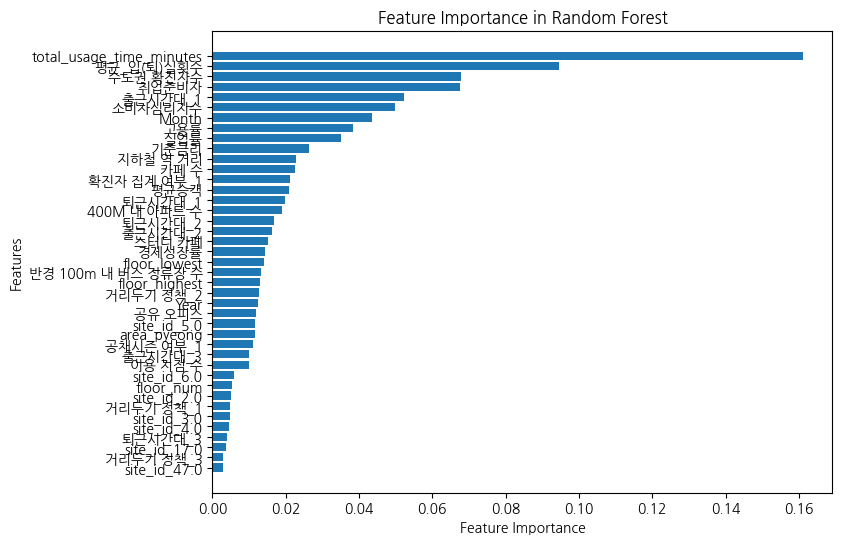

In [ ]:
# 시각화
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()  # 중요도가 큰 순으로 정렬
plt.show()

## XGBoost

### 기본

In [ ]:
# XGBoost 모델 생성
model = xgb.XGBClassifier(
    n_estimators=100,  # 트리 개수
    learning_rate=0.1, # 학습률
    max_depth=3,       # 트리의 최대 깊이
    random_state=42
)

# 4. 모델 학습
model.fit(X_train, y_train)

# 5. 테스트 데이터 예측
y_pred = model.predict(X_test)

# 6. 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.62
              precision    recall  f1-score   support

           0       0.63      0.90      0.74      1085
           1       0.52      0.18      0.26       685

    accuracy                           0.62      1770
   macro avg       0.58      0.54      0.50      1770
weighted avg       0.59      0.62      0.56      1770



### 하이퍼파라미터 튜닝

In [ ]:
# 하이퍼파라미터 최적화 함수 정의
def xgb_cv(max_depth, learning_rate, n_estimators, gamma, min_child_weight, subsample, colsample_bytree):
    model = xgb.XGBClassifier(
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
        gamma=gamma,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        eval_metric="logloss",
        random_state=42
    )
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

# Bayesian Optimization 설정
optimizer = BayesianOptimization(
    f=xgb_cv,
    pbounds={
        'max_depth': (3, 10),
        'learning_rate': (0.01, 0.3),
        'n_estimators': (50, 300),
        'gamma': (0, 5),
        'min_child_weight': (1, 10),
        'subsample': (0.6, 1.0),
        'colsample_bytree': (0.6, 1.0)
    },
    random_state=42,
    verbose=2
)

# 최적화 수행
optimizer.maximize(init_points=5, n_iter=25)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", optimizer.max)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.6132    | 0.7498    | 4.754     | 0.2223    | 7.191     | 2.404     | 89.0      | 0.6232    |
| 2         | 0.6067    | 0.9465    | 3.006     | 0.2153    | 3.144     | 9.729     | 258.1     | 0.6849    |
| 3         | 0.6035    | 0.6727    | 0.917     | 0.09823   | 6.673     | 4.888     | 122.8     | 0.8447    |
| 4         | 0.6067    | 0.6558    | 1.461     | 0.1162    | 6.192     | 8.067     | 99.92     | 0.8057    |
| 5         | 0.5892    | 0.837     | 0.2323    | 0.1862    | 4.194     | 1.585     | 287.2     | 0.9863    |
| 6         | 0.5716    | 0.8927    | 1.436     | 0.295     | 7.792     | 4.355     | 74.26     | 0.6725    |
| 7         | 0.6137    | 0.7853    | 4.132     | 0.01213   | 7.498     | 3.51      | 89.08     | 0.8953    |
| 8       

In [ ]:
# 최적의 하이퍼파라미터 추출
best_params = optimizer.max['params']

# 최적의 하이퍼파라미터로 모델 학습
best_model_XGB = xgb.XGBClassifier(
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    n_estimators=int(best_params['n_estimators']),
    gamma=best_params['gamma'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    eval_metric="logloss",
    random_state=42
)
best_model_XGB.fit(X_train, y_train)

# 각 데이터셋에 예측 적용
y_pred_train = best_model_XGB.predict(X_train)
y_pred_train_proba = best_model_XGB.predict_proba(X_train)[:, 1]  # ROC-AUC 평가를 위한 확률 값

y_pred_test = best_model_XGB.predict(X_test)
y_pred_test_proba = best_model_XGB.predict_proba(X_test)[:, 1]  # ROC-AUC 평가를 위한 확률 값

# 평가
print("정확도 (Accuracy):", accuracy_score(y_train, y_pred_train))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_train, y_pred_train))
print("ROC-AUC 점수:", roc_auc_score(y_train, y_pred_train_proba))

print("정확도 (Accuracy):", accuracy_score(y_test, y_pred_test))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_test))
print("ROC-AUC 점수:", roc_auc_score(y_test, y_pred_test_proba))

정확도 (Accuracy): 0.6546379268588036

분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.65      0.94      0.77      2530
           1       0.69      0.20      0.31      1599

    accuracy                           0.65      4129
   macro avg       0.67      0.57      0.54      4129
weighted avg       0.66      0.65      0.59      4129

ROC-AUC 점수: 0.6880940904270703
정확도 (Accuracy): 0.6225988700564972

분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.63      0.92      0.75      1085
           1       0.55      0.15      0.23       685

    accuracy                           0.62      1770
   macro avg       0.59      0.53      0.49      1770
weighted avg       0.60      0.62      0.55      1770

ROC-AUC 점수: 0.5921174610649533


## LightGBM

### 기본

In [ ]:
# LightGBM 데이터셋 생성
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 하이퍼파라미터 설정
params = {
    'objective': 'binary',       # 이진 분류
    'metric': 'binary_logloss',  # 평가 지표: 로그 손실
    'boosting_type': 'gbdt',     # 기본 부스팅 방식
    'learning_rate': 0.1,        # 학습률
    'num_leaves': 31,            # 리프 노드 개수
    'random_state': 42           # 랜덤 시드
}

# 모델 학습
num_round = 100  # Boosting 반복 횟수
bst = lgb.train(params, train_data, num_boost_round=num_round)

# 예측
y_pred_prob = bst.predict(X_test)  # 확률 예측
y_pred = (y_pred_prob > 0.5).astype(int)  # 클래스 결정

# 평가
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

Accuracy: 0.59
ROC-AUC: 0.58


### 하이퍼파라미터 튜닝

In [ ]:

# 하이퍼파라미터 최적화 함수 정의
def lgbm_cv(num_leaves, max_depth, learning_rate, n_estimators, min_child_samples, subsample, colsample_bytree):
    model = LGBMClassifier(
        num_leaves=int(num_leaves),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
        min_child_samples=int(min_child_samples),
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

# Bayesian Optimization 설정
optimizer = BayesianOptimization(
    f=lgbm_cv,
    pbounds={
        'num_leaves': (20, 50),
        'max_depth': (3, 15),
        'learning_rate': (0.01, 0.3),
        'n_estimators': (50, 300),
        'min_child_samples': (5, 30),
        'subsample': (0.6, 1.0),
        'colsample_bytree': (0.6, 1.0)
    },
    random_state=42,
    verbose=-1
)

# 최적화 수행
optimizer.maximize(init_points=5, n_iter=25)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", optimizer.max)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.5554    | 0.7498    | 0.2857    | 11.78     | 19.97     | 89.0      | 24.68     | 0.6232    |
| 2         | 0.549     | 0.9465    | 0.1843    | 11.5      | 5.515     | 292.5     | 44.97     | 0.6849    |
| 3         | 0.5737    | 0.6727    | 0.06319   | 6.651     | 18.12     | 158.0     | 28.74     | 0.8447    |
| 4         | 0.5619    | 0.6558    | 0.09472   | 7.396     | 16.4      | 246.3     | 25.99     | 0.8057    |
| 5         | 0.5734    | 0.837     | 0.02347   | 10.29     | 9.263     | 66.26     | 48.47     | 0.9863    |
| 6         | 0.5594    | 0.6562    | 0.2389    | 5.749     | 19.23     | 157.0     | 29.11     | 0.9148    |
| 7         | 0.5685    | 0.6257    | 0.0416    | 13.76     | 26.25     | 238.0     | 28.37     | 0.7991    |
| 8       

In [ ]:
# 최적의 하이퍼파라미터 추출
best_params = optimizer.max['params']

# 최적의 하이퍼파라미터로 모델 학습
best_model_LGB = LGBMClassifier(
    num_leaves=int(best_params['num_leaves']),
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    n_estimators=int(best_params['n_estimators']),
    min_child_samples=int(best_params['min_child_samples']),
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    random_state=42,
    verbose = -1
)
best_model_LGB.fit(X_train, y_train)

# 각 데이터셋에 예측 적용
y_pred_train = best_model_LGB.predict(X_train)
y_pred_train_proba = best_model_LGB.predict_proba(X_train)[:, 1]  # ROC-AUC 평가를 위한 확률 값

y_pred_test = best_model_LGB.predict(X_test)
y_pred_test_proba = best_model_LGB.predict_proba(X_test)[:, 1]  # ROC-AUC 평가를 위한 확률 값

# 평가
print("정확도 (Accuracy):", accuracy_score(y_train, y_pred_train))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_train, y_pred_train))
print("ROC-AUC 점수:", roc_auc_score(y_train, y_pred_train_proba))

print("정확도 (Accuracy):", accuracy_score(y_test, y_pred_test))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_test))
print("ROC-AUC 점수:", roc_auc_score(y_test, y_pred_test_proba))

정확도 (Accuracy): 0.7614434487769436

분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.74      0.93      0.83      2530
           1       0.82      0.49      0.61      1599

    accuracy                           0.76      4129
   macro avg       0.78      0.71      0.72      4129
weighted avg       0.77      0.76      0.74      4129

ROC-AUC 점수: 0.856594783795208
정확도 (Accuracy): 0.6112994350282486

분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.64      0.83      0.72      1085
           1       0.50      0.27      0.35       685

    accuracy                           0.61      1770
   macro avg       0.57      0.55      0.53      1770
weighted avg       0.59      0.61      0.58      1770

ROC-AUC 점수: 0.5935113861885701


## CATboost

### 기본

In [ ]:
# CatBoost 모델 생성 및 학습
model = CatBoostClassifier(
    iterations=100,          # 부스팅 반복 횟수
    learning_rate=0.1,       # 학습률
    depth=6,                 # 트리 깊이
    loss_function='Logloss', # 손실 함수
    verbose=10,              # 학습 중 출력
    random_seed=42
)
X_train, X_test, y_train, y_test = train_test_split(Cat_X, y, test_size=0.3, stratify= y, random_state=42)

categorical_features = ['출근시간대','퇴근시간대','site_id','거리두기 정책','공채시즌 여부','확진자 집계 여부']

# Pool 객체 생성
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

# 모델 학습
model.fit(train_pool)

# 테스트 데이터 예측
y_pred = model.predict(test_pool)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

0:	learn: 0.6856792	total: 17.9ms	remaining: 1.77s
10:	learn: 0.6485559	total: 260ms	remaining: 2.1s
20:	learn: 0.6354844	total: 480ms	remaining: 1.81s
30:	learn: 0.6280952	total: 646ms	remaining: 1.44s
40:	learn: 0.6198721	total: 811ms	remaining: 1.17s
50:	learn: 0.6145280	total: 977ms	remaining: 939ms
60:	learn: 0.6098799	total: 1.16s	remaining: 739ms
70:	learn: 0.6037946	total: 1.41s	remaining: 574ms
80:	learn: 0.5986954	total: 1.57s	remaining: 368ms
90:	learn: 0.5922554	total: 1.75s	remaining: 173ms
99:	learn: 0.5876259	total: 1.9s	remaining: 0us
Accuracy: 0.62
              precision    recall  f1-score   support

           0       0.63      0.90      0.74      1085
           1       0.52      0.17      0.25       685

    accuracy                           0.62      1770
   macro avg       0.57      0.53      0.50      1770
weighted avg       0.59      0.62      0.55      1770



### 하이퍼파라미터 튜닝

In [ ]:
# 2. CatBoost 평가 함수 정의
def catboost_eval(depth, learning_rate, l2_leaf_reg, bagging_temperature, border_count):
    model = CatBoostClassifier(
        iterations=100,  # 부스팅 반복 횟수
        depth=int(depth),  # 트리 깊이
        learning_rate=learning_rate,  # 학습률
        l2_leaf_reg=l2_leaf_reg,  # L2 정규화
        bagging_temperature=bagging_temperature,  # 배깅 온도
        border_count=int(border_count),  # 히스토그램 경계 개수
        loss_function='Logloss',  # 로그 손실 함수
        verbose=0,  # 출력 비활성화
        random_seed=42
    )
    model.fit(train_pool, verbose=0)
    
    # 검증 데이터에서 Log Loss 계산 (낮을수록 좋음)
    y_pred = model.predict_proba(test_pool)
    return -log_loss(y_test, y_pred)

# 3. Bayesian Optimization 설정
pbounds = {
    'depth': (4, 10),
    'learning_rate': (0.01, 0.3),
    'l2_leaf_reg': (1, 10),
    'bagging_temperature': (0, 1),
    'border_count': (32, 255)
}

optimizer = BayesianOptimization(
    f=catboost_eval,  # 평가 함수
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

# 4. 최적화 수행
optimizer.maximize(init_points=5, n_iter=25)

# 5. 최적 하이퍼파라미터 확인
print("최적 하이퍼파라미터:", optimizer.max['params'])

|   iter    |  target   | baggin... | border... |   depth   | l2_lea... | learni... |
-------------------------------------------------------------------------------------
| 1         | -0.6568   | 0.3745    | 244.0     | 8.392     | 6.388     | 0.05525   |
| 2         | -0.7019   | 0.156     | 44.95     | 9.197     | 6.41      | 0.2153    |
| 3         | -0.6571   | 0.02058   | 248.3     | 8.995     | 2.911     | 0.06273   |
| 4         | -0.6567   | 0.1834    | 99.85     | 7.149     | 4.888     | 0.09446   |
| 5         | -0.6584   | 0.6119    | 63.11     | 5.753     | 4.297     | 0.1423    |
| 6         | -0.6576   | 0.7143    | 80.56     | 5.06      | 4.225     | 0.1995    |
| 7         | -0.653    | 0.5781    | 121.8     | 4.366     | 8.649     | 0.1189    |
| 8         | -0.6596   | 0.7484    | 139.4     | 9.976     | 1.022     | 0.04069   |
| 9         | -0.6974   | 0.7725    | 219.8     | 7.426     | 1.145     | 0.2839    |
| 10        | -0.6632   | 0.2992    | 163.4     | 5.29

In [ ]:
# 최적의 하이퍼파라미터로 모델 학습
best_params = optimizer.max['params']
best_params['depth'] = int(best_params['depth'])
best_params['border_count'] = int(best_params['border_count'])

final_model = CatBoostClassifier(
    iterations=100,
    loss_function='Logloss',
    random_seed=42,
    **best_params
)

# 모델 학습
final_model.fit(train_pool)

# 각 데이터셋에 예측 적용
y_pred_train = final_model.predict(X_train)
y_pred_train_proba = final_model.predict_proba(X_train)[:, 1]  # ROC-AUC 평가를 위한 확률 값

y_pred_test = final_model.predict(X_test)
y_pred_test_proba = final_model.predict_proba(X_test)[:, 1]  # ROC-AUC 평가를 위한 확률 값

# 평가
print("정확도 (Accuracy):", accuracy_score(y_train, y_pred_train))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_train, y_pred_train))
print("ROC-AUC 점수:", roc_auc_score(y_train, y_pred_train_proba))

print("정확도 (Accuracy):", accuracy_score(y_test, y_pred_test))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_test))
print("ROC-AUC 점수:", roc_auc_score(y_test, y_pred_test_proba))

0:	learn: 0.6855744	total: 18.6ms	remaining: 1.84s
1:	learn: 0.6797746	total: 33.1ms	remaining: 1.62s
2:	learn: 0.6755705	total: 47.4ms	remaining: 1.53s
3:	learn: 0.6728962	total: 56.3ms	remaining: 1.35s
4:	learn: 0.6698559	total: 76.7ms	remaining: 1.46s
5:	learn: 0.6675238	total: 98.3ms	remaining: 1.54s
6:	learn: 0.6654985	total: 115ms	remaining: 1.53s
7:	learn: 0.6630473	total: 132ms	remaining: 1.52s
8:	learn: 0.6615683	total: 148ms	remaining: 1.5s
9:	learn: 0.6603965	total: 163ms	remaining: 1.46s
10:	learn: 0.6584862	total: 178ms	remaining: 1.44s
11:	learn: 0.6570940	total: 192ms	remaining: 1.41s
12:	learn: 0.6558899	total: 207ms	remaining: 1.39s
13:	learn: 0.6551604	total: 219ms	remaining: 1.34s
14:	learn: 0.6538440	total: 232ms	remaining: 1.31s
15:	learn: 0.6530707	total: 247ms	remaining: 1.3s
16:	learn: 0.6518830	total: 262ms	remaining: 1.28s
17:	learn: 0.6512144	total: 275ms	remaining: 1.25s
18:	learn: 0.6505383	total: 289ms	remaining: 1.23s
19:	learn: 0.6498789	total: 300ms	rem

# Feature Engineering2

## 변수 조정

- floor_num은 area_pyeong으로 대체할 수 있음
- 지하철 역 거리를 가까움(0), 멂(1)로 대체
- 평균 승객을 적음(0), 많음(1)으로 대체
- 확진자 수는 집계 여부로 대체할 수 있음.

In [ ]:
raw_data['지하철 역 거리'].unique()

array([155.5 , 266.51, 200.  , 473.67, 463.65, 183.36, 200.93, 468.03])

In [ ]:
# 매핑 조건
X['지하철역'] = X['지하철 역 거리'].apply(lambda x: 0 if x <= 200 else 1)

X['지하철역']

0       0
1       1
2       1
3       0
4       1
       ..
5894    0
5895    0
5896    0
5897    1
5898    0
Name: 지하철역, Length: 5899, dtype: int64

In [ ]:
raw_data['평균승객'].unique()

array([40019.2, 15033.9, 84609.8, 14011.7, 39912.2, 21839.4, 16720.6,
       23791.1])

In [ ]:
X['평균승객_cat'] = X['평균승객'].apply(lambda x:0 if x <= 20000 else 1)

In [ ]:
X2 = X.copy()
X2 = X2.drop(['지하철 역 거리','평균승객', 'floor_num','수도권 확진자수'], axis=1)

### 원핫인코딩

In [ ]:
one_hot_X = pd.get_dummies(X2, columns=['출근시간대','퇴근시간대','site_id','거리두기 정책','공채시즌 여부','확진자 집계 여부','지하철역','평균승객_cat'], drop_first=True, dtype=int)
one_hot_X.head()

,평균_입(퇴)실횟수,total_usage_time_minutes,이용 지점 수,area_pyeong,floor_lowest,floor_highest,반경 100m 내 버스 정류장 수,400M 내 아파트 수,카페 수,스터디 카페,...,site_id_6.0,site_id_17.0,site_id_47.0,거리두기 정책_1,거리두기 정책_2,거리두기 정책_3,공채시즌 여부_1,확진자 집계 여부_1,지하철역_1,평균승객_cat_1
0,1.0,142.344708,1,50.0,1,1.0,3.0,0.0,15.0,0.0,...,0,0,0,0,1,0,1,1,0,1
1,3.0,165.020445,1,150.0,3,4.0,1.0,5.0,10.0,9.0,...,0,0,0,0,1,0,1,1,1,0
2,2.0,230.568305,1,150.0,3,4.0,1.0,5.0,10.0,9.0,...,0,0,0,0,1,0,1,1,1,0
3,4.0,367.514980,1,100.0,2,2.0,0.0,15.0,12.0,11.0,...,0,0,0,0,1,0,1,1,0,1
4,5.0,262.037460,1,150.0,3,4.0,1.0,5.0,10.0,9.0,...,0,0,0,0,1,0,1,1,1,0


### CATboost용 인코딩

In [ ]:
cat_features = ['출근시간대','퇴근시간대','site_id','거리두기 정책','공채시즌 여부','확진자 집계 여부','지하철역','평균승객_cat','floor_lowest','floor_highest']
Cat_X = X2.copy()
for i in cat_features:
    Cat_X[i] = Cat_X[i].astype(str)

## 랜덤 포레스트

In [ ]:
# 분할
X_train, X_test, y_train, y_test = train_test_split(one_hot_X, y, stratify= y, test_size=0.3, random_state=42)

# 모델 생성
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# 모델 학습
rf_model.fit(X_train, y_train)

# 테스트 데이터 예측
y_pred = rf_model.predict(X_test)

# 정확도 계산
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.58
              precision    recall  f1-score   support

           0       0.64      0.73      0.68      1085
           1       0.45      0.35      0.39       685

    accuracy                           0.58      1770
   macro avg       0.55      0.54      0.54      1770
weighted avg       0.57      0.58      0.57      1770



In [ ]:
# 하이퍼파라미터 최적화 함수 정의
def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    # 랜덤 포레스트 모델 생성
    model = RandomForestClassifier(
        n_estimators=int(n_estimators),  # 정수형으로 변환
        max_depth=int(max_depth),       # 정수형으로 변환
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        random_state=42,
        n_jobs=-1
    )
    # 5-폴드 교차 검증의 평균 정확도를 반환
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

# Bayesian Optimization 설정
optimizer = BayesianOptimization(
    f=rf_cv,  # 최적화할 함수
    pbounds={
        'n_estimators': (10, 1000),        # 트리 개수
        'max_depth': (5, 50),            # 최대 깊이
        'min_samples_split': (2, 20),    # 내부 노드 분할 최소 샘플 수
        'min_samples_leaf': (1, 20)      # 리프 노드 최소 샘플 수
    },
    random_state=42,
    verbose=2
)

# 최적화 수행
optimizer.maximize(init_points=5, n_iter=25)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", optimizer.max)

# 최적의 하이퍼파라미터 추출
best_params = optimizer.max['params']

# 최적 하이퍼파라미터로 모델 학습
best_model_RF = RandomForestClassifier(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    min_samples_leaf=int(best_params['min_samples_leaf']),
    random_state=42,
    n_jobs=-1
)
best_model_RF.fit(X_train, y_train)

# 각 데이터셋에 예측 적용
y_pred_train = best_model_RF.predict(X_train)
y_pred_train_proba = best_model_RF.predict_proba(X_train)[:, 1]  # ROC-AUC 평가를 위한 확률 값

y_pred_test = best_model_RF.predict(X_test)
y_pred_test_proba = best_model_RF.predict_proba(X_test)[:, 1]  # ROC-AUC 평가를 위한 확률 값

# 평가
print("정확도 (Accuracy):", accuracy_score(y_train, y_pred_train))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_train, y_pred_train))
print("ROC-AUC 점수:", roc_auc_score(y_train, y_pred_train_proba))

print("정확도 (Accuracy):", accuracy_score(y_test, y_pred_test))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_test))
print("ROC-AUC 점수:", roc_auc_score(y_test, y_pred_test_proba))

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.6142    | 21.85     | 19.06     | 15.18     | 602.7     |
| 2         | 0.6038    | 12.02     | 3.964     | 3.046     | 867.5     |
| 3         | 0.6077    | 32.05     | 14.45     | 2.371     | 970.2     |
| 4         | 0.5987    | 42.46     | 5.034     | 5.273     | 191.6     |
| 5         | 0.6103    | 18.69     | 10.97     | 9.775     | 298.3     |
| 6         | 0.6132    | 22.4      | 17.81     | 17.37     | 602.9     |
| 7         | 0.6108    | 24.2      | 15.99     | 3.893     | 585.4     |
| 8         | 0.6125    | 5.727     | 18.45     | 2.854     | 613.8     |
| 9         | 0.6125    | 37.38     | 17.0      | 3.362     | 617.2     |
| 10        | 0.6123    | 23.55     | 19.8      | 13.54     | 650.8     |
| 11        | 0.5994    | 49.97     | 4.788     | 5.059     | 665.3     |
| 12        | 0.6144    | 6.8       | 

## XGB

In [ ]:
# 3. XGBoost 모델 생성
model = xgb.XGBClassifier(
    n_estimators=100,  # 트리 개수
    learning_rate=0.1, # 학습률
    max_depth=3,       # 트리의 최대 깊이
    random_state=42
)

# 4. 모델 학습
model.fit(X_train, y_train)

# 5. 테스트 데이터 예측
y_pred = model.predict(X_test)

# 6. 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.62
              precision    recall  f1-score   support

           0       0.64      0.90      0.74      1085
           1       0.53      0.18      0.27       685

    accuracy                           0.62      1770
   macro avg       0.58      0.54      0.51      1770
weighted avg       0.60      0.62      0.56      1770



In [ ]:
# 하이퍼파라미터 최적화 함수 정의
def xgb_cv(max_depth, learning_rate, n_estimators, gamma, min_child_weight, subsample, colsample_bytree):
    model = xgb.XGBClassifier(
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
        gamma=gamma,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        eval_metric="logloss",
        random_state=42
    )
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

# Bayesian Optimization 설정
optimizer = BayesianOptimization(
    f=xgb_cv,
    pbounds={
        'max_depth': (3, 10),
        'learning_rate': (0.01, 0.3),
        'n_estimators': (50, 300),
        'gamma': (0, 5),
        'min_child_weight': (1, 10),
        'subsample': (0.6, 1.0),
        'colsample_bytree': (0.6, 1.0)
    },
    random_state=42,
    verbose=2
)

# 최적화 수행
optimizer.maximize(init_points=5, n_iter=25)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", optimizer.max)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.6132    | 0.7498    | 4.754     | 0.2223    | 7.191     | 2.404     | 89.0      | 0.6232    |
| 2         | 0.606     | 0.9465    | 3.006     | 0.2153    | 3.144     | 9.729     | 258.1     | 0.6849    |
| 3         | 0.6026    | 0.6727    | 0.917     | 0.09823   | 6.673     | 4.888     | 122.8     | 0.8447    |
| 4         | 0.6072    | 0.6558    | 1.461     | 0.1162    | 6.192     | 8.067     | 99.92     | 0.8057    |
| 5         | 0.5963    | 0.837     | 0.2323    | 0.1862    | 4.194     | 1.585     | 287.2     | 0.9863    |
| 6         | 0.5994    | 0.7862    | 1.128     | 0.268     | 7.468     | 4.643     | 77.91     | 0.9007    |
| 7         | 0.5808    | 0.6257    | 0.5448    | 0.27      | 8.95      | 7.767     | 119.7     | 0.7991    |
| 8       

In [ ]:
# 최적의 하이퍼파라미터 추출
best_params = optimizer.max['params']

# 최적의 하이퍼파라미터로 모델 학습
best_model_XGB = xgb.XGBClassifier(
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    n_estimators=int(best_params['n_estimators']),
    gamma=best_params['gamma'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    eval_metric="logloss",
    random_state=42
)
best_model_XGB.fit(X_train, y_train)

# 각 데이터셋에 예측 적용
y_pred_train = best_model_XGB.predict(X_train)
y_pred_train_proba = best_model_XGB.predict_proba(X_train)[:, 1]  # ROC-AUC 평가를 위한 확률 값

y_pred_test = best_model_XGB.predict(X_test)
y_pred_test_proba = best_model_XGB.predict_proba(X_test)[:, 1]  # ROC-AUC 평가를 위한 확률 값

# 평가
print("정확도 (Accuracy):", accuracy_score(y_train, y_pred_train))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_train, y_pred_train))
print("ROC-AUC 점수:", roc_auc_score(y_train, y_pred_train_proba))

print("정확도 (Accuracy):", accuracy_score(y_test, y_pred_test))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_test))
print("ROC-AUC 점수:", roc_auc_score(y_test, y_pred_test_proba))

정확도 (Accuracy): 0.6333252603535965

분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.63      0.97      0.76      2530
           1       0.68      0.10      0.17      1599

    accuracy                           0.63      4129
   macro avg       0.66      0.54      0.47      4129
weighted avg       0.65      0.63      0.54      4129

ROC-AUC 점수: 0.6502432350258437
정확도 (Accuracy): 0.6242937853107344

분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.63      0.96      0.76      1085
           1       0.60      0.09      0.15       685

    accuracy                           0.62      1770
   macro avg       0.61      0.53      0.45      1770
weighted avg       0.62      0.62      0.52      1770

ROC-AUC 점수: 0.5962353257761781


## LGB

In [ ]:
from lightgbm import LGBMClassifier

# 하이퍼파라미터 최적화 함수 정의
def lgbm_cv(num_leaves, max_depth, learning_rate, n_estimators, min_child_samples, subsample, colsample_bytree):
    model = LGBMClassifier(
        num_leaves=int(num_leaves),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
        min_child_samples=int(min_child_samples),
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

# Bayesian Optimization 설정
optimizer = BayesianOptimization(
    f=lgbm_cv,
    pbounds={
        'num_leaves': (20, 50),
        'max_depth': (3, 15),
        'learning_rate': (0.01, 0.3),
        'n_estimators': (50, 300),
        'min_child_samples': (5, 30),
        'subsample': (0.6, 1.0),
        'colsample_bytree': (0.6, 1.0)
    },
    random_state=42,
    verbose=-1
)

# 최적화 수행
optimizer.maximize(init_points=5, n_iter=25)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", optimizer.max)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.5566    | 0.7498    | 0.2857    | 11.78     | 19.97     | 89.0      | 24.68     | 0.6232    |
| 2         | 0.5511    | 0.9465    | 0.1843    | 11.5      | 5.515     | 292.5     | 44.97     | 0.6849    |
| 3         | 0.5765    | 0.6727    | 0.06319   | 6.651     | 18.12     | 158.0     | 28.74     | 0.8447    |
| 4         | 0.5662    | 0.6558    | 0.09472   | 7.396     | 16.4      | 246.3     | 25.99     | 0.8057    |
| 5         | 0.5724    | 0.837     | 0.02347   | 10.29     | 9.263     | 66.26     | 48.47     | 0.9863    |
| 6         | 0.5566    | 0.6562    | 0.2389    | 5.749     | 19.23     | 157.0     | 29.11     | 0.9148    |
| 7         | 0.5693    | 0.6257    | 0.0416    | 13.76     | 26.25     | 238.0     | 28.37     | 0.7991    |
| 8       

In [ ]:
# 최적의 하이퍼파라미터 추출
best_params = optimizer.max['params']

# 최적의 하이퍼파라미터로 모델 학습
best_model_LGB = LGBMClassifier(
    num_leaves=int(best_params['num_leaves']),
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    n_estimators=int(best_params['n_estimators']),
    min_child_samples=int(best_params['min_child_samples']),
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    random_state=42,
    verbose = -1
)
best_model_LGB.fit(X_train, y_train)

# 각 데이터셋에 예측 적용
y_pred_train = best_model_LGB.predict(X_train)
y_pred_train_proba = best_model_LGB.predict_proba(X_train)[:, 1]  # ROC-AUC 평가를 위한 확률 값

y_pred_test = best_model_LGB.predict(X_test)
y_pred_test_proba = best_model_LGB.predict_proba(X_test)[:, 1]  # ROC-AUC 평가를 위한 확률 값

# 평가
print("정확도 (Accuracy):", accuracy_score(y_train, y_pred_train))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_train, y_pred_train))
print("ROC-AUC 점수:", roc_auc_score(y_train, y_pred_train_proba))

print("정확도 (Accuracy):", accuracy_score(y_test, y_pred_test))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_test))
print("ROC-AUC 점수:", roc_auc_score(y_test, y_pred_test_proba))

정확도 (Accuracy): 0.7597481230322112

분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.74      0.93      0.83      2530
           1       0.82      0.49      0.61      1599

    accuracy                           0.76      4129
   macro avg       0.78      0.71      0.72      4129
weighted avg       0.77      0.76      0.74      4129

ROC-AUC 점수: 0.8551649128531419
정확도 (Accuracy): 0.6090395480225989

분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.64      0.82      0.72      1085
           1       0.49      0.27      0.35       685

    accuracy                           0.61      1770
   macro avg       0.57      0.55      0.54      1770
weighted avg       0.58      0.61      0.58      1770

ROC-AUC 점수: 0.5897964950048773


## CATboost

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Cat_X, y, test_size=0.3, stratify= y, random_state=42)

categorical_features = ['출근시간대','퇴근시간대','site_id','거리두기 정책','공채시즌 여부','확진자 집계 여부','지하철역','평균승객_cat','floor_lowest','floor_highest']

# Pool 객체 생성
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

# 2. CatBoost 평가 함수 정의
def catboost_eval(depth, learning_rate, l2_leaf_reg, bagging_temperature, border_count):
    model = CatBoostClassifier(
        iterations=100,  # 부스팅 반복 횟수
        depth=int(depth),  # 트리 깊이
        learning_rate=learning_rate,  # 학습률
        l2_leaf_reg=l2_leaf_reg,  # L2 정규화
        bagging_temperature=bagging_temperature,  # 배깅 온도
        border_count=int(border_count),  # 히스토그램 경계 개수
        loss_function='Logloss',  # 로그 손실 함수
        verbose=0,  # 출력 비활성화
        random_seed=42
    )
    model.fit(train_pool, verbose=0)
    
    # 검증 데이터에서 Log Loss 계산 (낮을수록 좋음)
    y_pred = model.predict_proba(test_pool)
    return -log_loss(y_test, y_pred)

# 3. Bayesian Optimization 설정
pbounds = {
    'depth': (4, 10),
    'learning_rate': (0.01, 0.3),
    'l2_leaf_reg': (1, 10),
    'bagging_temperature': (0, 1),
    'border_count': (32, 255)
}

optimizer = BayesianOptimization(
    f=catboost_eval,  # 평가 함수
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

# 4. 최적화 수행
optimizer.maximize(init_points=5, n_iter=25)

# 5. 최적 하이퍼파라미터 확인
print("최적 하이퍼파라미터:", optimizer.max['params'])

|   iter    |  target   | baggin... | border... |   depth   | l2_lea... | learni... |
-------------------------------------------------------------------------------------
| 1         | -0.6533   | 0.3745    | 244.0     | 8.392     | 6.388     | 0.05525   |
| 2         | -0.69     | 0.156     | 44.95     | 9.197     | 6.41      | 0.2153    |
| 3         | -0.6543   | 0.02058   | 248.3     | 8.995     | 2.911     | 0.06273   |
| 4         | -0.6563   | 0.1834    | 99.85     | 7.149     | 4.888     | 0.09446   |
| 5         | -0.6512   | 0.6119    | 63.11     | 5.753     | 4.297     | 0.1423    |
| 6         | -0.6532   | 0.2688    | 76.3      | 5.481     | 3.758     | 0.171     |
| 7         | -0.7062   | 0.2111    | 225.4     | 8.969     | 1.308     | 0.2224    |
| 8         | -0.6536   | 0.5773    | 117.3     | 4.399     | 9.714     | 0.07704   |
| 9         | -0.6916   | 0.6422    | 131.5     | 8.306     | 1.168     | 0.1747    |
| 10        | -0.684    | 0.3048    | 87.66     | 9.96

In [ ]:
# 최적의 하이퍼파라미터로 모델 학습
best_params = optimizer.max['params']
best_params['depth'] = int(best_params['depth'])
best_params['border_count'] = int(best_params['border_count'])

final_model = CatBoostClassifier(
    iterations=100,
    loss_function='Logloss',
    random_seed=42,
    **best_params
)

# 모델 학습
final_model.fit(train_pool)

# 각 데이터셋에 예측 적용
y_pred_train = final_model.predict(X_train)
y_pred_train_proba = final_model.predict_proba(X_train)[:, 1]  # ROC-AUC 평가를 위한 확률 값

y_pred_test = final_model.predict(X_test)
y_pred_test_proba = final_model.predict_proba(X_test)[:, 1]  # ROC-AUC 평가를 위한 확률 값

# 평가
print("정확도 (Accuracy):", accuracy_score(y_train, y_pred_train))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_train, y_pred_train))
print("ROC-AUC 점수:", roc_auc_score(y_train, y_pred_train_proba))

print("정확도 (Accuracy):", accuracy_score(y_test, y_pred_test))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_test))
print("ROC-AUC 점수:", roc_auc_score(y_test, y_pred_test_proba))

0:	learn: 0.6837847	total: 24.8ms	remaining: 2.46s
1:	learn: 0.6763739	total: 39.5ms	remaining: 1.94s
2:	learn: 0.6719713	total: 46ms	remaining: 1.49s
3:	learn: 0.6681846	total: 58.8ms	remaining: 1.41s
4:	learn: 0.6642301	total: 70.6ms	remaining: 1.34s
5:	learn: 0.6609270	total: 83.2ms	remaining: 1.3s
6:	learn: 0.6578833	total: 95.3ms	remaining: 1.26s
7:	learn: 0.6554509	total: 108ms	remaining: 1.24s
8:	learn: 0.6536645	total: 122ms	remaining: 1.23s
9:	learn: 0.6518533	total: 134ms	remaining: 1.21s
10:	learn: 0.6507434	total: 148ms	remaining: 1.19s
11:	learn: 0.6495691	total: 162ms	remaining: 1.19s
12:	learn: 0.6485597	total: 175ms	remaining: 1.17s
13:	learn: 0.6463678	total: 190ms	remaining: 1.16s
14:	learn: 0.6450081	total: 205ms	remaining: 1.16s
15:	learn: 0.6443344	total: 221ms	remaining: 1.16s
16:	learn: 0.6434745	total: 234ms	remaining: 1.14s
17:	learn: 0.6431582	total: 248ms	remaining: 1.13s
18:	learn: 0.6423534	total: 261ms	remaining: 1.11s
19:	learn: 0.6410941	total: 274ms	rem

# Feature Engineering3

## SMOTENC 적용

In [ ]:
print(f"Original dataset shape: {Counter(y)}")  # 클래스 분포 확인

# SMOTE 적용
smote_nc = SMOTENC(categorical_features = ['출근시간대','퇴근시간대','site_id','거리두기 정책','공채시즌 여부','확진자 집계 여부','지하철역','평균승객_cat','floor_lowest','floor_highest'], random_state=42)
X_resampled, y_resampled = smote_nc.fit_resample(X2, y)

print(f"Resampled dataset shape: {Counter(y_resampled)}")  # 클래스 분포 확인

Original dataset shape: Counter({0: 3615, 1: 2284})
Resampled dataset shape: Counter({1: 3615, 0: 3615})


In [ ]:
y_resampled

0       1
1       0
2       1
3       0
4       0
       ..
7225    1
7226    1
7227    1
7228    1
7229    1
Name: is_payment, Length: 7230, dtype: int64

### 원핫인코딩

In [ ]:
one_hot_X = pd.get_dummies(X_resampled, columns=['출근시간대','퇴근시간대','site_id','거리두기 정책','공채시즌 여부','확진자 집계 여부','지하철역','평균승객_cat'], drop_first=True, dtype=int)
one_hot_X

,평균_입(퇴)실횟수,total_usage_time_minutes,이용 지점 수,area_pyeong,floor_lowest,floor_highest,반경 100m 내 버스 정류장 수,400M 내 아파트 수,카페 수,스터디 카페,...,site_id_6.0,site_id_17.0,site_id_47.0,거리두기 정책_1,거리두기 정책_2,거리두기 정책_3,공채시즌 여부_1,확진자 집계 여부_1,지하철역_1,평균승객_cat_1
0,1.000000,142.344708,1,50.0,1,1.0,3.0,0.0,15.0,0.0,...,0,0,0,0,1,0,1,1,0,1
1,3.000000,165.020445,1,150.0,3,4.0,1.0,5.0,10.0,9.0,...,0,0,0,0,1,0,1,1,1,0
2,2.000000,230.568305,1,150.0,3,4.0,1.0,5.0,10.0,9.0,...,0,0,0,0,1,0,1,1,1,0
3,4.000000,367.514980,1,100.0,2,2.0,0.0,15.0,12.0,11.0,...,0,0,0,0,1,0,1,1,0,1
4,5.000000,262.037460,1,150.0,3,4.0,1.0,5.0,10.0,9.0,...,0,0,0,0,1,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7225,4.308383,602.182092,1,150.0,3,4.0,2.0,9.0,8.0,0.0,...,0,0,0,1,0,0,0,1,1,0
7226,1.000000,174.257335,1,100.0,2,2.0,0.0,15.0,12.0,11.0,...,0,0,0,0,0,1,1,1,0,1
7227,4.161848,322.460697,1,100.0,3,3.0,1.0,1.0,7.0,2.0,...,0,0,0,1,0,0,0,1,1,0
7228,1.142645,178.000966,1,150.0,3,4.0,1.0,5.0,10.0,9.0,...,0,0,0,0,0,1,0,1,1,0


### CATboost용 인코딩

In [ ]:
cat_features = ['출근시간대','퇴근시간대','site_id','거리두기 정책','공채시즌 여부','확진자 집계 여부','지하철역','평균승객_cat','floor_lowest','floor_highest']
Cat_X = X_resampled.copy()
for i in cat_features:
    Cat_X[i] = Cat_X[i].astype(str)

## 랜덤 포레스트

In [ ]:
# 분할
X_train, X_test, y_train, y_test = train_test_split(one_hot_X, y_resampled, stratify= y_resampled, test_size=0.3, random_state=42)

# 모델 생성
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# 모델 학습
rf_model.fit(X_train, y_train)

# 테스트 데이터 예측
y_pred = rf_model.predict(X_test)

# 정확도 계산
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.66
              precision    recall  f1-score   support

           0       0.64      0.71      0.68      1085
           1       0.68      0.61      0.64      1084

    accuracy                           0.66      2169
   macro avg       0.66      0.66      0.66      2169
weighted avg       0.66      0.66      0.66      2169



In [ ]:
# 하이퍼파라미터 최적화 함수 정의
def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    # 랜덤 포레스트 모델 생성
    model = RandomForestClassifier(
        n_estimators=int(n_estimators),  # 정수형으로 변환
        max_depth=int(max_depth),       # 정수형으로 변환
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        random_state=42,
        n_jobs=-1
    )
    # 5-폴드 교차 검증의 평균 정확도를 반환
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

# Bayesian Optimization 설정
optimizer = BayesianOptimization(
    f=rf_cv,  # 최적화할 함수
    pbounds={
        'n_estimators': (10, 1000),        # 트리 개수
        'max_depth': (5, 50),            # 최대 깊이
        'min_samples_split': (2, 20),    # 내부 노드 분할 최소 샘플 수
        'min_samples_leaf': (1, 20)      # 리프 노드 최소 샘플 수
    },
    random_state=42,
    verbose=2
)

# 최적화 수행
optimizer.maximize(init_points=5, n_iter=25)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", optimizer.max)

# 최적의 하이퍼파라미터 추출
best_params = optimizer.max['params']

# 최적 하이퍼파라미터로 모델 학습
best_model_RF = RandomForestClassifier(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    min_samples_leaf=int(best_params['min_samples_leaf']),
    random_state=42,
    n_jobs=-1
)
best_model_RF.fit(X_train, y_train)

# 각 데이터셋에 예측 적용
y_pred_train = best_model_RF.predict(X_train)
y_pred_train_proba = best_model_RF.predict_proba(X_train)[:, 1]  # ROC-AUC 평가를 위한 확률 값

y_pred_test = best_model_RF.predict(X_test)
y_pred_test_proba = best_model_RF.predict_proba(X_test)[:, 1]  # ROC-AUC 평가를 위한 확률 값

# 평가
print("정확도 (Accuracy):", accuracy_score(y_train, y_pred_train))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_train, y_pred_train))
print("ROC-AUC 점수:", roc_auc_score(y_train, y_pred_train_proba))

print("정확도 (Accuracy):", accuracy_score(y_test, y_pred_test))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_test))
print("ROC-AUC 점수:", roc_auc_score(y_test, y_pred_test_proba))

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.627     | 21.85     | 19.06     | 15.18     | 602.7     |
| 2         | 0.6517    | 12.02     | 3.964     | 3.046     | 867.5     |
| 3         | 0.6327    | 32.05     | 14.45     | 2.371     | 970.2     |
| 4         | 0.6449    | 42.46     | 5.034     | 5.273     | 191.6     |
| 5         | 0.6434    | 18.69     | 10.97     | 9.775     | 298.3     |
| 6         | 0.6471    | 12.01     | 6.121     | 3.797     | 866.5     |
| 7         | 0.6368    | 8.408     | 2.056     | 5.196     | 870.8     |
| 8         | 0.6491    | 16.92     | 3.695     | 5.531     | 869.1     |
| 9         | 0.6495    | 12.47     | 1.483     | 8.251     | 862.5     |
| 10        | 0.6475    | 12.31     | 6.755     | 11.87     | 863.1     |
| 11        | 0.6489    | 18.21     | 5.66      | 5.192     | 864.4     |
| 12        | 0.6544    | 16.11     | 

## XGB

In [ ]:
# 3. XGBoost 모델 생성
model = xgb.XGBClassifier(
    n_estimators=100,  # 트리 개수
    learning_rate=0.1, # 학습률
    max_depth=3,       # 트리의 최대 깊이
    random_state=42
)

# 4. 모델 학습
model.fit(X_train, y_train)

# 5. 테스트 데이터 예측
y_pred = model.predict(X_test)

# 6. 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.67
              precision    recall  f1-score   support

           0       0.64      0.75      0.69      1085
           1       0.70      0.59      0.64      1084

    accuracy                           0.67      2169
   macro avg       0.67      0.67      0.66      2169
weighted avg       0.67      0.67      0.66      2169



In [ ]:
# 하이퍼파라미터 최적화 함수 정의
def xgb_cv(max_depth, learning_rate, n_estimators, gamma, min_child_weight, subsample, colsample_bytree):
    model = xgb.XGBClassifier(
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
        gamma=gamma,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        eval_metric="logloss",
        random_state=42
    )
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

# Bayesian Optimization 설정
optimizer = BayesianOptimization(
    f=xgb_cv,
    pbounds={
        'max_depth': (3, 10),
        'learning_rate': (0.01, 0.3),
        'n_estimators': (50, 300),
        'gamma': (0, 5),
        'min_child_weight': (1, 10),
        'subsample': (0.6, 1.0),
        'colsample_bytree': (0.6, 1.0)
    },
    random_state=42,
    verbose=2
)

# 최적화 수행
optimizer.maximize(init_points=5, n_iter=25)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", optimizer.max)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.6408    | 0.7498    | 4.754     | 0.2223    | 7.191     | 2.404     | 89.0      | 0.6232    |
| 2         | 0.6518    | 0.9465    | 3.006     | 0.2153    | 3.144     | 9.729     | 258.1     | 0.6849    |
| 3         | 0.6574    | 0.6727    | 0.917     | 0.09823   | 6.673     | 4.888     | 122.8     | 0.8447    |
| 4         | 0.656     | 0.6558    | 1.461     | 0.1162    | 6.192     | 8.067     | 99.92     | 0.8057    |
| 5         | 0.659     | 0.837     | 0.2323    | 0.1862    | 4.194     | 1.585     | 287.2     | 0.9863    |
| 6         | 0.6426    | 0.6374    | 1.974     | 0.1487    | 7.705     | 6.886     | 276.6     | 0.9355    |
| 7         | 0.6507    | 0.6257    | 0.5448    | 0.27      | 8.95      | 7.767     | 119.7     | 0.7991    |
| 8       

In [ ]:
# 최적의 하이퍼파라미터 추출
best_params = optimizer.max['params']

# 최적의 하이퍼파라미터로 모델 학습
best_model_XGB = xgb.XGBClassifier(
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    n_estimators=int(best_params['n_estimators']),
    gamma=best_params['gamma'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    eval_metric="logloss",
    random_state=42
)
best_model_XGB.fit(X_train, y_train)

# 각 데이터셋에 예측 적용
y_pred_train = best_model_XGB.predict(X_train)
y_pred_train_proba = best_model_XGB.predict_proba(X_train)[:, 1]  # ROC-AUC 평가를 위한 확률 값

y_pred_test = best_model_XGB.predict(X_test)
y_pred_test_proba = best_model_XGB.predict_proba(X_test)[:, 1]  # ROC-AUC 평가를 위한 확률 값

# 평가
print("정확도 (Accuracy):", accuracy_score(y_train, y_pred_train))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_train, y_pred_train))
print("ROC-AUC 점수:", roc_auc_score(y_train, y_pred_train_proba))

print("정확도 (Accuracy):", accuracy_score(y_test, y_pred_test))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_test))
print("ROC-AUC 점수:", roc_auc_score(y_test, y_pred_test_proba))

정확도 (Accuracy): 0.7577553843114009

분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.72      0.85      0.78      2530
           1       0.82      0.67      0.73      2531

    accuracy                           0.76      5061
   macro avg       0.77      0.76      0.76      5061
weighted avg       0.77      0.76      0.76      5061

ROC-AUC 점수: 0.8440516254569816
정확도 (Accuracy): 0.6698939603503918

분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.64      0.76      0.70      1085
           1       0.71      0.57      0.64      1084

    accuracy                           0.67      2169
   macro avg       0.68      0.67      0.67      2169
weighted avg       0.68      0.67      0.67      2169

ROC-AUC 점수: 0.7346944241331814


## LGB

In [ ]:
# 하이퍼파라미터 최적화 함수 정의
def lgbm_cv(num_leaves, max_depth, learning_rate, n_estimators, min_child_samples, subsample, colsample_bytree):
    model = LGBMClassifier(
        num_leaves=int(num_leaves),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
        min_child_samples=int(min_child_samples),
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

# Bayesian Optimization 설정
optimizer = BayesianOptimization(
    f=lgbm_cv,
    pbounds={
        'num_leaves': (20, 50),
        'max_depth': (3, 15),
        'learning_rate': (0.01, 0.3),
        'n_estimators': (50, 300),
        'min_child_samples': (5, 30),
        'subsample': (0.6, 1.0),
        'colsample_bytree': (0.6, 1.0)
    },
    random_state=42,
    verbose=-1
)

# 최적화 수행
optimizer.maximize(init_points=5, n_iter=25)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", optimizer.max)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.7205    | 0.7498    | 0.2857    | 11.78     | 19.97     | 89.0      | 24.68     | 0.6232    |
| 2         | 0.7212    | 0.9465    | 0.1843    | 11.5      | 5.515     | 292.5     | 44.97     | 0.6849    |
| 3         | 0.7308    | 0.6727    | 0.06319   | 6.651     | 18.12     | 158.0     | 28.74     | 0.8447    |
| 4         | 0.7293    | 0.6558    | 0.09472   | 7.396     | 16.4      | 246.3     | 25.99     | 0.8057    |
| 5         | 0.7209    | 0.837     | 0.02347   | 10.29     | 9.263     | 66.26     | 48.47     | 0.9863    |
| 6         | 0.7249    | 0.7228    | 0.0202    | 6.878     | 18.6      | 187.9     | 30.7      | 0.7789    |
| 7         | 0.7293    | 0.6166    | 0.1406    | 7.175     | 19.27     | 157.1     | 28.43     | 0.8644    |
| 8       

In [ ]:
# 최적의 하이퍼파라미터 추출
best_params = optimizer.max['params']

# 최적의 하이퍼파라미터로 모델 학습
best_model_LGB = LGBMClassifier(
    num_leaves=int(best_params['num_leaves']),
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    n_estimators=int(best_params['n_estimators']),
    min_child_samples=int(best_params['min_child_samples']),
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    random_state=42,
    verbose = -1
)
best_model_LGB.fit(X_train, y_train)

# 각 데이터셋에 예측 적용
y_pred_train = best_model_LGB.predict(X_train)
y_pred_train_proba = best_model_LGB.predict_proba(X_train)[:, 1]  # ROC-AUC 평가를 위한 확률 값

y_pred_test = best_model_LGB.predict(X_test)
y_pred_test_proba = best_model_LGB.predict_proba(X_test)[:, 1]  # ROC-AUC 평가를 위한 확률 값

# 평가
print("정확도 (Accuracy):", accuracy_score(y_train, y_pred_train))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_train, y_pred_train))
print("ROC-AUC 점수:", roc_auc_score(y_train, y_pred_train_proba))

print("정확도 (Accuracy):", accuracy_score(y_test, y_pred_test))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_test))
print("ROC-AUC 점수:", roc_auc_score(y_test, y_pred_test_proba))

정확도 (Accuracy): 0.8028057696107489

분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.76      0.89      0.82      2530
           1       0.86      0.72      0.78      2531

    accuracy                           0.80      5061
   macro avg       0.81      0.80      0.80      5061
weighted avg       0.81      0.80      0.80      5061

ROC-AUC 점수: 0.8948027072990569
정확도 (Accuracy): 0.6804979253112033

분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.65      0.77      0.71      1085
           1       0.72      0.59      0.65      1084

    accuracy                           0.68      2169
   macro avg       0.69      0.68      0.68      2169
weighted avg       0.69      0.68      0.68      2169

ROC-AUC 점수: 0.7446511469722992


## CATboost

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Cat_X, y_resampled, test_size=0.3, stratify= y_resampled, random_state=42)

categorical_features = ['출근시간대','퇴근시간대','site_id','거리두기 정책','공채시즌 여부','확진자 집계 여부','지하철역','평균승객_cat', 'floor_lowest','floor_highest']

# Pool 객체 생성
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

# 2. CatBoost 평가 함수 정의
def catboost_eval(depth, learning_rate, l2_leaf_reg, bagging_temperature, border_count):
    model = CatBoostClassifier(
        iterations=100,  # 부스팅 반복 횟수
        depth=int(depth),  # 트리 깊이
        learning_rate=learning_rate,  # 학습률
        l2_leaf_reg=l2_leaf_reg,  # L2 정규화
        bagging_temperature=bagging_temperature,  # 배깅 온도
        border_count=int(border_count),  # 히스토그램 경계 개수
        loss_function='Logloss',  # 로그 손실 함수
        verbose=0,  # 출력 비활성화
        random_seed=42
    )
    model.fit(train_pool, verbose=0)
    
    # 검증 데이터에서 Log Loss 계산 (낮을수록 좋음)
    y_pred = model.predict_proba(test_pool)
    return -log_loss(y_test, y_pred)

# 3. Bayesian Optimization 설정
pbounds = {
    'depth': (4, 10),
    'learning_rate': (0.01, 0.3),
    'l2_leaf_reg': (1, 10),
    'bagging_temperature': (0, 1),
    'border_count': (32, 255)
}

optimizer = BayesianOptimization(
    f=catboost_eval,  # 평가 함수
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

# 4. 최적화 수행
optimizer.maximize(init_points=5, n_iter=25)

# 5. 최적 하이퍼파라미터 확인
print("최적 하이퍼파라미터:", optimizer.max['params'])

|   iter    |  target   | baggin... | border... |   depth   | l2_lea... | learni... |
-------------------------------------------------------------------------------------
| 1         | -0.6033   | 0.3745    | 244.0     | 8.392     | 6.388     | 0.05525   |
| 2         | -0.6031   | 0.156     | 44.95     | 9.197     | 6.41      | 0.2153    |
| 3         | -0.5981   | 0.02058   | 248.3     | 8.995     | 2.911     | 0.06273   |
| 4         | -0.5923   | 0.1834    | 99.85     | 7.149     | 4.888     | 0.09446   |
| 5         | -0.5862   | 0.6119    | 63.11     | 5.753     | 4.297     | 0.1423    |
| 6         | -0.5888   | 0.8792    | 68.23     | 4.386     | 3.423     | 0.186     |
| 7         | -0.5864   | 0.7021    | 66.57     | 9.773     | 9.967     | 0.198     |
| 8         | -0.6122   | 0.5113    | 82.72     | 9.638     | 9.729     | 0.2542    |
| 9         | -0.5722   | 0.5619    | 59.48     | 4.066     | 9.821     | 0.2952    |
| 10        | -0.5903   | 0.9974    | 56.49     | 8.19

In [ ]:
# 최적의 하이퍼파라미터로 모델 학습
best_params = optimizer.max['params']
best_params['depth'] = int(best_params['depth'])
best_params['border_count'] = int(best_params['border_count'])

final_model = CatBoostClassifier(
    iterations=100,
    loss_function='Logloss',
    random_seed=42,
    **best_params
)

# 모델 학습
final_model.fit(train_pool)

# 각 데이터셋에 예측 적용
y_pred_train = final_model.predict(X_train)
y_pred_train_proba = final_model.predict_proba(X_train)[:, 1]  # ROC-AUC 평가를 위한 확률 값

y_pred_test = final_model.predict(X_test)
y_pred_test_proba = final_model.predict_proba(X_test)[:, 1]  # ROC-AUC 평가를 위한 확률 값

# 평가
print("정확도 (Accuracy):", accuracy_score(y_train, y_pred_train))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_train, y_pred_train))
print("ROC-AUC 점수:", roc_auc_score(y_train, y_pred_train_proba))

print("정확도 (Accuracy):", accuracy_score(y_test, y_pred_test))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_test))
print("ROC-AUC 점수:", roc_auc_score(y_test, y_pred_test_proba))

0:	learn: 0.6779329	total: 36.2ms	remaining: 3.59s
1:	learn: 0.6737490	total: 88.3ms	remaining: 4.33s
2:	learn: 0.6634722	total: 121ms	remaining: 3.91s
3:	learn: 0.6504778	total: 157ms	remaining: 3.76s
4:	learn: 0.6424938	total: 211ms	remaining: 4.01s
5:	learn: 0.6392384	total: 268ms	remaining: 4.2s
6:	learn: 0.6349687	total: 309ms	remaining: 4.11s
7:	learn: 0.6324886	total: 347ms	remaining: 3.99s
8:	learn: 0.6313412	total: 386ms	remaining: 3.9s
9:	learn: 0.6262752	total: 427ms	remaining: 3.84s
10:	learn: 0.6232959	total: 466ms	remaining: 3.77s
11:	learn: 0.6226421	total: 507ms	remaining: 3.72s
12:	learn: 0.6208259	total: 551ms	remaining: 3.69s
13:	learn: 0.6198907	total: 593ms	remaining: 3.65s
14:	learn: 0.6176592	total: 638ms	remaining: 3.62s
15:	learn: 0.6131517	total: 677ms	remaining: 3.56s
16:	learn: 0.6104892	total: 717ms	remaining: 3.5s
17:	learn: 0.6089155	total: 756ms	remaining: 3.44s
18:	learn: 0.6040029	total: 797ms	remaining: 3.4s
19:	learn: 0.6026519	total: 837ms	remaining

# Feature Engineering4

## 23년 5월부터만 사용해보기

In [ ]:
cond = (raw_data['Year'] == 2023) & (raw_data['Month'] > 4)

data_2305 = raw_data[cond]
data_2305

,출근시간대,퇴근시간대,평균_입(퇴)실횟수,site_id,total_usage_time_minutes,이용 지점 수,area_pyeong,floor_num,floor_lowest,floor_highest,...,경제성장률,기준금리,취업준비자,고용률,실업률,공채시즌 여부,확진자 집계 여부,is_payment,Year,Month
4431,3,1,2.0,3.0,285.695796,1,150.0,2.0,3,4,...,1.4,3.5,679.0,69.9,2.7,1,1,1,2023,5
4432,0,0,4.5,47.0,391.012098,1,50.0,1.0,0,-1,...,1.4,3.5,679.0,69.9,2.7,1,1,1,2023,5
4433,0,2,1.5,2.0,893.236125,1,100.0,1.0,2,2,...,1.4,3.5,679.0,69.9,2.7,1,1,0,2023,5
4434,0,1,8.0,6.0,864.779587,1,150.0,2.0,0,1,...,1.4,3.5,679.0,69.9,2.7,1,1,0,2023,5
4435,0,0,4.0,6.0,278.990516,1,150.0,2.0,0,1,...,1.4,3.5,679.0,69.9,2.7,1,1,0,2023,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5894,2,1,1.0,2.0,180.000000,1,100.0,1.0,2,2,...,1.4,3.5,675.0,69.9,2.7,0,1,1,2023,6
5895,2,1,1.0,2.0,180.000000,1,100.0,1.0,2,2,...,1.4,3.5,675.0,69.9,2.7,0,1,0,2023,6
5896,1,1,1.0,2.0,180.000000,1,100.0,1.0,2,2,...,1.4,3.5,676.0,69.6,2.0,0,1,1,2023,8
5897,1,1,1.0,3.0,180.000000,1,150.0,2.0,3,4,...,1.4,3.5,676.0,69.6,2.0,0,1,0,2023,8


In [ ]:
features = data_2305.columns.to_list()
features.remove('is_payment')
X4 = data_2305[features]
y4 = data_2305['is_payment']

In [ ]:
# Feature Engineering2 적용
X4['지하철역'] = X4['지하철 역 거리'].apply(lambda x: 0 if x <= 200 else 1)
X4['평균승객_cat'] = X4['평균승객'].apply(lambda x:0 if x <= 20000 else 1)
X4 = X4.drop(['지하철 역 거리','평균승객', 'floor_num','수도권 확진자수'], axis=1)

In [ ]:
# SMOTENC 적용
print(f"Original dataset shape: {Counter(y4)}")  # 클래스 분포 확인

smote_nc = SMOTENC(categorical_features = ['출근시간대','퇴근시간대','site_id','거리두기 정책','공채시즌 여부','확진자 집계 여부','지하철역','평균승객_cat','floor_lowest','floor_highest'], random_state=42)
X_resampled, y_resampled = smote_nc.fit_resample(X4, y4)

print(f"Resampled dataset shape: {Counter(y_resampled)}")  # 클래스 분포 확인

Original dataset shape: Counter({0: 977, 1: 456})
Resampled dataset shape: Counter({1: 977, 0: 977})


### 원핫인코딩

In [ ]:
one_hot_X = pd.get_dummies(X_resampled, columns=['출근시간대','퇴근시간대','site_id','거리두기 정책','공채시즌 여부','확진자 집계 여부','지하철역','평균승객_cat'], drop_first=True, dtype=int)
one_hot_X

,평균_입(퇴)실횟수,total_usage_time_minutes,이용 지점 수,area_pyeong,floor_lowest,floor_highest,반경 100m 내 버스 정류장 수,400M 내 아파트 수,카페 수,스터디 카페,...,site_id_3.0,site_id_4.0,site_id_5.0,site_id_6.0,site_id_17.0,site_id_47.0,공채시즌 여부_1,확진자 집계 여부_1,지하철역_1,평균승객_cat_1
0,2.000000,285.695796,1,150.000000,3,4,1.000000,5.000000,10.000000,9.000000,...,1,0,0,0,0,0,1,1,1,0
1,4.500000,391.012098,1,50.000000,0,-1,2.000000,1.000000,7.000000,0.000000,...,0,0,0,0,0,1,1,1,1,1
2,1.500000,893.236125,1,100.000000,2,2,0.000000,15.000000,12.000000,11.000000,...,0,0,0,0,0,0,1,1,0,1
3,8.000000,864.779587,1,150.000000,0,1,2.000000,9.000000,8.000000,0.000000,...,0,0,0,1,0,0,1,1,0,1
4,4.000000,278.990516,1,150.000000,0,1,2.000000,9.000000,8.000000,0.000000,...,0,0,0,1,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1949,3.734015,889.626583,1,150.000000,3,1,1.200584,5.802336,9.598832,7.194743,...,0,0,1,0,0,0,0,1,1,1
1950,2.263259,112.526590,1,150.000000,3,1,1.694696,10.557572,10.694696,7.610607,...,0,0,0,1,0,0,1,0,1,1
1951,2.636073,287.830730,1,50.000000,1,1,1.000000,9.000000,6.000000,0.000000,...,0,0,0,0,0,0,0,1,1,1
1952,1.000000,152.047642,1,100.000000,2,2,0.000000,15.000000,12.000000,11.000000,...,0,0,0,0,0,0,0,1,0,1


### CATboost용 인코딩

In [ ]:
cat_features = ['출근시간대','퇴근시간대','site_id','거리두기 정책','공채시즌 여부','확진자 집계 여부','지하철역','평균승객_cat','floor_lowest','floor_highest']
Cat_X = X_resampled.copy()
for i in cat_features:
    Cat_X[i] = Cat_X[i].astype(str)

## 랜덤 포레스트

In [ ]:
# 분할
X_train, X_test, y_train, y_test = train_test_split(one_hot_X, y_resampled, stratify= y_resampled, test_size=0.3, random_state=42)

# 모델 생성
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# 모델 학습
rf_model.fit(X_train, y_train)

# 테스트 데이터 예측
y_pred = rf_model.predict(X_test)

# 정확도 계산
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.74
              precision    recall  f1-score   support

           0       0.71      0.82      0.76       294
           1       0.78      0.66      0.71       293

    accuracy                           0.74       587
   macro avg       0.74      0.74      0.74       587
weighted avg       0.74      0.74      0.74       587



In [ ]:
# 하이퍼파라미터 최적화 함수 정의
def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    # 랜덤 포레스트 모델 생성
    model = RandomForestClassifier(
        n_estimators=int(n_estimators),  # 정수형으로 변환
        max_depth=int(max_depth),       # 정수형으로 변환
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        random_state=42,
        n_jobs=-1
    )
    # 5-폴드 교차 검증의 평균 정확도를 반환
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

# Bayesian Optimization 설정
optimizer = BayesianOptimization(
    f=rf_cv,  # 최적화할 함수
    pbounds={
        'n_estimators': (10, 1000),        # 트리 개수
        'max_depth': (5, 50),            # 최대 깊이
        'min_samples_split': (2, 20),    # 내부 노드 분할 최소 샘플 수
        'min_samples_leaf': (1, 20)      # 리프 노드 최소 샘플 수
    },
    random_state=42,
    verbose=2
)

# 최적화 수행
optimizer.maximize(init_points=5, n_iter=25)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", optimizer.max)

# 최적의 하이퍼파라미터 추출
best_params = optimizer.max['params']

# 최적 하이퍼파라미터로 모델 학습
best_model_RF = RandomForestClassifier(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    min_samples_leaf=int(best_params['min_samples_leaf']),
    random_state=42,
    n_jobs=-1
)
best_model_RF.fit(X_train, y_train)

# 각 데이터셋에 예측 적용
y_pred_train = best_model_RF.predict(X_train)
y_pred_train_proba = best_model_RF.predict_proba(X_train)[:, 1]  # ROC-AUC 평가를 위한 확률 값

y_pred_test = best_model_RF.predict(X_test)
y_pred_test_proba = best_model_RF.predict_proba(X_test)[:, 1]  # ROC-AUC 평가를 위한 확률 값

# 평가
print("정확도 (Accuracy):", accuracy_score(y_train, y_pred_train))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_train, y_pred_train))
print("ROC-AUC 점수:", roc_auc_score(y_train, y_pred_train_proba))

print("정확도 (Accuracy):", accuracy_score(y_test, y_pred_test))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_test))
print("ROC-AUC 점수:", roc_auc_score(y_test, y_pred_test_proba))

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.7234    | 21.85     | 19.06     | 15.18     | 602.7     |
| 2         | 0.7395    | 12.02     | 3.964     | 3.046     | 867.5     |
| 3         | 0.7278    | 32.05     | 14.45     | 2.371     | 970.2     |
| 4         | 0.7366    | 42.46     | 5.034     | 5.273     | 191.6     |
| 5         | 0.7293    | 18.69     | 10.97     | 9.775     | 298.3     |
| 6         | 0.7366    | 12.01     | 6.121     | 3.797     | 866.5     |
| 7         | 0.7417    | 8.408     | 2.056     | 5.196     | 870.8     |
| 8         | 0.7468    | 11.76     | 3.096     | 11.31     | 882.7     |
| 9         | 0.7381    | 20.35     | 4.667     | 3.176     | 889.1     |
| 10        | 0.7498    | 15.99     | 1.106     | 19.09     | 882.5     |
| 11        | 0.7468    | 11.67     | 1.472     | 18.07     | 892.5     |
| 12        | 0.7483    | 35.14     | 

## XGB

In [ ]:
# 3. XGBoost 모델 생성
model = xgb.XGBClassifier(
    n_estimators=100,  # 트리 개수
    learning_rate=0.1, # 학습률
    max_depth=3,       # 트리의 최대 깊이
    random_state=42
)

# 4. 모델 학습
model.fit(X_train, y_train)

# 5. 테스트 데이터 예측
y_pred = model.predict(X_test)

# 6. 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.74
              precision    recall  f1-score   support

           0       0.70      0.84      0.76       294
           1       0.80      0.65      0.71       293

    accuracy                           0.74       587
   macro avg       0.75      0.74      0.74       587
weighted avg       0.75      0.74      0.74       587



In [ ]:
# 하이퍼파라미터 최적화 함수 정의
def xgb_cv(max_depth, learning_rate, n_estimators, gamma, min_child_weight, subsample, colsample_bytree):
    model = xgb.XGBClassifier(
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
        gamma=gamma,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        eval_metric="logloss",
        random_state=42
    )
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

# Bayesian Optimization 설정
optimizer = BayesianOptimization(
    f=xgb_cv,
    pbounds={
        'max_depth': (3, 10),
        'learning_rate': (0.01, 0.3),
        'n_estimators': (50, 300),
        'gamma': (0, 5),
        'min_child_weight': (1, 10),
        'subsample': (0.6, 1.0),
        'colsample_bytree': (0.6, 1.0)
    },
    random_state=42,
    verbose=2
)

# 최적화 수행
optimizer.maximize(init_points=5, n_iter=25)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", optimizer.max)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.7256    | 0.7498    | 4.754     | 0.2223    | 7.191     | 2.404     | 89.0      | 0.6232    |
| 2         | 0.7308    | 0.9465    | 3.006     | 0.2153    | 3.144     | 9.729     | 258.1     | 0.6849    |
| 3         | 0.7388    | 0.6727    | 0.917     | 0.09823   | 6.673     | 4.888     | 122.8     | 0.8447    |
| 4         | 0.7373    | 0.6558    | 1.461     | 0.1162    | 6.192     | 8.067     | 99.92     | 0.8057    |
| 5         | 0.7366    | 0.837     | 0.2323    | 0.1862    | 4.194     | 1.585     | 287.2     | 0.9863    |
| 6         | 0.7344    | 0.6374    | 1.974     | 0.1487    | 7.705     | 6.886     | 276.6     | 0.9355    |
| 7         | 0.7257    | 0.6257    | 0.5448    | 0.27      | 8.95      | 7.767     | 119.7     | 0.7991    |
| 8       

In [ ]:
# 최적의 하이퍼파라미터 추출
best_params = optimizer.max['params']

# 최적의 하이퍼파라미터로 모델 학습
best_model_XGB = xgb.XGBClassifier(
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    n_estimators=int(best_params['n_estimators']),
    gamma=best_params['gamma'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    eval_metric="logloss",
    random_state=42
)
best_model_XGB.fit(X_train, y_train)

# 각 데이터셋에 예측 적용
y_pred_train = best_model_XGB.predict(X_train)
y_pred_train_proba = best_model_XGB.predict_proba(X_train)[:, 1]  # ROC-AUC 평가를 위한 확률 값

y_pred_test = best_model_XGB.predict(X_test)
y_pred_test_proba = best_model_XGB.predict_proba(X_test)[:, 1]  # ROC-AUC 평가를 위한 확률 값

# 평가
print("정확도 (Accuracy):", accuracy_score(y_train, y_pred_train))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_train, y_pred_train))
print("ROC-AUC 점수:", roc_auc_score(y_train, y_pred_train_proba))

print("정확도 (Accuracy):", accuracy_score(y_test, y_pred_test))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_test))
print("ROC-AUC 점수:", roc_auc_score(y_test, y_pred_test_proba))

정확도 (Accuracy): 0.9290416971470373

분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.90      0.97      0.93       683
           1       0.97      0.89      0.93       684

    accuracy                           0.93      1367
   macro avg       0.93      0.93      0.93      1367
weighted avg       0.93      0.93      0.93      1367

ROC-AUC 점수: 0.9815763787213274
정확도 (Accuracy): 0.7427597955706985

분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.71      0.81      0.76       294
           1       0.78      0.68      0.72       293

    accuracy                           0.74       587
   macro avg       0.75      0.74      0.74       587
weighted avg       0.75      0.74      0.74       587

ROC-AUC 점수: 0.8051415105291264


## LGB

In [ ]:
# 하이퍼파라미터 최적화 함수 정의
def lgbm_cv(num_leaves, max_depth, learning_rate, n_estimators, min_child_samples, subsample, colsample_bytree):
    model = LGBMClassifier(
        num_leaves=int(num_leaves),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
        min_child_samples=int(min_child_samples),
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

# Bayesian Optimization 설정
optimizer = BayesianOptimization(
    f=lgbm_cv,
    pbounds={
        'num_leaves': (20, 50),
        'max_depth': (3, 15),
        'learning_rate': (0.01, 0.3),
        'n_estimators': (50, 300),
        'min_child_samples': (5, 30),
        'subsample': (0.6, 1.0),
        'colsample_bytree': (0.6, 1.0)
    },
    random_state=42,
    verbose=-1
)

# 최적화 수행
optimizer.maximize(init_points=5, n_iter=25)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", optimizer.max)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.7997    | 0.7498    | 0.2857    | 11.78     | 19.97     | 89.0      | 24.68     | 0.6232    |
| 2         | 0.796     | 0.9465    | 0.1843    | 11.5      | 5.515     | 292.5     | 44.97     | 0.6849    |
| 3         | 0.8151    | 0.6727    | 0.06319   | 6.651     | 18.12     | 158.0     | 28.74     | 0.8447    |
| 4         | 0.8028    | 0.6558    | 0.09472   | 7.396     | 16.4      | 246.3     | 25.99     | 0.8057    |
| 5         | 0.7985    | 0.837     | 0.02347   | 10.29     | 9.263     | 66.26     | 48.47     | 0.9863    |
| 6         | 0.8073    | 0.632     | 0.2291    | 3.114     | 28.98     | 178.8     | 49.49     | 0.6232    |
| 7         | 0.7987    | 0.6166    | 0.1406    | 7.175     | 19.27     | 157.1     | 28.43     | 0.8644    |
| 8       

In [ ]:
# 최적의 하이퍼파라미터 추출
best_params = optimizer.max['params']

# 최적의 하이퍼파라미터로 모델 학습
best_model_LGB = LGBMClassifier(
    num_leaves=int(best_params['num_leaves']),
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    n_estimators=int(best_params['n_estimators']),
    min_child_samples=int(best_params['min_child_samples']),
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    random_state=42,
    verbose = -1
)
best_model_LGB.fit(X_train, y_train)

# 각 데이터셋에 예측 적용
y_pred_train = best_model_LGB.predict(X_train)
y_pred_train_proba = best_model_LGB.predict_proba(X_train)[:, 1]  # ROC-AUC 평가를 위한 확률 값

y_pred_test = best_model_LGB.predict(X_test)
y_pred_test_proba = best_model_LGB.predict_proba(X_test)[:, 1]  # ROC-AUC 평가를 위한 확률 값

# 평가
print("정확도 (Accuracy):", accuracy_score(y_train, y_pred_train))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_train, y_pred_train))
print("ROC-AUC 점수:", roc_auc_score(y_train, y_pred_train_proba))

print("정확도 (Accuracy):", accuracy_score(y_test, y_pred_test))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_test))
print("ROC-AUC 점수:", roc_auc_score(y_test, y_pred_test_proba))

정확도 (Accuracy): 0.8690563277249451

분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.83      0.93      0.88       683
           1       0.92      0.81      0.86       684

    accuracy                           0.87      1367
   macro avg       0.88      0.87      0.87      1367
weighted avg       0.88      0.87      0.87      1367

ROC-AUC 점수: 0.9452642709751441
정확도 (Accuracy): 0.7291311754684838

분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.70      0.81      0.75       294
           1       0.77      0.65      0.70       293

    accuracy                           0.73       587
   macro avg       0.74      0.73      0.73       587
weighted avg       0.74      0.73      0.73       587

ROC-AUC 점수: 0.809471570198045


## CATboost

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Cat_X, y_resampled, test_size=0.3, stratify= y_resampled, random_state=42)

categorical_features = ['출근시간대','퇴근시간대','site_id','거리두기 정책','공채시즌 여부','확진자 집계 여부','지하철역','평균승객_cat','floor_lowest','floor_highest']

# Pool 객체 생성
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

# 2. CatBoost 평가 함수 정의
def catboost_eval(depth, learning_rate, l2_leaf_reg, bagging_temperature, border_count):
    model = CatBoostClassifier(
        iterations=100,  # 부스팅 반복 횟수
        depth=int(depth),  # 트리 깊이
        learning_rate=learning_rate,  # 학습률
        l2_leaf_reg=l2_leaf_reg,  # L2 정규화
        bagging_temperature=bagging_temperature,  # 배깅 온도
        border_count=int(border_count),  # 히스토그램 경계 개수
        loss_function='Logloss',  # 로그 손실 함수
        verbose=0,  # 출력 비활성화
        random_seed=42
    )
    model.fit(train_pool, verbose=0)
    
    # 검증 데이터에서 Log Loss 계산 (낮을수록 좋음)
    y_pred = model.predict_proba(test_pool)
    return -log_loss(y_test, y_pred)

# 3. Bayesian Optimization 설정
pbounds = {
    'depth': (4, 10),
    'learning_rate': (0.01, 0.3),
    'l2_leaf_reg': (1, 10),
    'bagging_temperature': (0, 1),
    'border_count': (32, 255)
}

optimizer = BayesianOptimization(
    f=catboost_eval,  # 평가 함수
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

# 4. 최적화 수행
optimizer.maximize(init_points=5, n_iter=25)

# 5. 최적 하이퍼파라미터 확인
print("최적 하이퍼파라미터:", optimizer.max['params'])

|   iter    |  target   | baggin... | border... |   depth   | l2_lea... | learni... |
-------------------------------------------------------------------------------------
| 1         | -0.5165   | 0.3745    | 244.0     | 8.392     | 6.388     | 0.05525   |
| 2         | -0.5769   | 0.156     | 44.95     | 9.197     | 6.41      | 0.2153    |
| 3         | -0.5258   | 0.02058   | 248.3     | 8.995     | 2.911     | 0.06273   |
| 4         | -0.5096   | 0.1834    | 99.85     | 7.149     | 4.888     | 0.09446   |
| 5         | -0.5007   | 0.6119    | 63.11     | 5.753     | 4.297     | 0.1423    |
| 6         | -0.5127   | 0.8423    | 72.33     | 4.978     | 2.431     | 0.06633   |
| 7         | -0.5037   | 0.9064    | 55.49     | 4.884     | 9.328     | 0.2335    |
| 8         | -0.5039   | 0.584     | 42.66     | 4.215     | 1.941     | 0.07763   |
| 9         | -0.534    | 0.4686    | 253.4     | 9.531     | 4.886     | 0.1015    |
| 10        | -0.5326   | 0.4224    | 62.27     | 4.63

In [ ]:
# 최적의 하이퍼파라미터로 모델 학습
best_params = optimizer.max['params']
best_params['depth'] = int(best_params['depth'])
best_params['border_count'] = int(best_params['border_count'])

final_model = CatBoostClassifier(
    iterations=100,
    loss_function='Logloss',
    random_seed=42,
    **best_params
)

# 모델 학습
final_model.fit(train_pool)

# 각 데이터셋에 예측 적용
y_pred_train = final_model.predict(X_train)
y_pred_train_proba = final_model.predict_proba(X_train)[:, 1]  # ROC-AUC 평가를 위한 확률 값

y_pred_test = final_model.predict(X_test)
y_pred_test_proba = final_model.predict_proba(X_test)[:, 1]  # ROC-AUC 평가를 위한 확률 값

# 평가
print("정확도 (Accuracy):", accuracy_score(y_train, y_pred_train))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_train, y_pred_train))
print("ROC-AUC 점수:", roc_auc_score(y_train, y_pred_train_proba))

print("정확도 (Accuracy):", accuracy_score(y_test, y_pred_test))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_test))
print("ROC-AUC 점수:", roc_auc_score(y_test, y_pred_test_proba))

0:	learn: 0.6627927	total: 41ms	remaining: 4.06s
1:	learn: 0.6386458	total: 77.8ms	remaining: 3.81s
2:	learn: 0.6224726	total: 124ms	remaining: 4.01s
3:	learn: 0.5952300	total: 171ms	remaining: 4.11s
4:	learn: 0.5835923	total: 219ms	remaining: 4.16s
5:	learn: 0.5743918	total: 267ms	remaining: 4.19s
6:	learn: 0.5657153	total: 319ms	remaining: 4.24s
7:	learn: 0.5461626	total: 345ms	remaining: 3.97s
8:	learn: 0.5401967	total: 417ms	remaining: 4.22s
9:	learn: 0.5319618	total: 501ms	remaining: 4.51s
10:	learn: 0.5310775	total: 526ms	remaining: 4.25s
11:	learn: 0.5287837	total: 553ms	remaining: 4.05s
12:	learn: 0.5244937	total: 588ms	remaining: 3.93s
13:	learn: 0.5207744	total: 627ms	remaining: 3.85s
14:	learn: 0.5147926	total: 673ms	remaining: 3.81s
15:	learn: 0.5112698	total: 722ms	remaining: 3.79s
16:	learn: 0.5077286	total: 785ms	remaining: 3.83s
17:	learn: 0.5051975	total: 833ms	remaining: 3.8s
18:	learn: 0.5023665	total: 893ms	remaining: 3.81s
19:	learn: 0.4967778	total: 942ms	remainin

23년 5월부터 데이터를 살펴보니 성능이 좋아졌다. 이 정도면 얼추 활용할 수 있을 것 같다.

# Feature Importance, Permutation Importance, SHAP values

## Feature Importance

C:\Users\csh94\AppData\Local\Temp\ipykernel_22920\1774567010.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=xgb_importance_df, x='Importance', y='Feature', palette="viridis")


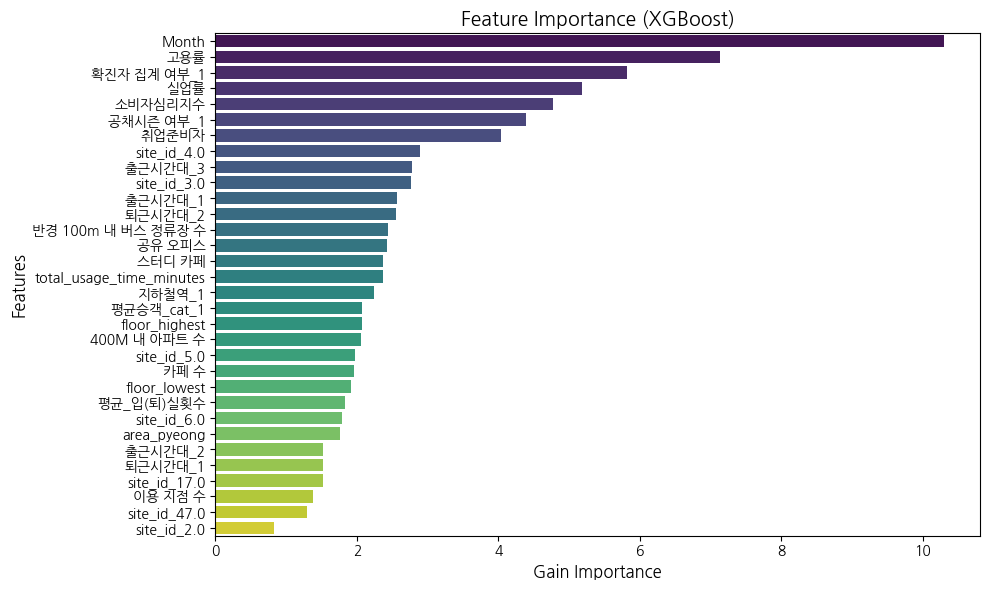

In [ ]:
# Feature Importance 추출
importance = best_model_XGB.get_booster().get_score(importance_type='gain')  # 'weight', 'gain', 'cover' 사용 가능 -> gain 사용
xgb_importance_df = pd.DataFrame({
    'Feature': importance.keys(),
    'Importance': importance.values()})
xgb_importance_df.sort_values(by='Importance', ascending=False, inplace=True)


# Feature Importance 시각화 (XGBoost)
plt.figure(figsize=(10, 6))
sns.barplot(data=xgb_importance_df, x='Importance', y='Feature', palette="viridis")
plt.title("Feature Importance (XGBoost)", fontsize=14)
plt.xlabel("Gain Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.show()

## Permutation importance

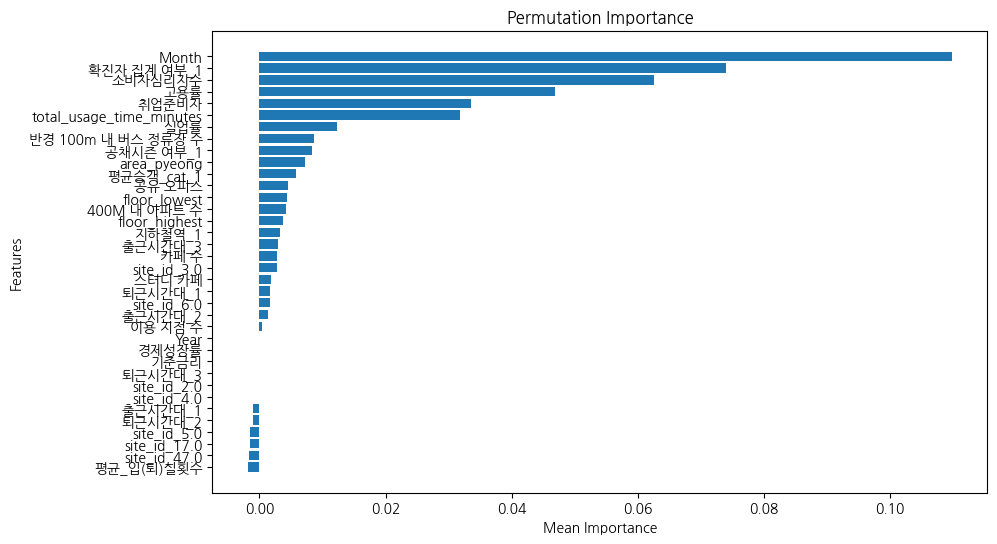

In [ ]:
# 분할
X_train, X_test, y_train, y_test = train_test_split(one_hot_X, y_resampled, stratify= y_resampled, test_size=0.3, random_state=42)

# Permutation Importance
perm_importance = permutation_importance(best_model_XGB, X_test, y_test, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance')

# Permutation Importance 시각화
plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df['Feature'], perm_importance_df['Importance'])
plt.title("Permutation Importance")
plt.xlabel("Mean Importance")
plt.ylabel("Features")
plt.show()

## SHAP value

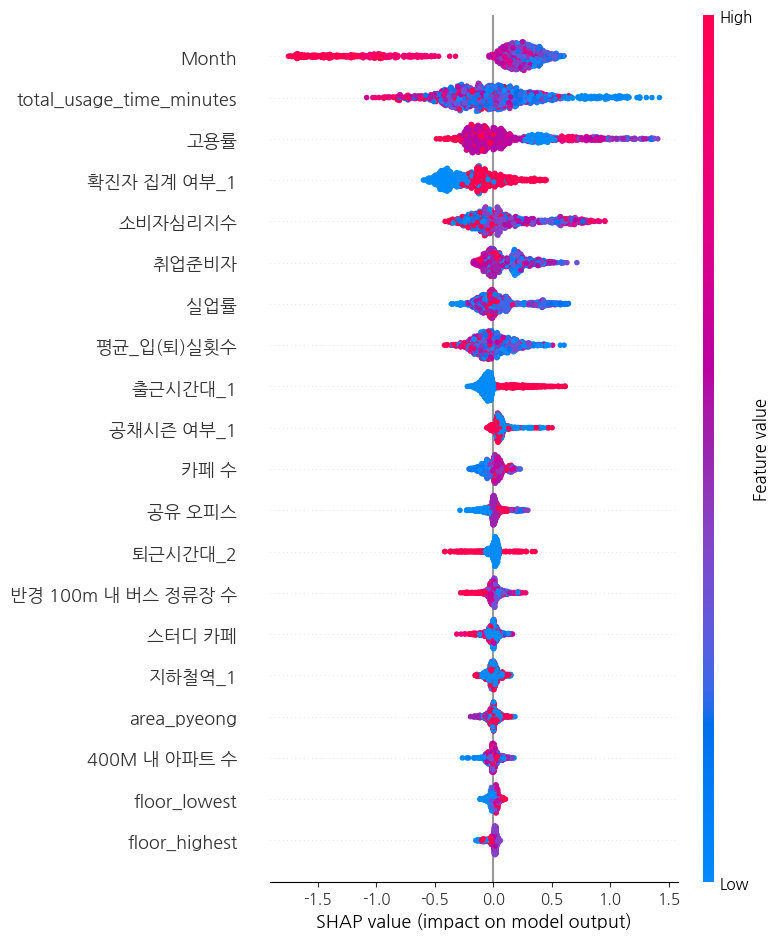

In [ ]:
# SHAP Explainer 생성
explainer = shap.TreeExplainer(best_model_XGB)
shap_values = explainer.shap_values(X_train)            # SHAP 값 계산

shap.summary_plot(shap_values, X_train)

SHAP value를 통해 월, 확진자 집계 여부, 최저층, 오전 출근이 23년 4월 이후 유료 전환에 영향을 주는 것을 확인했다.

In [ ]:
# floor_lowest의 임계점 찾기
floor_lowest_df = pd.DataFrame({'floor_lowest':X_train['floor_lowest'], 'shap_value':shap_values[:, list(X_train.columns).index("floor_lowest")]})
floor_lowest_df

,floor_lowest,shap_value
67,0,-0.014135
1090,3,0.040500
1882,2,0.021771
17,1,0.005126
1412,3,0.018428
...,...,...
1260,1,0.003014
1644,1,0.007305
468,1,0.005563
711,0,-0.010592


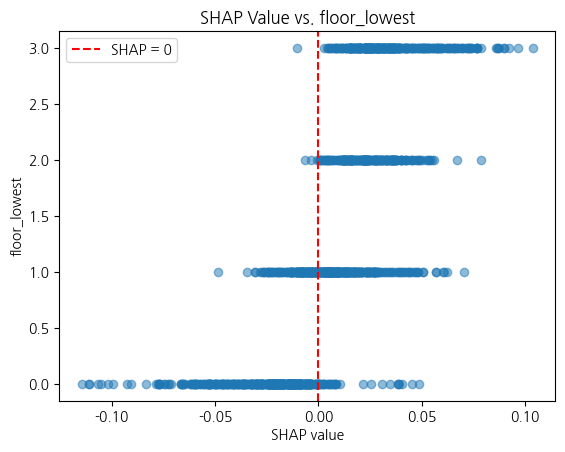

임계점 (floor_lowest SHAP 값이 0인 값): 0


In [ ]:

# SHAP 값과 floor_lowest의 관계 시각화
plt.scatter(floor_lowest_df["shap_value"], floor_lowest_df["floor_lowest"], alpha=0.5)
plt.axvline(0, color="red", linestyle="--", label="SHAP = 0")
plt.xlabel("SHAP value")
plt.ylabel("floor_lowest")
plt.title("SHAP Value vs. floor_lowest")
plt.legend()
plt.show()

# 임계점 찾기 (SHAP 값이 0에 가까운 euribor3m 값)
threshold = floor_lowest_df.loc[floor_lowest_df["shap_value"].abs().idxmin(), "floor_lowest"]
print("임계점 (floor_lowest SHAP 값이 0인 값):", threshold)

혹시 Month가 확진자 집계 여부와 겹치는 건 아닐까? Month를 제거한 후에 돌려서 비교해보자.

# Feature Engineering5

## month만 제거하기

In [ ]:
X5 = X_resampled.copy()
X5.drop('Month',axis=1,inplace=True)

one_hot_X = pd.get_dummies(X5, columns=['출근시간대','퇴근시간대','site_id','거리두기 정책','공채시즌 여부','확진자 집계 여부','지하철역','평균승객_cat'], drop_first=True, dtype=int)
one_hot_X

,평균_입(퇴)실횟수,total_usage_time_minutes,이용 지점 수,area_pyeong,floor_lowest,floor_highest,반경 100m 내 버스 정류장 수,400M 내 아파트 수,카페 수,스터디 카페,...,site_id_3.0,site_id_4.0,site_id_5.0,site_id_6.0,site_id_17.0,site_id_47.0,공채시즌 여부_1,확진자 집계 여부_1,지하철역_1,평균승객_cat_1
0,2.000000,285.695796,1,150.000000,3,4,1.000000,5.000000,10.000000,9.000000,...,1,0,0,0,0,0,1,1,1,0
1,4.500000,391.012098,1,50.000000,0,-1,2.000000,1.000000,7.000000,0.000000,...,0,0,0,0,0,1,1,1,1,1
2,1.500000,893.236125,1,100.000000,2,2,0.000000,15.000000,12.000000,11.000000,...,0,0,0,0,0,0,1,1,0,1
3,8.000000,864.779587,1,150.000000,0,1,2.000000,9.000000,8.000000,0.000000,...,0,0,0,1,0,0,1,1,0,1
4,4.000000,278.990516,1,150.000000,0,1,2.000000,9.000000,8.000000,0.000000,...,0,0,0,1,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1949,3.734015,889.626583,1,150.000000,3,1,1.200584,5.802336,9.598832,7.194743,...,0,0,1,0,0,0,0,1,1,1
1950,2.263259,112.526590,1,150.000000,3,1,1.694696,10.557572,10.694696,7.610607,...,0,0,0,1,0,0,1,0,1,1
1951,2.636073,287.830730,1,50.000000,1,1,1.000000,9.000000,6.000000,0.000000,...,0,0,0,0,0,0,0,1,1,1
1952,1.000000,152.047642,1,100.000000,2,2,0.000000,15.000000,12.000000,11.000000,...,0,0,0,0,0,0,0,1,0,1


In [ ]:
cat_features = ['출근시간대','퇴근시간대','site_id','거리두기 정책','공채시즌 여부','확진자 집계 여부','지하철역','평균승객_cat']
Cat_X = X5.copy()
for i in cat_features:
    Cat_X[i] = Cat_X[i].astype(str)

## 랜덤 포레스트

In [ ]:
# 분할
X_train, X_test, y_train, y_test = train_test_split(one_hot_X, y_resampled, stratify= y_resampled, test_size=0.3, random_state=42)

# 모델 생성
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# 모델 학습
rf_model.fit(X_train, y_train)

# 테스트 데이터 예측
y_pred = rf_model.predict(X_test)

# 정확도 계산
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.74
              precision    recall  f1-score   support

           0       0.71      0.82      0.76       294
           1       0.78      0.67      0.72       293

    accuracy                           0.74       587
   macro avg       0.75      0.74      0.74       587
weighted avg       0.75      0.74      0.74       587



In [ ]:
# 하이퍼파라미터 최적화 함수 정의
def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    # 랜덤 포레스트 모델 생성
    model = RandomForestClassifier(
        n_estimators=int(n_estimators),  # 정수형으로 변환
        max_depth=int(max_depth),       # 정수형으로 변환
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        random_state=42,
        n_jobs=-1
    )
    # 5-폴드 교차 검증의 평균 정확도를 반환
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

# Bayesian Optimization 설정
optimizer = BayesianOptimization(
    f=rf_cv,  # 최적화할 함수
    pbounds={
        'n_estimators': (10, 1000),        # 트리 개수
        'max_depth': (5, 50),            # 최대 깊이
        'min_samples_split': (2, 20),    # 내부 노드 분할 최소 샘플 수
        'min_samples_leaf': (1, 20)      # 리프 노드 최소 샘플 수
    },
    random_state=42,
    verbose=2
)

# 최적화 수행
optimizer.maximize(init_points=5, n_iter=25)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", optimizer.max)

# 최적의 하이퍼파라미터 추출
best_params = optimizer.max['params']

# 최적 하이퍼파라미터로 모델 학습
best_model_RF = RandomForestClassifier(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    min_samples_leaf=int(best_params['min_samples_leaf']),
    random_state=42,
    n_jobs=-1
)
best_model_RF.fit(X_train, y_train)

# 각 데이터셋에 예측 적용
y_pred_train = best_model_RF.predict(X_train)
y_pred_train_proba = best_model_RF.predict_proba(X_train)[:, 1]  # ROC-AUC 평가를 위한 확률 값

y_pred_test = best_model_RF.predict(X_test)
y_pred_test_proba = best_model_RF.predict_proba(X_test)[:, 1]  # ROC-AUC 평가를 위한 확률 값

# 평가
print("정확도 (Accuracy):", accuracy_score(y_train, y_pred_train))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_train, y_pred_train))
print("ROC-AUC 점수:", roc_auc_score(y_train, y_pred_train_proba))

print("정확도 (Accuracy):", accuracy_score(y_test, y_pred_test))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_test))
print("ROC-AUC 점수:", roc_auc_score(y_test, y_pred_test_proba))

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.7198    | 21.85     | 19.06     | 15.18     | 602.7     |
| 2         | 0.7432    | 12.02     | 3.964     | 3.046     | 867.5     |
| 3         | 0.7337    | 32.05     | 14.45     | 2.371     | 970.2     |
| 4         | 0.7439    | 42.46     | 5.034     | 5.273     | 191.6     |
| 5         | 0.73      | 18.69     | 10.97     | 9.775     | 298.3     |
| 6         | 0.749     | 12.01     | 6.121     | 3.797     | 866.5     |
| 7         | 0.7263    | 7.508     | 8.481     | 4.294     | 864.9     |
| 8         | 0.7329    | 12.58     | 8.54      | 4.271     | 864.7     |
| 9         | 0.7402    | 12.5      | 7.476     | 3.611     | 867.6     |
| 10        | 0.7447    | 12.36     | 5.985     | 7.172     | 868.9     |
| 11        | 0.7454    | 10.38     | 3.483     | 5.383     | 866.2     |
| 12        | 0.7403    | 11.29     | 

## XGB

In [ ]:
# 하이퍼파라미터 최적화 함수 정의
def xgb_cv(max_depth, learning_rate, n_estimators, gamma, min_child_weight, subsample, colsample_bytree):
    model = xgb.XGBClassifier(
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
        gamma=gamma,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        eval_metric="logloss",
        random_state=42
    )
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

# Bayesian Optimization 설정
optimizer = BayesianOptimization(
    f=xgb_cv,
    pbounds={
        'max_depth': (3, 10),
        'learning_rate': (0.01, 0.3),
        'n_estimators': (50, 300),
        'gamma': (0, 5),
        'min_child_weight': (1, 10),
        'subsample': (0.6, 1.0),
        'colsample_bytree': (0.6, 1.0)
    },
    random_state=42,
    verbose=2
)

# 최적화 수행
optimizer.maximize(init_points=5, n_iter=25)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", optimizer.max)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.7308    | 0.7498    | 4.754     | 0.2223    | 7.191     | 2.404     | 89.0      | 0.6232    |
| 2         | 0.7227    | 0.9465    | 3.006     | 0.2153    | 3.144     | 9.729     | 258.1     | 0.6849    |
| 3         | 0.741     | 0.6727    | 0.917     | 0.09823   | 6.673     | 4.888     | 122.8     | 0.8447    |
| 4         | 0.7395    | 0.6558    | 1.461     | 0.1162    | 6.192     | 8.067     | 99.92     | 0.8057    |
| 5         | 0.7439    | 0.837     | 0.2323    | 0.1862    | 4.194     | 1.585     | 287.2     | 0.9863    |
| 6         | 0.7366    | 0.6374    | 1.974     | 0.1487    | 7.705     | 6.886     | 276.6     | 0.9355    |
| 7         | 0.7176    | 0.6257    | 0.5448    | 0.27      | 8.95      | 7.767     | 119.7     | 0.7991    |
| 8       

In [ ]:
# 최적의 하이퍼파라미터 추출
best_params = optimizer.max['params']

# 최적의 하이퍼파라미터로 모델 학습
best_model_XGB = xgb.XGBClassifier(
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    n_estimators=int(best_params['n_estimators']),
    gamma=best_params['gamma'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    eval_metric="logloss",
    random_state=42
)
best_model_XGB.fit(X_train, y_train)

# 각 데이터셋에 예측 적용
y_pred_train = best_model_XGB.predict(X_train)
y_pred_train_proba = best_model_XGB.predict_proba(X_train)[:, 1]  # ROC-AUC 평가를 위한 확률 값

y_pred_test = best_model_XGB.predict(X_test)
y_pred_test_proba = best_model_XGB.predict_proba(X_test)[:, 1]  # ROC-AUC 평가를 위한 확률 값

# 평가
print("정확도 (Accuracy):", accuracy_score(y_train, y_pred_train))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_train, y_pred_train))
print("ROC-AUC 점수:", roc_auc_score(y_train, y_pred_train_proba))

print("정확도 (Accuracy):", accuracy_score(y_test, y_pred_test))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_test))
print("ROC-AUC 점수:", roc_auc_score(y_test, y_pred_test_proba))

정확도 (Accuracy): 0.8478419897585955

분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.81      0.92      0.86       683
           1       0.90      0.78      0.84       684

    accuracy                           0.85      1367
   macro avg       0.85      0.85      0.85      1367
weighted avg       0.85      0.85      0.85      1367

ROC-AUC 점수: 0.9326650569811546
정확도 (Accuracy): 0.7240204429301533

분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.70      0.80      0.74       294
           1       0.76      0.65      0.70       293

    accuracy                           0.72       587
   macro avg       0.73      0.72      0.72       587
weighted avg       0.73      0.72      0.72       587

ROC-AUC 점수: 0.8020419772004365


## LGB

In [ ]:
# 하이퍼파라미터 최적화 함수 정의
def lgbm_cv(num_leaves, max_depth, learning_rate, n_estimators, min_child_samples, subsample, colsample_bytree):
    model = LGBMClassifier(
        num_leaves=int(num_leaves),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
        min_child_samples=int(min_child_samples),
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

# Bayesian Optimization 설정
optimizer = BayesianOptimization(
    f=lgbm_cv,
    pbounds={
        'num_leaves': (20, 50),
        'max_depth': (3, 15),
        'learning_rate': (0.01, 0.3),
        'n_estimators': (50, 300),
        'min_child_samples': (5, 30),
        'subsample': (0.6, 1.0),
        'colsample_bytree': (0.6, 1.0)
    },
    random_state=42,
    verbose=-1
)

# 최적화 수행
optimizer.maximize(init_points=5, n_iter=25)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", optimizer.max)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.7979    | 0.7498    | 0.2857    | 11.78     | 19.97     | 89.0      | 24.68     | 0.6232    |
| 2         | 0.7972    | 0.9465    | 0.1843    | 11.5      | 5.515     | 292.5     | 44.97     | 0.6849    |
| 3         | 0.8151    | 0.6727    | 0.06319   | 6.651     | 18.12     | 158.0     | 28.74     | 0.8447    |
| 4         | 0.8039    | 0.6558    | 0.09472   | 7.396     | 16.4      | 246.3     | 25.99     | 0.8057    |
| 5         | 0.8108    | 0.837     | 0.02347   | 10.29     | 9.263     | 66.26     | 48.47     | 0.9863    |
| 6         | 0.799     | 0.6562    | 0.2389    | 5.749     | 19.23     | 157.0     | 29.11     | 0.9148    |
| 7         | 0.8045    | 0.6257    | 0.0416    | 13.76     | 26.25     | 238.0     | 28.37     | 0.7991    |
| 8       

In [ ]:
# 최적의 하이퍼파라미터 추출
best_params = optimizer.max['params']

# 최적의 하이퍼파라미터로 모델 학습
best_model_LGB = LGBMClassifier(
    num_leaves=int(best_params['num_leaves']),
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    n_estimators=int(best_params['n_estimators']),
    min_child_samples=int(best_params['min_child_samples']),
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    random_state=42,
    verbose = -1
)
best_model_LGB.fit(X_train, y_train)

# 각 데이터셋에 예측 적용
y_pred_train = best_model_LGB.predict(X_train)
y_pred_train_proba = best_model_LGB.predict_proba(X_train)[:, 1]  # ROC-AUC 평가를 위한 확률 값

y_pred_test = best_model_LGB.predict(X_test)
y_pred_test_proba = best_model_LGB.predict_proba(X_test)[:, 1]  # ROC-AUC 평가를 위한 확률 값

# 평가
print("정확도 (Accuracy):", accuracy_score(y_train, y_pred_train))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_train, y_pred_train))
print("ROC-AUC 점수:", roc_auc_score(y_train, y_pred_train_proba))

print("정확도 (Accuracy):", accuracy_score(y_test, y_pred_test))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_test))
print("ROC-AUC 점수:", roc_auc_score(y_test, y_pred_test_proba))

정확도 (Accuracy): 0.9122165325530358

분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.87      0.96      0.92       683
           1       0.96      0.86      0.91       684

    accuracy                           0.91      1367
   macro avg       0.92      0.91      0.91      1367
weighted avg       0.92      0.91      0.91      1367

ROC-AUC 점수: 0.9764958088241591
정확도 (Accuracy): 0.7444633730834753

분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.71      0.82      0.76       294
           1       0.79      0.67      0.72       293

    accuracy                           0.74       587
   macro avg       0.75      0.74      0.74       587
weighted avg       0.75      0.74      0.74       587

ROC-AUC 점수: 0.803098372454784


## CATboost

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Cat_X, y_resampled, test_size=0.3, stratify= y_resampled, random_state=42)

categorical_features = ['출근시간대','퇴근시간대','site_id','거리두기 정책','공채시즌 여부','확진자 집계 여부','지하철역','평균승객_cat','floor_lowest','floor_highest']

# Pool 객체 생성
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

# 2. CatBoost 평가 함수 정의
def catboost_eval(depth, learning_rate, l2_leaf_reg, bagging_temperature, border_count):
    model = CatBoostClassifier(
        iterations=100,  # 부스팅 반복 횟수
        depth=int(depth),  # 트리 깊이
        learning_rate=learning_rate,  # 학습률
        l2_leaf_reg=l2_leaf_reg,  # L2 정규화
        bagging_temperature=bagging_temperature,  # 배깅 온도
        border_count=int(border_count),  # 히스토그램 경계 개수
        loss_function='Logloss',  # 로그 손실 함수
        verbose=0,  # 출력 비활성화
        random_seed=42
    )
    model.fit(train_pool, verbose=0)
    
    # 검증 데이터에서 Log Loss 계산 (낮을수록 좋음)
    y_pred = model.predict_proba(test_pool)
    return -log_loss(y_test, y_pred)

# 3. Bayesian Optimization 설정
pbounds = {
    'depth': (4, 10),
    'learning_rate': (0.01, 0.3),
    'l2_leaf_reg': (1, 10),
    'bagging_temperature': (0, 1),
    'border_count': (32, 255)
}

optimizer = BayesianOptimization(
    f=catboost_eval,  # 평가 함수
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

# 4. 최적화 수행
optimizer.maximize(init_points=5, n_iter=25)

# 5. 최적 하이퍼파라미터 확인
print("최적 하이퍼파라미터:", optimizer.max['params'])

|   iter    |  target   | baggin... | border... |   depth   | l2_lea... | learni... |
-------------------------------------------------------------------------------------
| 1         | -0.5279   | 0.3745    | 244.0     | 8.392     | 6.388     | 0.05525   |
| 2         | -0.5591   | 0.156     | 44.95     | 9.197     | 6.41      | 0.2153    |
| 3         | -0.5284   | 0.02058   | 248.3     | 8.995     | 2.911     | 0.06273   |
| 4         | -0.51     | 0.1834    | 99.85     | 7.149     | 4.888     | 0.09446   |
| 5         | -0.5042   | 0.6119    | 63.11     | 5.753     | 4.297     | 0.1423    |
| 6         | -0.5074   | 0.4777    | 72.39     | 5.625     | 4.771     | 0.1157    |
| 7         | -0.5646   | 0.7592    | 115.8     | 9.492     | 9.631     | 0.2628    |
| 8         | -0.5038   | 0.1673    | 62.55     | 5.806     | 5.407     | 0.1577    |
| 9         | -0.526    | 0.2303    | 87.98     | 9.994     | 1.516     | 0.04175   |
| 10        | -0.5115   | 0.8984    | 187.8     | 5.76

In [ ]:
# 최적의 하이퍼파라미터로 모델 학습
best_params = optimizer.max['params']
best_params['depth'] = int(best_params['depth'])
best_params['border_count'] = int(best_params['border_count'])

final_model = CatBoostClassifier(
    iterations=100,
    loss_function='Logloss',
    random_seed=42,
    **best_params
)

# 모델 학습
final_model.fit(train_pool)

# 각 데이터셋에 예측 적용
y_pred_train = final_model.predict(X_train)
y_pred_train_proba = final_model.predict_proba(X_train)[:, 1]  # ROC-AUC 평가를 위한 확률 값

y_pred_test = final_model.predict(X_test)
y_pred_test_proba = final_model.predict_proba(X_test)[:, 1]  # ROC-AUC 평가를 위한 확률 값

# 평가
print("정확도 (Accuracy):", accuracy_score(y_train, y_pred_train))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_train, y_pred_train))
print("ROC-AUC 점수:", roc_auc_score(y_train, y_pred_train_proba))

print("정확도 (Accuracy):", accuracy_score(y_test, y_pred_test))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_test))
print("ROC-AUC 점수:", roc_auc_score(y_test, y_pred_test_proba))

0:	learn: 0.6557828	total: 15.8ms	remaining: 1.56s
1:	learn: 0.6400145	total: 29.3ms	remaining: 1.44s
2:	learn: 0.6342242	total: 44.2ms	remaining: 1.43s
3:	learn: 0.6257678	total: 56.8ms	remaining: 1.36s
4:	learn: 0.6152627	total: 69.9ms	remaining: 1.33s
5:	learn: 0.5970936	total: 83ms	remaining: 1.3s
6:	learn: 0.5911677	total: 95.7ms	remaining: 1.27s
7:	learn: 0.5831829	total: 108ms	remaining: 1.24s
8:	learn: 0.5660488	total: 120ms	remaining: 1.22s
9:	learn: 0.5613136	total: 137ms	remaining: 1.23s
10:	learn: 0.5585858	total: 149ms	remaining: 1.21s
11:	learn: 0.5553734	total: 161ms	remaining: 1.18s
12:	learn: 0.5480977	total: 173ms	remaining: 1.16s
13:	learn: 0.5447357	total: 185ms	remaining: 1.14s
14:	learn: 0.5443217	total: 193ms	remaining: 1.09s
15:	learn: 0.5425064	total: 206ms	remaining: 1.08s
16:	learn: 0.5395399	total: 217ms	remaining: 1.06s
17:	learn: 0.5377491	total: 231ms	remaining: 1.05s
18:	learn: 0.5356384	total: 243ms	remaining: 1.03s
19:	learn: 0.5351047	total: 250ms	rem

Month가 들어간 데이터셋에서 더 나은 모습을 보여주었다.

## feature Importance

C:\Users\csh94\AppData\Local\Temp\ipykernel_22920\1991505819.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette="viridis")


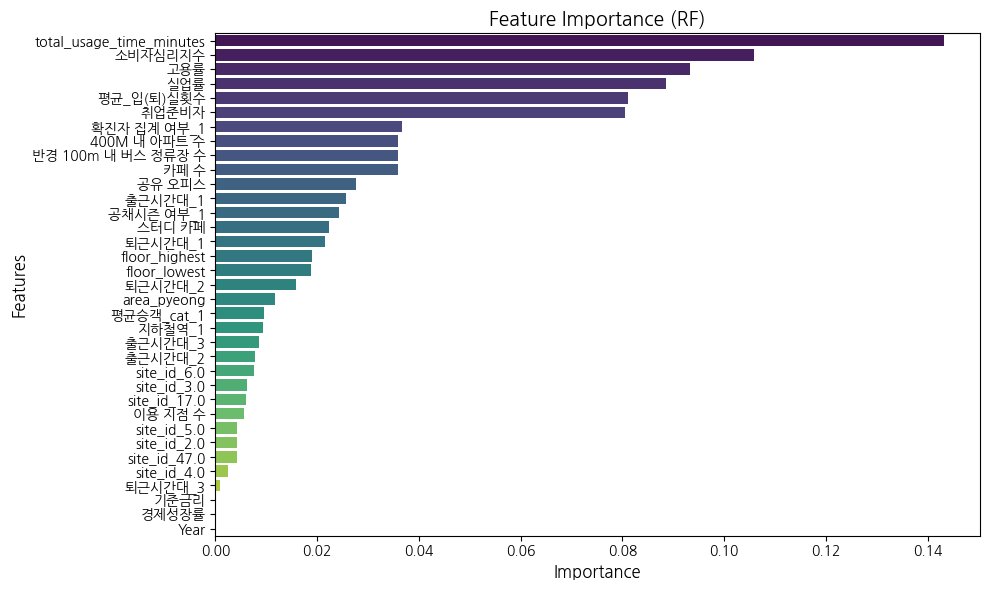

In [ ]:
# Feature Importance 추출
feature_importance = best_model_RF.feature_importances_

# 결과를 데이터프레임으로 보기 좋게 정리
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)


# Feature Importance 시각화 (XGBoost)
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette="viridis")
plt.title("Feature Importance (RF)", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.show()

## Permutation Importance

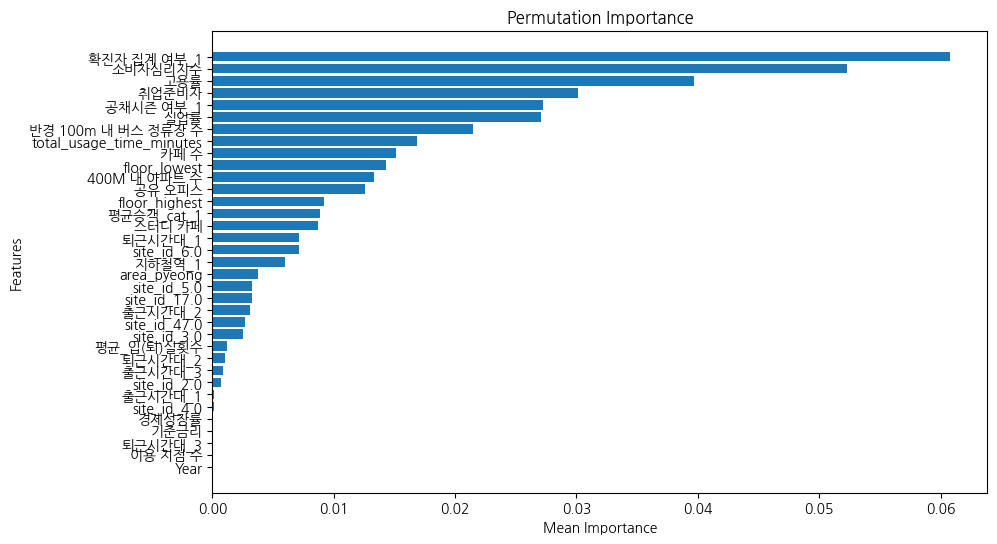

In [ ]:
# Permutation Importance
perm_importance = permutation_importance(best_model_RF, X_test, y_test, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance')

# Permutation Importance 시각화
plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df['Feature'], perm_importance_df['Importance'])
plt.title("Permutation Importance")
plt.xlabel("Mean Importance")
plt.ylabel("Features")
plt.show()

## SHAP values

In [ ]:
print(shap.__version__)

0.46.0


In [ ]:
X_train.shape

(1367, 35)

In [ ]:
print(best_model_RF.n_features_in_)

35


In [ ]:
# SHAP Explainer 생성
explainer = shap.TreeExplainer(best_model_RF)
shap_values = explainer.shap_values(X_train)            # SHAP 값 계산

print(type(shap_values))
print(len(shap_values))
print(shap_values[0].shape, shap_values[1].shape)


<class 'numpy.ndarray'>
1367
(35, 2) (35, 2)


In [ ]:
# 최신 버전의 shap에서는 3차원 배열로 한번에 나온다.
print("shap_values.shape:", shap_values.shape)

shap_values.shape: (1367, 35, 2)


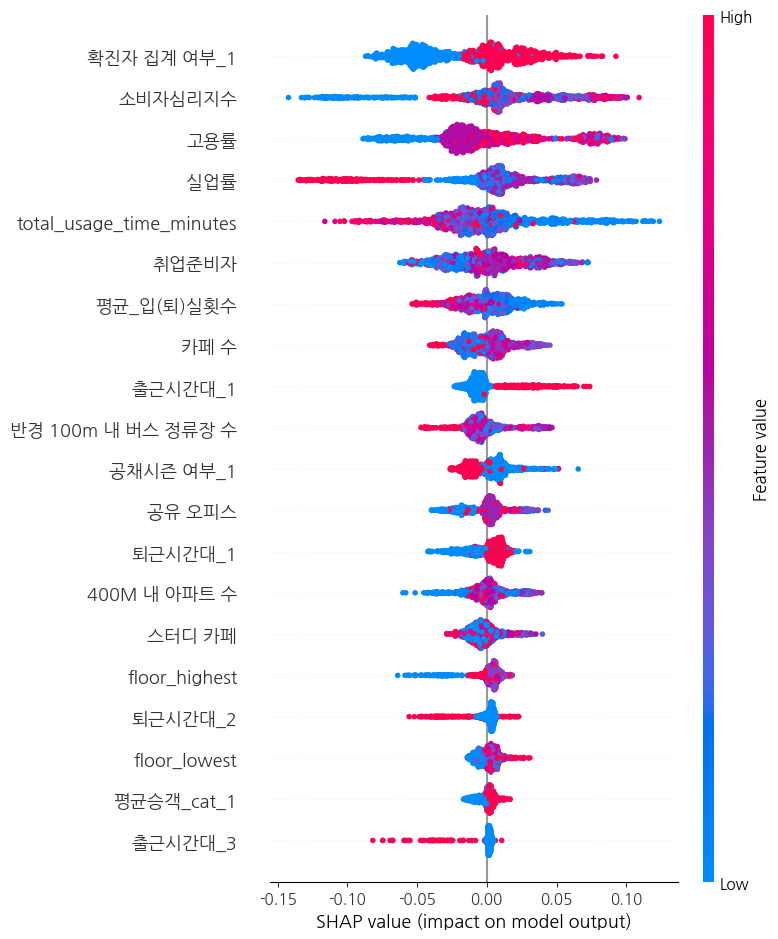

In [ ]:
# SHAP 값 시각화 (전체 데이터)

shap_values_class1 = shap_values[:, :, 1]

shap.summary_plot(shap_values_class1, X_train, feature_names=X_train.columns)

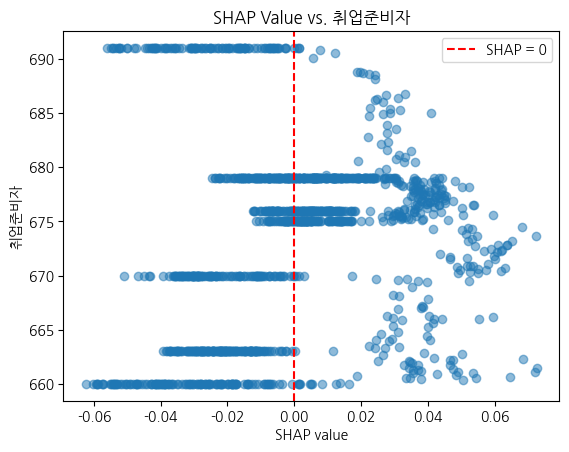

임계점 (취업준비자 SHAP 값이 0인 값): 676.0


In [ ]:
# 취업준비자의 임계점 찾기
preworker_df = pd.DataFrame({'취업준비자':X_train['취업준비자'], 'shap_value':shap_values[:, list(X_train.columns).index("취업준비자"), 1]})

# SHAP 값과 취업준비자 수의 관계 시각화
plt.scatter(preworker_df["shap_value"], preworker_df["취업준비자"], alpha=0.5)
plt.axvline(0, color="red", linestyle="--", label="SHAP = 0")
plt.xlabel("SHAP value")
plt.ylabel("취업준비자")
plt.title("SHAP Value vs. 취업준비자")
plt.legend()
plt.show()

# 임계점 찾기 (SHAP 값이 0에 가까운 euribor3m 값)
threshold = preworker_df.loc[preworker_df["shap_value"].abs().idxmin(), "취업준비자"]
print("임계점 (취업준비자 SHAP 값이 0인 값):", threshold)

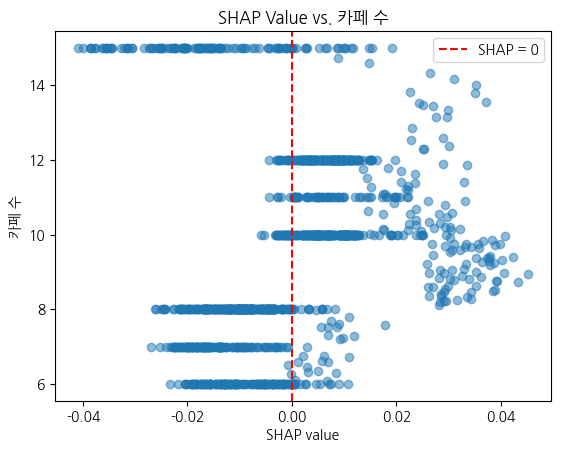

임계점 (카페 수 SHAP 값이 0인 값): 10.0


In [ ]:
# 카페 수의 임계점 찾기
cafe_df = pd.DataFrame({'카페 수':X_train['카페 수'], 'shap_value':shap_values[:, list(X_train.columns).index("카페 수"), 1]})

# SHAP 값과 취업준비자 수의 관계 시각화
plt.scatter(cafe_df["shap_value"], cafe_df["카페 수"], alpha=0.5)
plt.axvline(0, color="red", linestyle="--", label="SHAP = 0")
plt.xlabel("SHAP value")
plt.ylabel("카페 수")
plt.title("SHAP Value vs. 카페 수")
plt.legend()
plt.show()

# 임계점 찾기 (SHAP 값이 0에 가까운 euribor3m 값)
threshold = cafe_df.loc[cafe_df["shap_value"].abs().idxmin(), "카페 수"]
print("임계점 (카페 수 SHAP 값이 0인 값):", threshold)

# Feature Engineering6

## SMOTE 없이 23년 5~12월 데이터 분석

In [ ]:
data_2305.columns

Index(['출근시간대', '퇴근시간대', '평균_입(퇴)실횟수', 'site_id', 'total_usage_time_minutes',
       '이용 지점 수', 'area_pyeong', 'floor_num', 'floor_lowest', 'floor_highest',
       '지하철 역 거리', '평균승객', '반경 100m 내 버스 정류장 수', '400M 내 아파트 수', '카페 수',
       '스터디 카페', '공유 오피스', '수도권 확진자수', '거리두기 정책', '소비자심리지수', '경제성장률', '기준금리',
       '취업준비자', '고용률', '실업률', '공채시즌 여부', '확진자 집계 여부', 'is_payment', 'Year',
       'Month'],
      dtype='object')

In [ ]:

X6 = data_2305.copy()
X6['지하철역'] = X6['지하철 역 거리'].apply(lambda x: 0 if x <= 200 else 1)
X6 = X6.drop(['지하철 역 거리','수도권 확진자수','is_payment','Year'], axis=1)

#  카테고리 변인
col_cat = ['출근시간대','퇴근시간대','site_id','거리두기 정책','공채시즌 여부','확진자 집계 여부','지하철역']

# 정수형 변인
col_int = ['이용 지점 수', 'area_pyeong', 'floor_num', 'floor_lowest', 'floor_highest', 'Month']

# 실수형 변인
col_flo = ['평균_입(퇴)실횟수','total_usage_time_minutes','평균승객', '반경 100m 내 버스 정류장 수','400M 내 아파트 수','카페 수','스터디 카페','공유 오피스','소비자심리지수','기준금리','취업준비자','고용률','실업률']

col_for_catboost = col_cat + col_int
col_for_onehot = col_cat

X6[col_cat] = X6[col_cat].astype('category')
X6[col_int] = X6[col_int].astype(int)

y6 = data_2305['is_payment']

# 원핫인코딩
one_hot_X = pd.get_dummies(X6, columns=col_for_onehot, drop_first=True, dtype=int)
one_hot_X

# Catboost용 인코딩
cat_features = col_for_catboost
Cat_X = X6.copy()
for i in cat_features:
    Cat_X[i] = Cat_X[i].astype(str)

## 랜덤 포레스트

In [ ]:
# 분할
X_train, X_test, y_train, y_test = train_test_split(one_hot_X, y6, stratify= y6, test_size=0.3, random_state=42)

# 모델 생성
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# 모델 학습
rf_model.fit(X_train, y_train)

# 테스트 데이터 예측
y_pred = rf_model.predict(X_test)

# 정확도 계산
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.66
              precision    recall  f1-score   support

           0       0.71      0.85      0.77       293
           1       0.44      0.26      0.33       137

    accuracy                           0.66       430
   macro avg       0.58      0.55      0.55       430
weighted avg       0.63      0.66      0.63       430



In [ ]:
# 하이퍼파라미터 최적화 함수 정의
def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    # 랜덤 포레스트 모델 생성
    model = RandomForestClassifier(
        n_estimators=int(n_estimators),  # 정수형으로 변환
        max_depth=int(max_depth),       # 정수형으로 변환
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        random_state=42,
        n_jobs=-1
    )
    # 5-폴드 교차 검증의 평균 정확도를 반환
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

# Bayesian Optimization 설정
optimizer = BayesianOptimization(
    f=rf_cv,  # 최적화할 함수
    pbounds={
        'n_estimators': (10, 1000),        # 트리 개수
        'max_depth': (5, 50),            # 최대 깊이
        'min_samples_split': (2, 20),    # 내부 노드 분할 최소 샘플 수
        'min_samples_leaf': (1, 20)      # 리프 노드 최소 샘플 수
    },
    random_state=42,
    verbose=2
)

# 최적화 수행
optimizer.maximize(init_points=5, n_iter=25)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", optimizer.max)

# 최적의 하이퍼파라미터 추출
best_params = optimizer.max['params']

# 최적 하이퍼파라미터로 모델 학습
best_model_RF = RandomForestClassifier(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    min_samples_leaf=int(best_params['min_samples_leaf']),
    random_state=42,
    n_jobs=-1
)
best_model_RF.fit(X_train, y_train)

# 각 데이터셋에 예측 적용
y_pred_train = best_model_RF.predict(X_train)
y_pred_train_proba = best_model_RF.predict_proba(X_train)[:, 1]  # ROC-AUC 평가를 위한 확률 값

y_pred_test = best_model_RF.predict(X_test)
y_pred_test_proba = best_model_RF.predict_proba(X_test)[:, 1]  # ROC-AUC 평가를 위한 확률 값

# 평가
print("정확도 (Accuracy):", accuracy_score(y_train, y_pred_train))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_train, y_pred_train))
print("ROC-AUC 점수:", roc_auc_score(y_train, y_pred_train_proba))

print("정확도 (Accuracy):", accuracy_score(y_test, y_pred_test))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_test))
print("ROC-AUC 점수:", roc_auc_score(y_test, y_pred_test_proba))

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.68      | 21.85     | 19.06     | 15.18     | 602.7     |
| 2         | 0.6739    | 12.02     | 3.964     | 3.046     | 867.5     |
| 3         | 0.682     | 32.05     | 14.45     | 2.371     | 970.2     |
| 4         | 0.6819    | 42.46     | 5.034     | 5.273     | 191.6     |
| 5         | 0.6829    | 18.69     | 10.97     | 9.775     | 298.3     |
| 6         | 0.6829    | 16.8      | 10.33     | 9.546     | 298.3     |
| 7         | 0.671     | 19.68     | 3.93      | 4.631     | 399.8     |
| 8         | 0.6849    | 5.21      | 17.44     | 15.72     | 242.5     |
| 9         | 0.6839    | 8.367     | 13.52     | 18.44     | 10.77     |
| 10        | 0.684     | 5.18      | 11.64     | 16.27     | 98.64     |
| 11        | 0.6869    | 49.97     | 4.685     | 4.382     | 59.0      |
| 12        | 0.6669    | 49.04     | 

## XGB

In [ ]:
# 하이퍼파라미터 최적화 함수 정의
def xgb_cv(max_depth, learning_rate, n_estimators, gamma, min_child_weight, subsample, colsample_bytree):
    model = xgb.XGBClassifier(
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
        gamma=gamma,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        eval_metric="logloss",
        random_state=42
    )
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

# Bayesian Optimization 설정
optimizer = BayesianOptimization(
    f=xgb_cv,
    pbounds={
        'max_depth': (3, 10),
        'learning_rate': (0.01, 0.3),
        'n_estimators': (50, 300),
        'gamma': (0, 5),
        'min_child_weight': (1, 10),
        'subsample': (0.6, 1.0),
        'colsample_bytree': (0.6, 1.0)
    },
    random_state=42,
    verbose=2
)

# 최적화 수행
optimizer.maximize(init_points=5, n_iter=25)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", optimizer.max)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.6809    | 0.7498    | 4.754     | 0.2223    | 7.191     | 2.404     | 89.0      | 0.6232    |
| 2         | 0.6789    | 0.9465    | 3.006     | 0.2153    | 3.144     | 9.729     | 258.1     | 0.6849    |
| 3         | 0.6709    | 0.6727    | 0.917     | 0.09823   | 6.673     | 4.888     | 122.8     | 0.8447    |
| 4         | 0.6779    | 0.6558    | 1.461     | 0.1162    | 6.192     | 8.067     | 99.92     | 0.8057    |
| 5         | 0.665     | 0.837     | 0.2323    | 0.1862    | 4.194     | 1.585     | 287.2     | 0.9863    |
| 6         | 0.6769    | 0.6385    | 0.2316    | 0.1496    | 5.337     | 9.419     | 75.69     | 0.9704    |
| 7         | 0.684     | 0.7853    | 4.132     | 0.01213   | 7.498     | 3.51      | 89.08     | 0.8953    |
| 8       

In [ ]:
# 최적의 하이퍼파라미터 추출
best_params = optimizer.max['params']

# 최적의 하이퍼파라미터로 모델 학습
best_model_XGB = xgb.XGBClassifier(
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    n_estimators=int(best_params['n_estimators']),
    gamma=best_params['gamma'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    eval_metric="logloss",
    random_state=42
)
best_model_XGB.fit(X_train, y_train)

# 각 데이터셋에 예측 적용
y_pred_train = best_model_XGB.predict(X_train)
y_pred_train_proba = best_model_XGB.predict_proba(X_train)[:, 1]  # ROC-AUC 평가를 위한 확률 값

y_pred_test = best_model_XGB.predict(X_test)
y_pred_test_proba = best_model_XGB.predict_proba(X_test)[:, 1]  # ROC-AUC 평가를 위한 확률 값

# 평가
print("정확도 (Accuracy):", accuracy_score(y_train, y_pred_train))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_train, y_pred_train))
print("ROC-AUC 점수:", roc_auc_score(y_train, y_pred_train_proba))

print("정확도 (Accuracy):", accuracy_score(y_test, y_pred_test))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_test))
print("ROC-AUC 점수:", roc_auc_score(y_test, y_pred_test_proba))

정확도 (Accuracy): 0.7068793619142573

분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.70      0.99      0.82       684
           1       0.79      0.11      0.19       319

    accuracy                           0.71      1003
   macro avg       0.75      0.55      0.50      1003
weighted avg       0.73      0.71      0.62      1003

ROC-AUC 점수: 0.6964014005756293
정확도 (Accuracy): 0.6790697674418604

분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.69      0.97      0.81       293
           1       0.47      0.05      0.09       137

    accuracy                           0.68       430
   macro avg       0.58      0.51      0.45       430
weighted avg       0.62      0.68      0.58       430

ROC-AUC 점수: 0.6000224209660944


## LGB

In [ ]:
# 하이퍼파라미터 최적화 함수 정의
def lgbm_cv(num_leaves, max_depth, learning_rate, n_estimators, min_child_samples, subsample, colsample_bytree):
    model = LGBMClassifier(
        num_leaves=int(num_leaves),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
        min_child_samples=int(min_child_samples),
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

# Bayesian Optimization 설정
optimizer = BayesianOptimization(
    f=lgbm_cv,
    pbounds={
        'num_leaves': (20, 50),
        'max_depth': (3, 15),
        'learning_rate': (0.01, 0.3),
        'n_estimators': (50, 300),
        'min_child_samples': (5, 30),
        'subsample': (0.6, 1.0),
        'colsample_bytree': (0.6, 1.0)
    },
    random_state=42,
    verbose=-1
)

# 최적화 수행
optimizer.maximize(init_points=5, n_iter=25)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", optimizer.max)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.5746    | 0.7498    | 0.2857    | 11.78     | 19.97     | 89.0      | 24.68     | 0.6232    |
| 2         | 0.5594    | 0.9465    | 0.1843    | 11.5      | 5.515     | 292.5     | 44.97     | 0.6849    |
| 3         | 0.6061    | 0.6727    | 0.06319   | 6.651     | 18.12     | 158.0     | 28.74     | 0.8447    |
| 4         | 0.5877    | 0.6558    | 0.09472   | 7.396     | 16.4      | 246.3     | 25.99     | 0.8057    |
| 5         | 0.5731    | 0.837     | 0.02347   | 10.29     | 9.263     | 66.26     | 48.47     | 0.9863    |
| 6         | 0.5959    | 0.6693    | 0.1344    | 5.339     | 14.4      | 174.2     | 30.8      | 0.8628    |
| 7         | 0.5797    | 0.6166    | 0.1406    | 7.175     | 19.27     | 157.1     | 28.43     | 0.8644    |
| 8       

In [ ]:
# 최적의 하이퍼파라미터 추출
best_params = optimizer.max['params']

# 최적의 하이퍼파라미터로 모델 학습
best_model_LGB = LGBMClassifier(
    num_leaves=int(best_params['num_leaves']),
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    n_estimators=int(best_params['n_estimators']),
    min_child_samples=int(best_params['min_child_samples']),
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    random_state=42,
    verbose = -1
)
best_model_LGB.fit(X_train, y_train)

# 각 데이터셋에 예측 적용
y_pred_train = best_model_LGB.predict(X_train)
y_pred_train_proba = best_model_LGB.predict_proba(X_train)[:, 1]  # ROC-AUC 평가를 위한 확률 값

y_pred_test = best_model_LGB.predict(X_test)
y_pred_test_proba = best_model_LGB.predict_proba(X_test)[:, 1]  # ROC-AUC 평가를 위한 확률 값

# 평가
print("정확도 (Accuracy):", accuracy_score(y_train, y_pred_train))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_train, y_pred_train))
print("ROC-AUC 점수:", roc_auc_score(y_train, y_pred_train_proba))

print("정확도 (Accuracy):", accuracy_score(y_test, y_pred_test))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_test))
print("ROC-AUC 점수:", roc_auc_score(y_test, y_pred_test_proba))

정확도 (Accuracy): 0.8614157527417746

분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.85      0.96      0.90       684
           1       0.89      0.64      0.75       319

    accuracy                           0.86      1003
   macro avg       0.87      0.80      0.83      1003
weighted avg       0.87      0.86      0.85      1003

ROC-AUC 점수: 0.948665420081028
정확도 (Accuracy): 0.6534883720930232

분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.70      0.85      0.77       293
           1       0.42      0.23      0.29       137

    accuracy                           0.65       430
   macro avg       0.56      0.54      0.53       430
weighted avg       0.61      0.65      0.62       430

ROC-AUC 점수: 0.5532871627513016


## CATboost

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Cat_X, y6, test_size=0.3, stratify= y6, random_state=42)

# Pool 객체 생성
train_pool = Pool(X_train, y_train, cat_features=col_for_catboost)
test_pool = Pool(X_test, y_test, cat_features=col_for_catboost)

# 2. CatBoost 평가 함수 정의
def catboost_eval(depth, learning_rate, l2_leaf_reg, bagging_temperature, border_count):
    model = CatBoostClassifier(
        iterations=100,  # 부스팅 반복 횟수
        depth=int(depth),  # 트리 깊이
        learning_rate=learning_rate,  # 학습률
        l2_leaf_reg=l2_leaf_reg,  # L2 정규화
        bagging_temperature=bagging_temperature,  # 배깅 온도
        border_count=int(border_count),  # 히스토그램 경계 개수
        loss_function='Logloss',  # 로그 손실 함수
        verbose=0,  # 출력 비활성화
        random_seed=42
    )
    model.fit(train_pool, verbose=0)
    
    # 검증 데이터에서 Log Loss 계산 (낮을수록 좋음)
    y_pred = model.predict_proba(test_pool)
    return -log_loss(y_test, y_pred)

# 3. Bayesian Optimization 설정
pbounds = {
    'depth': (4, 10),
    'learning_rate': (0.01, 0.3),
    'l2_leaf_reg': (1, 10),
    'bagging_temperature': (0, 1),
    'border_count': (32, 255)
}

optimizer = BayesianOptimization(
    f=catboost_eval,  # 평가 함수
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

# 4. 최적화 수행
optimizer.maximize(init_points=5, n_iter=25)

# 5. 최적 하이퍼파라미터 확인
print("최적 하이퍼파라미터:", optimizer.max['params'])

|   iter    |  target   | baggin... | border... |   depth   | l2_lea... | learni... |
-------------------------------------------------------------------------------------
| 1         | -0.6347   | 0.3745    | 244.0     | 8.392     | 6.388     | 0.05525   |
| 2         | -0.7418   | 0.156     | 44.95     | 9.197     | 6.41      | 0.2153    |
| 3         | -0.6456   | 0.02058   | 248.3     | 8.995     | 2.911     | 0.06273   |
| 4         | -0.6537   | 0.1834    | 99.85     | 7.149     | 4.888     | 0.09446   |
| 5         | -0.6467   | 0.6119    | 63.11     | 5.753     | 4.297     | 0.1423    |
| 6         | -0.6392   | 0.2172    | 231.0     | 8.251     | 1.074     | 0.04124   |
| 7         | -0.6193   | 0.3839    | 79.37     | 4.28      | 1.505     | 0.05258   |
| 8         | -0.6149   | 0.8387    | 199.2     | 5.093     | 9.858     | 0.02637   |
| 9         | -0.6476   | 0.4897    | 198.4     | 4.854     | 8.965     | 0.2643    |
| 10        | -0.635    | 0.9401    | 200.7     | 6.14

In [ ]:
# 최적의 하이퍼파라미터로 모델 학습
best_params = optimizer.max['params']
best_params['depth'] = int(best_params['depth'])
best_params['border_count'] = int(best_params['border_count'])

final_model = CatBoostClassifier(
    iterations=100,
    loss_function='Logloss',
    random_seed=42,
    **best_params
)

# 모델 학습
final_model.fit(train_pool)

# 각 데이터셋에 예측 적용
y_pred_train = final_model.predict(X_train)
y_pred_train_proba = final_model.predict_proba(X_train)[:, 1]  # ROC-AUC 평가를 위한 확률 값

y_pred_test = final_model.predict(X_test)
y_pred_test_proba = final_model.predict_proba(X_test)[:, 1]  # ROC-AUC 평가를 위한 확률 값

# 평가
print("정확도 (Accuracy):", accuracy_score(y_train, y_pred_train))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_train, y_pred_train))
print("ROC-AUC 점수:", roc_auc_score(y_train, y_pred_train_proba))

print("정확도 (Accuracy):", accuracy_score(y_test, y_pred_test))
print("\n분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_test))
print("ROC-AUC 점수:", roc_auc_score(y_test, y_pred_test_proba))

0:	learn: 0.6906258	total: 14.6ms	remaining: 1.45s
1:	learn: 0.6866834	total: 39.4ms	remaining: 1.93s
2:	learn: 0.6831472	total: 79.3ms	remaining: 2.56s
3:	learn: 0.6793431	total: 114ms	remaining: 2.72s
4:	learn: 0.6746539	total: 165ms	remaining: 3.13s
5:	learn: 0.6723038	total: 187ms	remaining: 2.92s
6:	learn: 0.6693768	total: 213ms	remaining: 2.83s
7:	learn: 0.6659369	total: 238ms	remaining: 2.74s
8:	learn: 0.6623160	total: 265ms	remaining: 2.68s
9:	learn: 0.6605596	total: 276ms	remaining: 2.48s
10:	learn: 0.6570618	total: 303ms	remaining: 2.45s
11:	learn: 0.6545225	total: 340ms	remaining: 2.5s
12:	learn: 0.6511063	total: 372ms	remaining: 2.49s
13:	learn: 0.6482841	total: 404ms	remaining: 2.48s
14:	learn: 0.6451663	total: 430ms	remaining: 2.44s
15:	learn: 0.6417867	total: 455ms	remaining: 2.39s
16:	learn: 0.6385153	total: 475ms	remaining: 2.32s
17:	learn: 0.6352637	total: 495ms	remaining: 2.26s
18:	learn: 0.6322864	total: 516ms	remaining: 2.2s
19:	learn: 0.6304703	total: 540ms	remain

XGB는 SMOTE를 적용하지 않아도 적용했을 때와 유사한 성능을 보였다. 이에 XGB의 feature importance, permutation importance, SHAP value를 살펴보겠다.

## Feature Importance

## Permutation Importance

## SHAP value

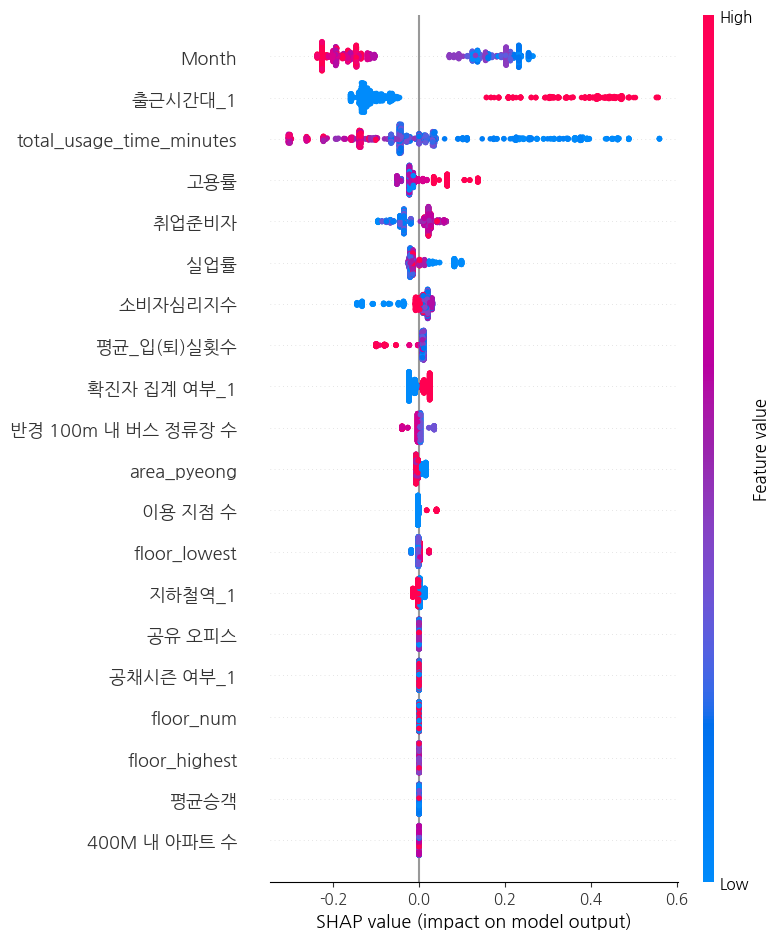

In [ ]:
# SHAP Explainer 생성
explainer = shap.TreeExplainer(best_model_XGB)
shap_values = explainer.shap_values(X_train)            # SHAP 값 계산

shap.summary_plot(shap_values, X_train)